In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# read case
print(os.getcwd())
case = os.getcwd().split(os.sep)[-1]
print(case)

D:\Promotion\neurolib\GUI\current\gui\data\11100
11100


### Bistability

In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

#####################################################
def getclosest(k_, found_solution, exc, inh, already_tried_):
    import numpy as np
    if len(found_solution) == 0:
        print("no solutions found")
        return -1
    
    start_ind = -1
    for j_ in found_solution:
        if j_ not in already_tried_ and j_ != k_:
            start_ind = j_
            break
            
    if start_ind == -1:
        return -1
        
    min_dist = np.sqrt((exc[k_] - exc[start_ind])**2 + (inh[k_] - inh[start_ind])**2)
    min_i = start_ind
        
    print(found_solution, already_tried_)
        
    if len(found_solution) == len(already_tried_):
        print("already tried all options")
        min_i = -1
        return min_i
    
    for i_ in found_solution:
        if i_ not in already_tried_:
            if i_ != k_ and i_ != min_i:
                dist_ = np.sqrt((exc[k_] - exc[i_])**2 + (inh[k_] - inh[i_])**2)
                if dist_ < min_dist:
                    min_dist = dist_
                    min_i = i_
                    
    if min_i == 0 and 0 in already_tried_:
        return -1
    
    return min_i

In [4]:
##### LOAD BOUNDARIES
data_file = 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))
#plt.scatter(exc, inh)

147


In [5]:
bestControl_init = [None] * len(exc)
bestState_init = [None] * len(exc)
cost_init = [None] * len(exc)
runtime_init = [None] * len(exc)
grad_init = [None] * len(exc)
phi_init = [None] * len(exc)
costnode_init = [None] * len(exc)
weights_init = [None] * len(exc)

conv_init = [[False]*2] * len(exc)

In [6]:
bestControl_0 = [None] * len(exc)
bestState_0 = [None] * len(exc)
cost_0 = [None] * len(exc)
runtime_0 = [None] * len(exc)
grad_0 = [None] * len(exc)
phi_0 = [None] * len(exc)
costnode_0 = [None] * len(exc)
weights_0 = [None] * len(exc)

conv_0 = [[False]*2] * len(exc)

In [7]:
bestControl_1 = [None] * len(exc)
bestState_1 = [None] * len(exc)
cost_1 = [None] * len(exc)
runtime_1 = [None] * len(exc)
grad_1 = [None] * len(exc)
phi_1 = [None] * len(exc)
costnode_1 = [None] * len(exc)
weights_1 = [None] * len(exc)

conv_1 = [[False]*2] * len(exc)

In [8]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [9]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [ [0], [1], [0,1]]
p_var = [ [0], [0], [0]]

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

if case[0] == '0':    # low to high
    max_I = [3., -3.]
elif case[0] == '1':
    max_I = [-3., 3.]
    
if case[1] == '0':    # sparsity
    factor_ws = 1.
    factor_we = 0.
elif case[1] == '1':  # energy
    factor_ws = 0.
    factor_we = 1.
    
if case[3] == '0':
    cntrl_vars_init = [0]
elif case[3] == '1':
    cntrl_vars_init = [1]
elif case[3] == '2':
    cntrl_vars_init = [0,1]

if case[4] == '0':
    dur = 100
    trans_time = 0.8
elif case[4] == '1':
    dur = 400
    trans_time = 0.95
    
maxC = [5., -5., 0.18, 0.]

n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [10]:
init_file = 'control_init_' + case + '.pickle'
final_file = 'control_' + case + '.pickle'
case_1 = case[0] + case[1] + '0' + case[3] + case[4]
final_file_1 = 'control_' + case_1 + '.pickle'

In [11]:
if os.path.isfile(init_file) :
    print("file found")
    
    with open(init_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_init = load_array[0]
    bestState_init = load_array[1]
    cost_init = load_array[2]
    runtime_init = load_array[3]
    grad_init = load_array[4]
    phi_init = load_array[5]
    costnode_init = load_array[6]
    weights_init = load_array[7]

file found


In [12]:
# get initial parameters and target states

i_stepsize = 2
limit = 40
i_range = range(0, limit,i_stepsize)
i_range_0 = range(0, limit,i_stepsize)
i_range_1 = range(0, limit,i_stepsize)
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    aln.params.duration = dur

    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = target_rates[0]
    target[i][:,1,:] = target_rates[1]

-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000

In [13]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
    cost.setParams(1.0, 0.0, 0.0)

##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, costnode_init_ = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  0 0.4000000000000001 0.3500000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5902.406479238383
Gradient descend method:  None
RUN  0 , total integrated cost =  5902.406479238383
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5538.707762167343
Gradient descend method:  None
RUN  0 , total integrated cost =  5538.707762167343
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13602.2666253313
Gradient descend method:  None
RUN  0 , total integrated cost =  13602.2666253313
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  6 0.4250000000000001 0.40000000000000013
set 

In [14]:
factor_iteration = 20.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    
    if not type(bestControl_init[i]) == type(None):
        continue
        
    control0 = aln.getZeroControl()

    ##### initial guess
    weight_ = 10
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(100 * factor_iteration)

    weights_init[i] = cost.getParams()

    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    j = 1
    while cost_init[i][-j] == 0.:
        j += 1
    
    weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
    print("weight = ", weight_)
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)
    control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(500 * factor_iteration)

    weights_init[i] = cost.getParams()
    
    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
    with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000

--------- 0


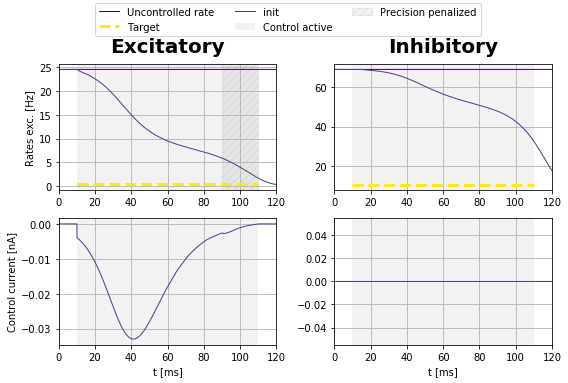

--------- 2


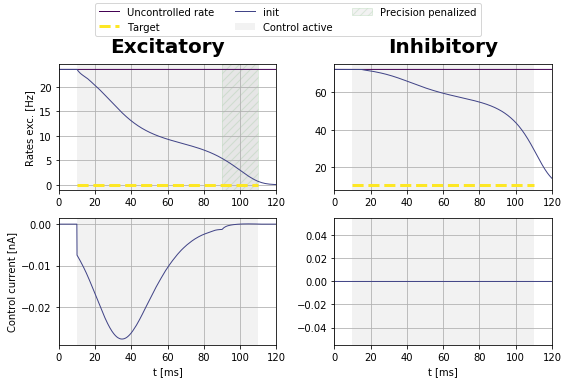

--------- 4


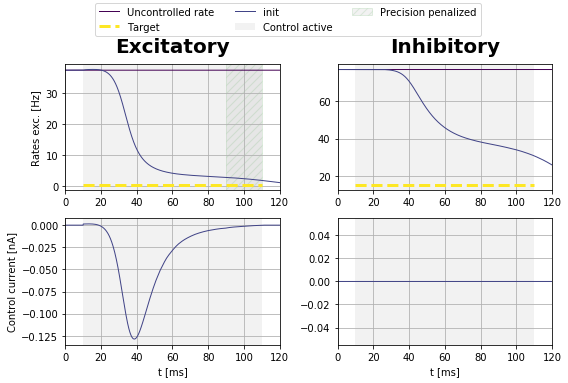

--------- 6


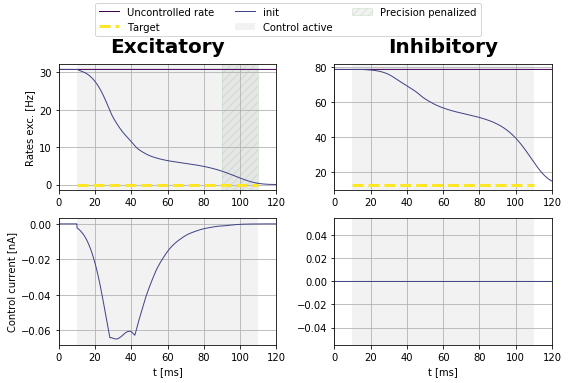

--------- 8


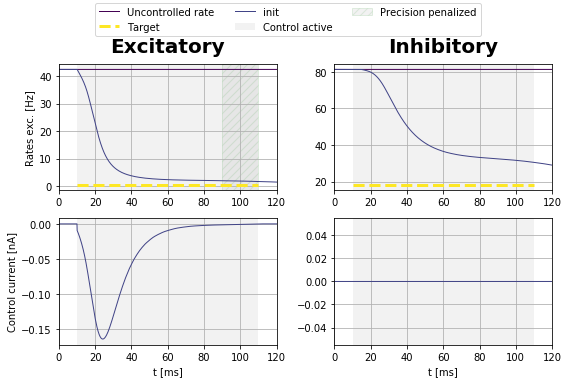

--------- 10


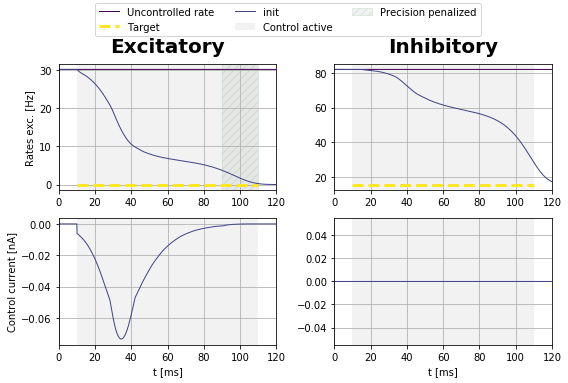

--------- 12


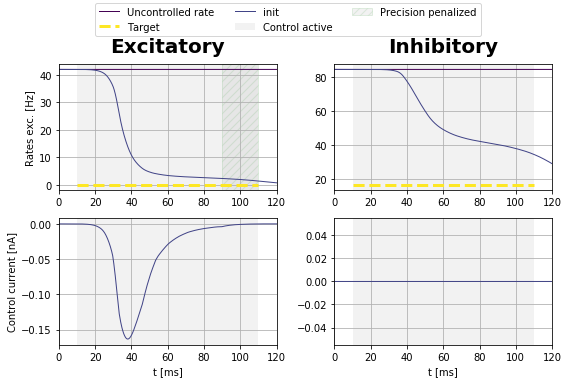

--------- 14


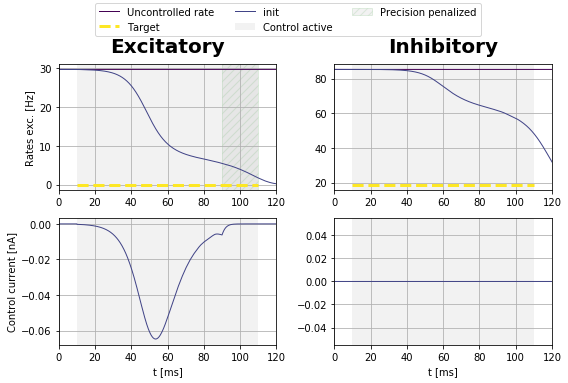

--------- 16


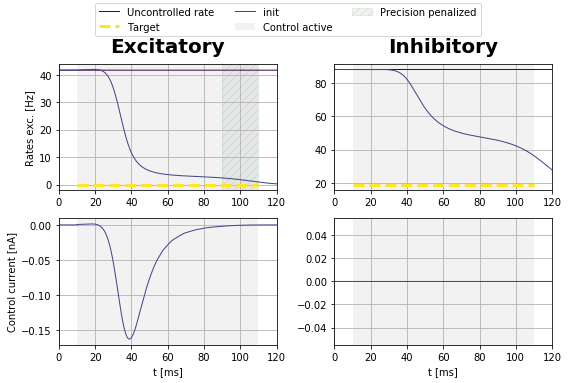

--------- 18


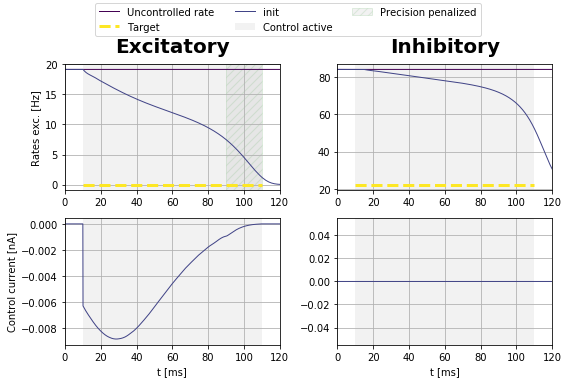

--------- 20


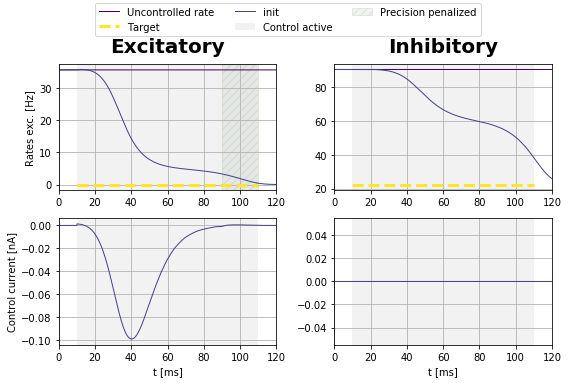

--------- 22


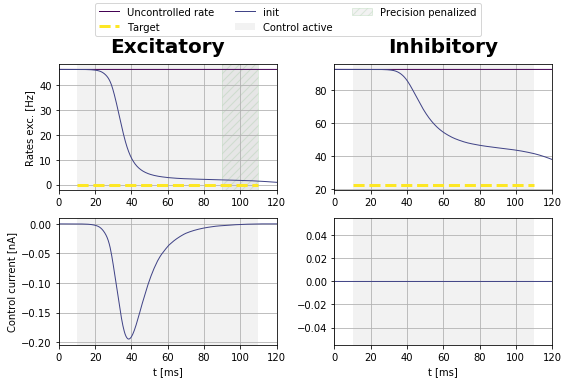

--------- 24


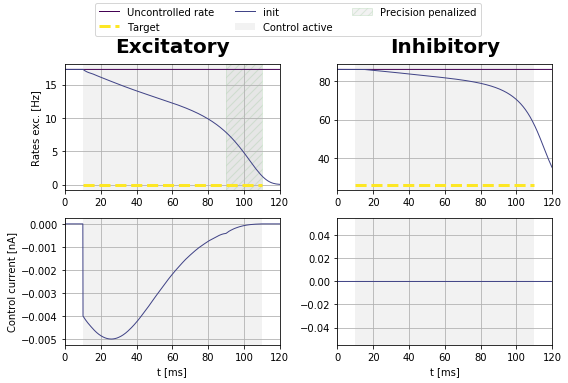

--------- 26


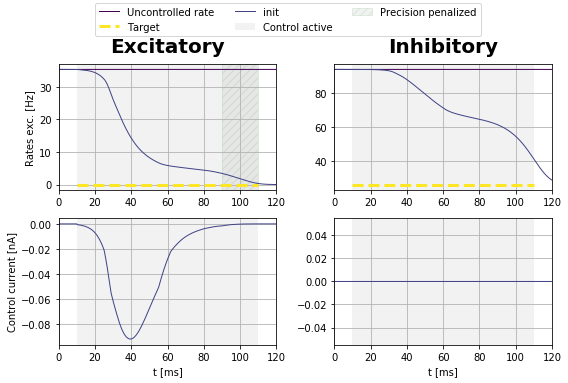

--------- 28


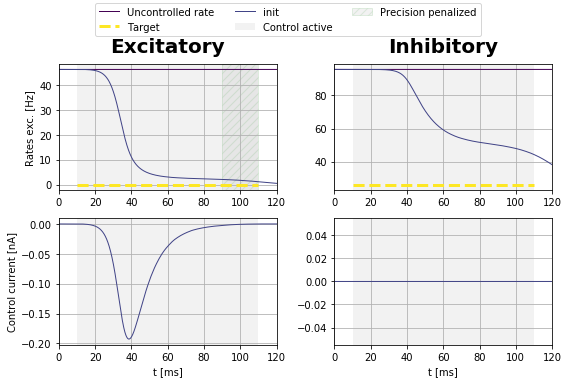

--------- 30


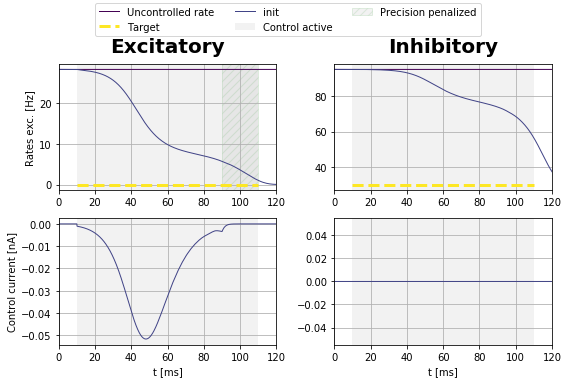

--------- 32


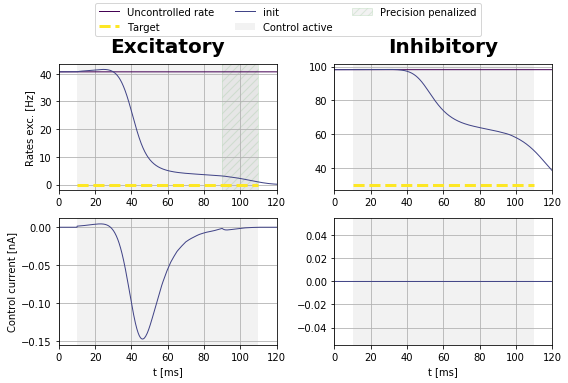

--------- 34


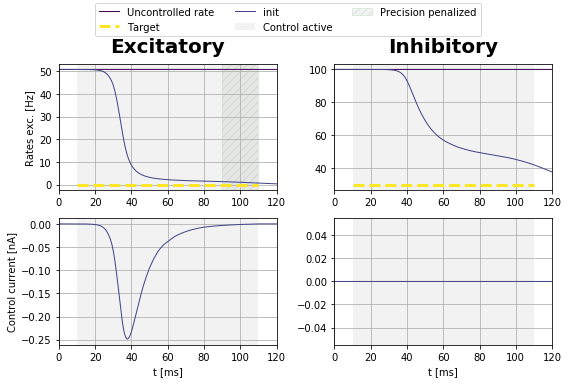

--------- 36


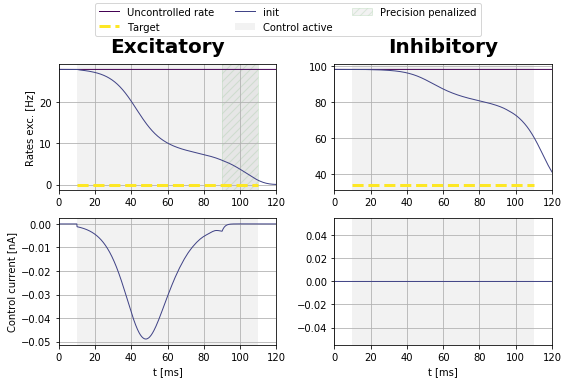

--------- 38


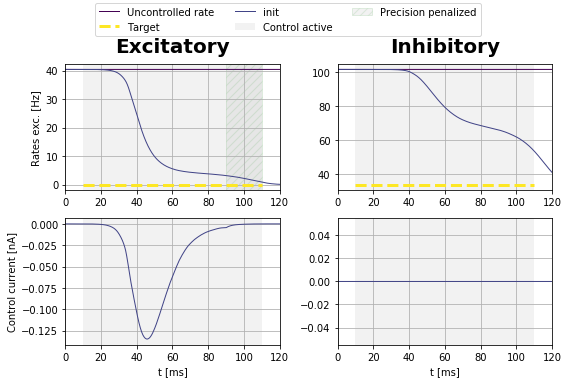

In [15]:

#plot initial guesses
for i in i_range:
    print("---------", i)

        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i]],
        [costnode_init[i]], [weights_init[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()


In [16]:
found_solution = []
no_solution = []
factor_iteration = 0.1
already_tried = [ [] for _ in range(len(exc)) ]

for k in range(len(i_range)**2):
    print('------------------------------------------------------------')
    print('--------------------', k)
    print('------------------------------------------------------------')
        
    print("found solution: ", found_solution)
    print("no solution: ", no_solution)
    
    if len(i_range) == len(found_solution) + len(no_solution):
        print("found solution for all parameters")
        break


    for i in i_range:
        print("------- ", i, exc[i], inh[i])        

        if np.abs(np.mean(bestState_init[i][0,0,-10:]) - target[i][0,0,-1]) < 0.1 * np.abs(
            np.mean(bestState_init[i][0,0,-10:]) - bestState_init[i][0,0,0]) and np.abs(
            np.mean(bestState_init[i][0,1,-10:]) - target[i][0,1,-1]) < 0.3 * np.abs(
            np.mean(bestState_init[i][0,1,-10:]) - bestState_init[i][0,1,0]) and np.amin(
            bestState_init[i][0,0,:]) > target[i][0,0,-1] - 5. and np.amin(
            bestState_init[i][0,1,:]) > target[i][0,1,-1] - 5.:
            # and np.amin(bestState_init[i][0,0,:]) > bestState_init[i][0,0,0] - 1.
            #and np.amin(bestState_init[i][0,1,:]) > bestState_init[i][0,1,0] - 1.:
            if i not in found_solution:
                print("found solution for ", i)
                found_solution.append(i)
            if i in no_solution:
                no_solution.pop(no_solution.index(i))
            continue
            
        closest_ = getclosest(i, found_solution, exc, inh, already_tried[i])
        print("closest index ", closest_, already_tried[i])

        weight_ = 10
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
            
        if closest_ != -1:
            control0 = 40. * bestControl_init[closest_][:,:,n_pre-1:-n_post+1]
            if closest_ not in already_tried[i]:
                already_tried[i].append(closest_)
        
                        
        if closest_ == -1:
            print("all options tried already")
            if i not in no_solution:
                no_solution.append(i)
                continue

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(100 * factor_iteration)

        weights_init[i] = cost.getParams()
        
        print("precision vars = ", prec_vars)

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        j = 1
        while cost_init[i][-j] == 0.:
            j += 1

        weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(500 * factor_iteration)

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)
            

------------------------------------------------------------
-------------------- 0
------------------------------------------------------------
found solution:  []
no solution:  []
-------  0 0.4000000000000001 0.3500000000000001
found solution for  0
-------  2 0.4000000000000001 0.3750000000000001
found solution for  2
-------  4 0.4500000000000001 0.3750000000000001
found solution for  4
-------  6 0.4250000000000001 0.40000000000000013
found solution for  6
-------  8 0.47500000000000014 0.40000000000000013
found solution for  8
-------  10 0.4250000000000001 0.42500000000000016
found solution for  10
-------  12 0.47500000000000014 0.42500000000000016
found solution for  12
-------  14 0.4250000000000001 0.4500000000000002
found solution for  14
-------  16 0.47500000000000014 0.4500000000000002
found solution for  16
-------  18 0.4000000000000001 0.4750000000000002
found solution for  18
-------  20 0.4500000000000001 0.4750000000000002
found solution for  20
-------  22 0.5000

In [17]:
factor_iteration = 20
full_converge = False
conv_init = [[False]*2] * len(exc)

for i in range(len(conv_init)):
    if i not in i_range:
        conv_init[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print("------------------------------------------------")
    print('-------------------------', counter)
    
    if counter > 20:
        break
        
    print(conv_init[::i_stepsize])
    full_converge = True
    
    for conv in conv_init[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_init[i] == [True, True]:
            continue
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        j = 1
        while cost_init[i][-j] == 0.:
            j += 1
                       
        weight_ = (factor_we * weights_init[i][1] * cost_uncontrolled[i] / cost_init[i][-j]
                   + factor_ws * weights_init[i][2] * cost_uncontrolled[i] / cost_init[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)
            
        if j == cost_init[i].shape[0]-1:
            print("converged for ", i)
            if conv_init[i][0]:
                conv_init[i] = [True, True]
            else:
                conv_init[i] = [True, False]
            continue
    
        print("no convergence")
            
    counter += 1

------------------------------------------------
------------------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5902.02006994599
Control only changes marginally.
RUN  1 , total integrated cost =  5902.02006994599
Improved over  1  iterations in  24.181712399999924  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.65870382843323 -59.68183509197388
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  19970.343144532068
set cost params:  1.0 19970.343144532068 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5523.557862307904
Gradient descend method:  None
RUN  1 , total integrated cost =  5522.598014359061
RUN  2 , total integrated cost =  5522.59799656775
RUN  3 , total integrated cost =  5522.597996506337
RUN  4 , total integrated cost =  5522.597996502521
RUN  5 , total integrated cost =  5522.597996502251
RUN  6 , total integrated cost =  5522.597996502247


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  5522.597996502245
RUN  8 , total integrated cost =  5522.597996502245
Control only changes marginally.
RUN  8 , total integrated cost =  5522.597996502245
Improved over  8  iterations in  1.0489002000003893  seconds by  0.01737767268102175  percent.
Problem in initial value trasfer:  Vmean_exc -60.76891432211664 -60.80332437599248
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  4419.721232084003
set cost params:  1.0 4419.721232084003 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13599.189691520905
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13599.189691520905
Control only changes marginally.
RUN  1 , total integrated cost =  13599.189691520905
Improved over  1  iterations in  0.4167569999999614  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.44656719483467 -59.45260665895218
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
weight =  7639.327561689983
set cost params:  1.0 7639.327561689983 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9434.260825055162
Gradient descend method:  None
RUN  1 , total integrated cost =  9434.171804991469
RUN  2 , total integrated cost =  9434.169332946738
RUN  3 , total integrated cost =  9434.169130779566
RUN  4 , total integrated cost =  9434.169116293408
RUN  5 , total integrated cost =  9434.169116245548


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  9434.16911624553
RUN  7 , total integrated cost =  9434.16911624553
Control only changes marginally.
RUN  7 , total integrated cost =  9434.16911624553
Improved over  7  iterations in  0.8473190000004251  seconds by  0.0009720826181620623  percent.
Problem in initial value trasfer:  Vmean_exc -62.06425283232585 -62.09793810407615
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  3552.7855271974095
set cost params:  1.0 3552.7855271974095 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17546.20910409474
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  17546.20910409474
Control only changes marginally.
RUN  1 , total integrated cost =  17546.20910409474
Improved over  1  iterations in  0.16877670000030776  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.688629332872736 -59.690589157112846
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
weight =  8287.533259185906
set cost params:  1.0 8287.533259185906 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9107.370904005107
Gradient descend method:  None
RUN  1 , total integrated cost =  9107.336012906573
RUN  2 , total integrated cost =  9107.332302204162
RUN  3 , total integrated cost =  9107.33131764249
RUN  4 , total integrated cost =  9107.33104580686
RUN  5 , total integrated cost =  9107.33094328677
RUN  6 , total integrated cost =  9107.330928187981
RUN  7 , total integrated cost =  9107.330899440389
RUN  8 , total integrated cost =  9107.330887149568
RUN  9 , total integrated co

ERROR:root:Problem in initial value trasfer


RUN  13 , total integrated cost =  9107.33087171668
RUN  14 , total integrated cost =  9107.33087171668
Control only changes marginally.
RUN  14 , total integrated cost =  9107.33087171668
Improved over  14  iterations in  0.8715389999997569  seconds by  0.00043955921911731366  percent.
Problem in initial value trasfer:  Vmean_exc -62.59718708665696 -62.63670517674436
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  3768.3422781957047
set cost params:  1.0 3768.3422781957047 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17566.53855721962
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17566.53855721962
Control only changes marginally.
RUN  1 , total integrated cost =  17566.53855721962
Improved over  1  iterations in  0.10755620000054478  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.95058232247264 -59.95859232035664
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  8765.818319382608
set cost params:  1.0 8765.818319382608 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8771.516117443682
Gradient descend method:  None
RUN  1 , total integrated cost =  8352.260073160394
RUN  2 , total integrated cost =  6701.122902676831
RUN  3 , total integrated cost =  6676.572980800429
RUN  4 , total integrated cost =  6675.087674571543
RUN  5 , total integrated cost =  6671.865049289039
RUN 

ERROR:root:Problem in initial value trasfer


 6 , total integrated cost =  6670.3952070138885
RUN  7 , total integrated cost =  6670.395207013887
RUN  8 , total integrated cost =  6670.395207013887
Control only changes marginally.
RUN  8 , total integrated cost =  6670.395207013887
Improved over  8  iterations in  0.45772560000023077  seconds by  23.953908107759744  percent.
Problem in initial value trasfer:  Vmean_exc -56.626333763275575 -56.62648954197956


ERROR:root:Problem in initial value trasfer


no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  3911.485459374421
set cost params:  1.0 3911.485459374421 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17336.465760260573
Gradient descend method:  None
RUN  1 , total integrated cost =  17336.465760260573
Control only changes marginally.
RUN  1 , total integrated cost =  17336.465760260573
Improved over  1  iterations in  0.09834500000033586  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.587698167145106 -60.602560687619025
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  87162.22373167743
set cost params:  1.0 87162.22373167743 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3569.1725919150113
Gradient descend method:  None
RUN  1 , total integrated cost =  3544.0159569248863
RUN  2 , total integrated cost =  3543.9316126733543
RUN  3 , total integrated cost =  3543.9295617482085


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  3543.9295617482085
Control only changes marginally.
RUN  4 , total integrated cost =  3543.9295617482085
Improved over  4  iterations in  0.20361940000020695  seconds by  0.7072515973025304  percent.
Problem in initial value trasfer:  Vmean_exc -58.71007681019095 -58.73206671183759
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  5466.498601742813
set cost params:  1.0 5466.498601742813 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12735.786661572967
Gradient descend method:  None
RUN  1 , total integrated cost =  12735.786661572967
Control only changes marginally.
RUN  1 , total integrated cost =  12735.786661572967
Improved over  1  iterations in  0.07976280000002589  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.888301788640675 -61.922583139915126
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
weight =  3268.339135640013
set cost params:  1.0 32

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  67 , total integrated cost =  21546.575539590514
Improved over  67  iterations in  3.4269092000004093  seconds by  0.04981701886450196  percent.
Problem in initial value trasfer:  Vmean_exc -59.82046220235965 -59.8245880556081
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  215678.0655158773
set cost params:  1.0 215678.0655158773 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2762.749409344933
Gradient descend method:  None
RUN  1 , total integrated cost =  2678.099352529229
RUN  2 , total integrated cost =  2674.8086517663455
RUN  3 , total integrated cost =  2662.8408165408005
RUN  4 , total integrated cost =  2662.8408165407996
State only changes marginally.
RUN 

ERROR:root:Problem in initial value trasfer


 5 , total integrated cost =  2662.8408165407996
Control only changes marginally.
RUN  5 , total integrated cost =  2662.8408165407996
Improved over  5  iterations in  0.759612200000447  seconds by  3.6162741530663283  percent.
Problem in initial value trasfer:  Vmean_exc -57.42270911602836 -57.42858868415789
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5649.468391454113
set cost params:  1.0 5649.468391454113 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12473.996233654858
Gradient descend method:  None
RUN  1 , total integrated cost =  12473.975786685463
RUN  2 , total integrated cost =  12473.971407917837
RUN  3 , total integrated cost =  12473.969106668948
RUN  4 , total integrated cost =  12473.966599936086
RUN  5 , total integrated cost =  12473.961826223553
RUN  6 , total integrated cost =  12473.93367015436
RUN  7 , total integrated cost =  12385.08182799005
RUN  8 , total integrated cost =  12381.843267546019
RUN  9 ,

ERROR:root:Problem in initial value trasfer


RUN  11 , total integrated cost =  12381.843267545997
Control only changes marginally.
RUN  11 , total integrated cost =  12381.843267545997
Improved over  11  iterations in  1.200059499999952  seconds by  0.738760573457867  percent.
Problem in initial value trasfer:  Vmean_exc -62.34396617805157 -62.38261158595557
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  3341.785186982923
set cost params:  1.0 3341.785186982923 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21306.716933204487
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21306.716933204487
Control only changes marginally.
RUN  1 , total integrated cost =  21306.716933204487
Improved over  1  iterations in  0.1888902999999118  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.26061855310881 -60.27048405271705
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
weight =  11035.950796352523
set cost params:  1.0 11035.950796352523 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7977.594308472702
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7977.594308472702
Control only changes marginally.
RUN  1 , total integrated cost =  7977.594308472702
Improved over  1  iterations in  0.18906280000010156  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.433794209814366 -60.468941615651936
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  4219.979015999784
set cost params:  1.0 4219.979015999784 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.29317216863
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16564.29317216863
Control only changes marginally.
RUN  1 , total integrated cost =  16564.29317216863
Improved over  1  iterations in  0.17705469999964407  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.57684868534031 -60.59796853039744
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  2913.369582544614
set cost params:  1.0 2913.369582544614 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25749.99019341163
Gradient descend method:  None
RUN  1 , total integrated cost =  25735.723476655614
RUN  2 , total integrated cost =  25735.723476655574
RUN  3 , total integrated cost =  25735.72347665557
RUN  4 , total integrated cost =  25735.723476655567


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  25735.723476655567
Control only changes marginally.
RUN  5 , total integrated cost =  25735.723476655567
Improved over  5  iterations in  0.5705354000001535  seconds by  0.05540474636653414  percent.
Problem in initial value trasfer:  Vmean_exc -59.44220605957876 -59.43992419353435
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  11824.178428803765
set cost params:  1.0 11824.178428803765 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.013056669976
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7741.013056669976
Control only changes marginally.
RUN  1 , total integrated cost =  7741.013056669976
Improved over  1  iterations in  0.20794019999993907  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.42746396849735 -60.463591568016184
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  4300.955716177261
set cost params:  1.0 4300.955716177261 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16339.250702188368
Gradient descend method:  None
RUN  1 , total integrated cost =  16339.243499521941
RUN  2 , total integrated cost =  16339.242508670786
RUN  3 , total integrated cost =  16339.242360438811
RUN  4 , total integrated cost =  16339.242268312852
RUN  5 , total integrated cost =  16339.242265038973


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16339.242265038964
RUN  7 , total integrated cost =  16339.242265038964
Control only changes marginally.
RUN  7 , total integrated cost =  16339.242265038964
Improved over  7  iterations in  0.7741375999994489  seconds by  5.1637309198326875e-05  percent.
Problem in initial value trasfer:  Vmean_exc -60.70033429697691 -60.72442121181639
no convergence
------------------------------------------------
------------------------- 1
[[True, False], [False, False], [True, False], [False, False], [True, False], [False, False], [True, False], [False, False], [True, False], [False, False], [True, False], [False, False], [False, False], [False, False], [True, False], [True, False], [True, False], [False, False], [True, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5902.02006994599
Control only changes marginally.
RUN  1 , total integrated cost =  5902.02006994599
Improved over  1  iterations in  0.21763580000060756  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.65870382843323 -59.68183509197388
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  20027.597891394646
set cost params:  1.0 20027.597891394646 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5538.084533642406
Gradient descend method:  None
RUN  1 , total integrated cost =  5538.084269629295
RUN  2 , total integrated cost =  5538.084269629291
RUN  3 , total integrated cost =  5538.084269629284
RUN  4 , total integrated cost =  5538.084269629271
RUN  5 , total integrated cost =  5538.084269629269
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  5538.084269629268
State only changes marginally.
RUN  7 , total integrated cost =  5538.084269629268
Control only changes marginally.
RUN  7 , total integrated cost =  5538.084269629268
Improved over  7  iterations in  1.1306683000002522  seconds by  4.7672283898236856e-06  percent.
Problem in initial value trasfer:  Vmean_exc -60.764026105466726 -60.798419976819524
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  4419.721232084003
set cost params:  1.0 4419.721232084003 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13599.189691520905
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13599.189691520905
Control only changes marginally.
RUN  1 , total integrated cost =  13599.189691520905
Improved over  1  iterations in  0.2383321999996042  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.44656719483467 -59.45260665895218
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
weight =  7642.301512253706
set cost params:  1.0 7642.301512253706 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.824084488995
Gradient descend method:  None
RUN  1 , total integrated cost =  9437.824084488992
RUN 

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  9437.824084488992
Control only changes marginally.
RUN  2 , total integrated cost =  9437.824084488992
Improved over  2  iterations in  0.4090869000001476  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -62.064252832324 -62.097938104074295
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  3552.7855271974095
set cost params:  1.0 3552.7855271974095 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17546.20910409474
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17546.20910409474
Control only changes marginally.
RUN  1 , total integrated cost =  17546.20910409474
Improved over  1  iterations in  0.22885840000071767  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.688629332872736 -59.690589157112846
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
weight =  8290.287509576847
set cost params:  1.0 8290.287509576847 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9110.342312514613
Gradient descend method:  None
RUN  1 , total integrated cost =  9110.342312514611


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  9110.342312514611
Control only changes marginally.
RUN  2 , total integrated cost =  9110.342312514611
Improved over  2  iterations in  0.4273510000002716  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -62.59718708665687 -62.636705176744265
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  3768.3422781957047
set cost params:  1.0 3768.3422781957047 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17566.53855721962
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17566.53855721962
Control only changes marginally.
RUN  1 , total integrated cost =  17566.53855721962
Improved over  1  iterations in  0.23788889999923413  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.95058232247264 -59.95859232035664
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  11558.386584679929
set cost params:  1.0 11558.386584679929 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7190.627468478964
Gradient descend method:  None
RUN  1 , total integrated cost =  7136.858839093798
RUN  2 , total integrated cost =  7136.858839093791
RUN  3 , total integrated cost =  7136.858839093789
RUN 

ERROR:root:Problem in initial value trasfer


 4 , total integrated cost =  7136.858839093789
Control only changes marginally.
RUN  4 , total integrated cost =  7136.858839093789
Improved over  4  iterations in  0.6042051000003994  seconds by  0.747759908587625  percent.
Problem in initial value trasfer:  Vmean_exc -56.628581659201686 -56.628816487108764
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  3911.485459374421
set cost params:  1.0 3911.485459374421 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17336.465760260573
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17336.465760260573
Control only changes marginally.
RUN  1 , total integrated cost =  17336.465760260573
Improved over  1  iterations in  0.2555085000003601  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.587698167145106 -60.602560687619025
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  90290.41178771337
set cost params:  1.0 90290.41178771337 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3657.5800186110505
Gradient descend method:  None
RUN  1 , total integrated cost =  3544.700106803465
RUN  2 , total integrated cost =  3360.581705265746
RUN  3 , total integrated cost =  3360.4328810230045


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  3360.4328810230045
Control only changes marginally.
RUN  4 , total integrated cost =  3360.4328810230045
Improved over  4  iterations in  0.42828559999998106  seconds by  8.124145912763552  percent.
Problem in initial value trasfer:  Vmean_exc -56.64869006322172 -56.64862791492506
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  5466.498601742815
set cost params:  1.0 5466.498601742815 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12735.786661572967
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12735.786661572967
Control only changes marginally.
RUN  1 , total integrated cost =  12735.786661572967
Improved over  1  iterations in  0.2065392000004067  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.888301788640675 -61.922583139915126
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
weight =  3270.160827825853
set cost params:  1.0 3270.160827825853 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21558.56784245325
Gradient descend method:  None
RUN  1 , total integrated cost =  21558.56784245324


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  21558.56784245324
Control only changes marginally.
RUN  2 , total integrated cost =  21558.56784245324
Improved over  2  iterations in  0.4038274000004094  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -59.82046220235944 -59.82458805560789
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  241445.03238688438
set cost params:  1.0 241445.03238688438 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2889.1083180240175
Gradient descend method:  None
RUN  1 , total integrated cost =  2791.376866162497
RUN  2 , total integrated cost =  2757.557513523968
RUN  3 , total integrated cost =  2757.557513523965
RUN  4 , total integrated cost =  2757.5575135239646
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2757.5575135239646
Control only changes marginally.
RUN  5 , total integrated cost =  2757.5575135239646
Improved over  5  iterations in  0.7011732000000848  seconds by  4.5533358399669055  percent.
Problem in initial value trasfer:  Vmean_exc -56.67727187168524 -56.67724712417931
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5693.110500000679
set cost params:  1.0 5693.110500000679 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.180575219927
Gradient descend method:  None
RUN  1 , total integrated cost =  12477.180575219925
RUN 

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  12477.180575219925
Control only changes marginally.
RUN  2 , total integrated cost =  12477.180575219925
Improved over  2  iterations in  0.4010017999999036  seconds by  1.4210854715202004e-14  percent.
Problem in initial value trasfer:  Vmean_exc -62.34396617804997 -62.38261158595398
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  3341.785186982922
set cost params:  1.0 3341.785186982922 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21306.71693320448
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21306.71693320448
Control only changes marginally.
RUN  1 , total integrated cost =  21306.71693320448
Improved over  1  iterations in  0.21273149999979069  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.26061855310881 -60.27048405271705
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
weight =  11035.95079635322
set cost params:  1.0 11035.95079635322 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7977.594308473202
Gradient descend method:  None
RUN  1 , total integrated cost =  7977.5943084732
RUN  2 , total integrated cost =  7977.594308473199
RUN 

ERROR:root:Problem in initial value trasfer


 3 , total integrated cost =  7977.594308473199
Control only changes marginally.
RUN  3 , total integrated cost =  7977.594308473199
Improved over  3  iterations in  0.5716902000003756  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -60.43379420981258 -60.468941615650145
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  4219.979015999784
set cost params:  1.0 4219.979015999784 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.29317216863
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16564.29317216863
Control only changes marginally.
RUN  1 , total integrated cost =  16564.29317216863
Improved over  1  iterations in  0.2145833999993556  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.57684868534031 -60.59796853039744
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  2915.082707937476
set cost params:  1.0 2915.082707937476 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25750.839291467684
Gradient descend method:  None
RUN  1 , total integrated cost =  25750.839291467673
RUN 

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  25750.839291467673
Control only changes marginally.
RUN  2 , total integrated cost =  25750.839291467673
Improved over  2  iterations in  0.3761375999993106  seconds by  4.263256414560601e-14  percent.
Problem in initial value trasfer:  Vmean_exc -59.44220605957724 -59.4399241935328
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  11824.178428803763
set cost params:  1.0 11824.178428803763 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.013056669973
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7741.013056669973
Control only changes marginally.
RUN  1 , total integrated cost =  7741.013056669973
Improved over  1  iterations in  0.2147519000000102  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.42746396849735 -60.463591568016184
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  4301.373446725202
set cost params:  1.0 4301.373446725202 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.824350717208
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.824350717206
RUN  2 , total integrated cost =  16340.824350717203
RUN 

ERROR:root:Problem in initial value trasfer


 3 , total integrated cost =  16340.824350717203
Control only changes marginally.
RUN  3 , total integrated cost =  16340.824350717203
Improved over  3  iterations in  0.5806935999999041  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -60.70033429467586 -60.724421209504385
no convergence
------------------------------------------------
------------------------- 2
[[True, True], [False, False], [True, True], [False, False], [True, True], [False, False], [True, True], [False, False], [True, True], [False, False], [True, True], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [False, False], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  5538.4236500155375
Control only changes marginally.
RUN  2 , total integrated cost =  5538.4236500155375
Improved over  2  iterations in  0.5010789999996632  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -60.764026105466726 -60.798419976819524
no convergence
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
weight =  7642.315850651944
set cost params:  1.0 7642.315850651944 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.841706298455
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.841706298455
Control only changes marginally.
RUN  1 , total integrated cost =  9437.841706298455
Improved over  1  iterations in  0.2606210000003557  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.064252832324 -62.097938104074295
no convergence
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
weight =  8290.30139611614
set cost params:  1.0 8290.30139611614 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9110.357495771415
Gradient descend method:  None
RUN  1 , total integrated cost =  9110.357495771399


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  9110.357495771399
Control only changes marginally.
RUN  2 , total integrated cost =  9110.357495771399
Improved over  2  iterations in  0.41898089999995136  seconds by  1.7053025658242404e-13  percent.
Problem in initial value trasfer:  Vmean_exc -62.59718708659933 -62.636705176685744
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
weight =  14244.70667424992
set cost params:  1.0 14244.70667424992 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7497.511569771507
Gradient descend method:  None
RUN  1 , total integrated cost =  7433.4593066598645
RUN  2 , total integrated cost =  7433.395432392394
RUN  3 , total integrated cost =  7433.395432392392
RUN 

ERROR:root:Problem in initial value trasfer


 4 , total integrated cost =  7433.395432392392
Control only changes marginally.
RUN  4 , total integrated cost =  7433.395432392392
Improved over  4  iterations in  0.5771594000007099  seconds by  0.8551655677014054  percent.
Problem in initial value trasfer:  Vmean_exc -56.63110377145171 -56.631334516566746
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  98638.22049393257
set cost params:  1.0 98638.22049393257 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3389.0455351431056
Gradient descend method:  None
RUN  1 , total integrated cost =  3387.9209610143926
RUN  2 , total integrated cost =  3387.920961014387
RUN  3 , total integrated cost =  3387.9209610143853
RUN  4 , total integrated cost =  3387.920961014385


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  3387.920961014385
Control only changes marginally.
RUN  5 , total integrated cost =  3387.920961014385
Improved over  5  iterations in  0.8075785999999425  seconds by  0.03318262080162526  percent.
Problem in initial value trasfer:  Vmean_exc -56.647330548775614 -56.647271774295355
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  3270.1634422916804
set cost params:  1.0 3270.1634422916804 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21558.585053629864
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21558.585053629864
Control only changes marginally.
RUN  1 , total integrated cost =  21558.585053629864
Improved over  1  iterations in  0.24496540000018285  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.82046220235944 -59.82458805560789
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  261006.50437802885
set cost params:  1.0 261006.50437802885 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2779.3172894277204
Gradient descend method:  None
RUN  1 , total integrated cost =  2778.700118833785
RUN  2 , total integrated cost =  2778.700118833776
RUN  3 , total integrated cost =  2778.7001188337726
RUN  4

ERROR:root:Problem in initial value trasfer


 , total integrated cost =  2778.7001188337717
RUN  5 , total integrated cost =  2778.7001188337717
Control only changes marginally.
RUN  5 , total integrated cost =  2778.7001188337717
Improved over  5  iterations in  0.7906309999998484  seconds by  0.022205834371490596  percent.
Problem in initial value trasfer:  Vmean_exc -56.675230975914296 -56.67520634216786
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5693.253047096891
set cost params:  1.0 5693.253047096891 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.491973014905
Gradient descend method:  None
RUN  1 , total integrated cost =  12477.491973014903


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  12477.491973014903
Control only changes marginally.
RUN  2 , total integrated cost =  12477.491973014903
Improved over  2  iterations in  0.42000430000007327  seconds by  1.4210854715202004e-14  percent.
Problem in initial value trasfer:  Vmean_exc -62.343966178048696 -62.382611585952695
no convergence
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  2915.0846734420843
set cost params:  1.0 2915.0846734420843 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25750.8566341583
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25750.8566341583
Control only changes marginally.
RUN  1 , total integrated cost =  25750.8566341583
Improved over  1  iterations in  0.25620320000052743  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.44220605957724 -59.4399241935328
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  4301.374727387578
set cost params:  1.0 4301.374727387578 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.829201015118
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.82920101511
RUN 

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  16340.82920101511
Control only changes marginally.
RUN  2 , total integrated cost =  16340.82920101511
Improved over  2  iterations in  0.39475040000070294  seconds by  4.263256414560601e-14  percent.
Problem in initial value trasfer:  Vmean_exc -60.70033429415824 -60.72442120898428
no convergence
------------------------------------------------
------------------------- 3
[[True, True], [False, False], [True, True], [False, False], [True, True], [False, False], [True, True], [False, False], [True, True], [False, False], [True, True], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [False, False], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True],

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  5538.431073896199
Control only changes marginally.
RUN  3 , total integrated cost =  5538.431073896199
Improved over  3  iterations in  0.552161900000101  seconds by  7.105427357601002e-14  percent.
Problem in initial value trasfer:  Vmean_exc -60.76402610514572 -60.79841997649747
no convergence
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
weight =  7642.315919755208
set cost params:  1.0 7642.315919755208 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.841791225956
Gradient descend method:  None
RUN  1 , total integrated cost =  9437.841791225954
RUN  2 , total integrated cost =  9437.84179122595
RUN  3 , total integrated cost =  9437.841791225948
RUN  4 , total integrated cost =  9437.841791225945


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  9437.841791225943
RUN  6 , total integrated cost =  9437.841791225943
Control only changes marginally.
RUN  6 , total integrated cost =  9437.841791225943
Improved over  6  iterations in  0.8332086000000345  seconds by  1.2789769243681803e-13  percent.
Problem in initial value trasfer:  Vmean_exc -62.06425283221289 -62.09793810396314
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
weight =  8290.301466106846
set cost params:  1.0 8290.301466106846 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9110.357572297833
Gradient descend method:  None
RUN  1 , total integrated cost =  9110.357572297831


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  9110.35757229783
RUN  3 , total integrated cost =  9110.35757229783
Control only changes marginally.
RUN  3 , total integrated cost =  9110.35757229783
Improved over  3  iterations in  0.6022227000003113  seconds by  4.263256414560601e-14  percent.
Problem in initial value trasfer:  Vmean_exc -62.59718708658649 -62.63670517667269
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
weight =  16855.218918656137
set cost params:  1.0 16855.218918656137 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7669.609789667807
Gradient descend method:  None
RUN  1 , total integrated cost =  7634.961105861702
RUN  2 , total integrated cost =  7634.961105861697


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7634.961105861696
RUN  4 , total integrated cost =  7634.961105861696
Control only changes marginally.
RUN  4 , total integrated cost =  7634.961105861696
Improved over  4  iterations in  0.47293360000003304  seconds by  0.45176592755458955  percent.
Problem in initial value trasfer:  Vmean_exc -56.63291233449728 -56.63311730304203
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  106883.611292516
set cost params:  1.0 106883.611292516 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3412.9937803395396
Gradient descend method:  None
RUN  1 , total integrated cost =  3411.356121484649
RUN  2 , total integrated cost =  3411.3561214846436
RUN  3 , total integrated cost =  3411.3561214846404
RUN  4 , total integrated cost =  3411.3561214846395
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  3411.3561214846395
Control only changes marginally.
RUN  5 , total integrated cost =  3411.3561214846395
Improved over  5  iterations in  0.8037844999998924  seconds by  0.047983060043463865  percent.
Problem in initial value trasfer:  Vmean_exc -56.64582829766977 -56.64577325365063
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  3270.1634460418386
set cost params:  1.0 3270.1634460418386 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21558.585078317425
Gradient descend method:  None
RUN  1 , total integrated cost =  21558.5850783174
RUN  2 , total integrated cost =  21558.585078317377
RUN  3 , total integrated cost =  21558.585078317366


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  21558.585078317366
Control only changes marginally.
RUN  4 , total integrated cost =  21558.585078317366
Improved over  4  iterations in  0.36117360000025656  seconds by  2.7000623958883807e-13  percent.
Problem in initial value trasfer:  Vmean_exc -59.82046220070938 -59.824588053947906
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
weight =  280006.0392831526
set cost params:  1.0 280006.0392831526 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2797.6647701079387
Gradient descend method:  None
RUN  1 , total integrated cost =  2796.0444112222763
RUN  2 , total integrated cost =  2796.0347371733587
RUN  3 , total integrated cost =  2796.034728851334
RUN  4 , total integrated cost =  2796.0347288410726
RUN  5 , total integrated cost =  2796.0347288410503
RUN  6 , total integrated cost =  2796.0347288410476
RUN 

ERROR:root:Problem in initial value trasfer


 7 , total integrated cost =  2796.034728841044
RUN  8 , total integrated cost =  2796.034728841042
RUN  9 , total integrated cost =  2796.034728841042
Control only changes marginally.
RUN  9 , total integrated cost =  2796.034728841042
Improved over  9  iterations in  0.4512133999996877  seconds by  0.05826435262412133  percent.
Problem in initial value trasfer:  Vmean_exc -56.67208745013386 -56.67206328656646
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5693.25350912567
set cost params:  1.0 5693.25350912567 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.492982328644
Gradient descend method:  None
RUN  1 , total integrated cost =  12477.492982328642
RUN  2 , total integrated cost =  12477.49298232864
RUN 

ERROR:root:Problem in initial value trasfer


 3 , total integrated cost =  12477.49298232864
Control only changes marginally.
RUN  3 , total integrated cost =  12477.49298232864
Improved over  3  iterations in  0.4958870000000388  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -62.34396617804718 -62.38261158595119
no convergence
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  2915.084675695822
set cost params:  1.0 2915.084675695822 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25750.856654044263
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25750.856654044263
Control only changes marginally.
RUN  1 , total integrated cost =  25750.856654044263
Improved over  1  iterations in  0.11541390000002139  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.44220605957724 -59.4399241935328
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  4301.374731313404
set cost params:  1.0 4301.374731313404 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.82921588355
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.82921588353
RUN  2 , total integrated cost =  16340.829215883527
RUN  3 , total integrated cost =  16340.829215883525
RUN  4 , total integrated cost =  16340.82921588352
RUN  5 , total integrated cost =  16340.829215883517
RUN  6 , total integrated cost =  16340.829215883512
RUN  7 , total integrated cost =  16340.82921588351
RUN  8 , total inte

ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  16340.829215883508
Control only changes marginally.
RUN  9 , total integrated cost =  16340.829215883508
Improved over  9  iterations in  0.6067878000003475  seconds by  2.5579538487363607e-13  percent.
Problem in initial value trasfer:  Vmean_exc -60.700334292404605 -60.72442120722231
no convergence
------------------------------------------------
------------------------- 4
[[True, True], [False, False], [True, True], [True, False], [True, True], [False, False], [True, True], [False, False], [True, True], [False, False], [True, True], [True, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, False], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tr

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  5538.431236281982
Control only changes marginally.
RUN  1 , total integrated cost =  5538.431236281982
Improved over  1  iterations in  0.11720049999985349  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.76402610514572 -60.79841997649747
no convergence
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
weight =  7642.315920088269
set cost params:  1.0 7642.315920088269 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.84179163533
Gradient descend method:  None
RUN  1 , total integrated cost =  9437.841791635323


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  9437.841791635323
Control only changes marginally.
RUN  2 , total integrated cost =  9437.841791635323
Improved over  2  iterations in  0.1591588999999658  seconds by  7.105427357601002e-14  percent.
Problem in initial value trasfer:  Vmean_exc -62.06425283211 -62.0979381038602
no convergence
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
weight =  8290.301466459585
set cost params:  1.0 8290.301466459585 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9110.35757268349
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  9110.35757268349
Control only changes marginally.
RUN  1 , total integrated cost =  9110.35757268349
Improved over  1  iterations in  0.0962961000004725  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.59718708658649 -62.63670517667269
no convergence
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
weight =  19417.758349491265
set cost params:  1.0 19417.758349491265 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7801.95251617833
Gradient descend method:  None
RUN  1 , total integrated cost =  7782.14644567837
RUN  2 , total integrated cost =  7782.146445678362


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7782.146445678358
RUN  4 , total integrated cost =  7782.146445678358
Control only changes marginally.
RUN  4 , total integrated cost =  7782.146445678358
Improved over  4  iterations in  0.24983290000000125  seconds by  0.25386043376836653  percent.
Problem in initial value trasfer:  Vmean_exc -56.634223174766184 -56.6344236462204
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  115022.6866768757
set cost params:  1.0 115022.6866768757 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3432.665238127372
Gradient descend method:  None
RUN  1 , total integrated cost =  3431.09693102209
RUN  2 , total integrated cost =  3431.0969310220885
RUN 

ERROR:root:Problem in initial value trasfer


 3 , total integrated cost =  3431.096931022088
RUN  4 , total integrated cost =  3431.0969310220876
State only changes marginally.
RUN  5 , total integrated cost =  3431.0969310220876
Control only changes marginally.
RUN  5 , total integrated cost =  3431.0969310220876
Improved over  5  iterations in  0.36561059999985446  seconds by  0.04568773814192184  percent.
Problem in initial value trasfer:  Vmean_exc -56.64436804708502 -56.644316743572936
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  3270.1634460472173
set cost params:  1.0 3270.1634460472173 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21558.585078352866
Gradient descend method:  None
RUN  1 , total integrated cost =  21558.58507835285
RUN  2 , total integrated cost =  21558.585078352826
RUN  3 , total integrated cost =  21558.585078352822


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  21558.585078352822
Control only changes marginally.
RUN  4 , total integrated cost =  21558.585078352822
Improved over  4  iterations in  0.31383549999918614  seconds by  1.9895196601282805e-13  percent.
Problem in initial value trasfer:  Vmean_exc -59.82046220009519 -59.82458805333003
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  298526.3570245096
set cost params:  1.0 298526.3570245096 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2811.322921482406
Gradient descend method:  None
RUN  1 , total integrated cost =  2810.1185555372526
RUN  2 , total integrated cost =  2810.117284311523
RUN  3 , total integrated cost =  2810.117279941573
RUN  4 , total integrated cost =  2810.1172799394126
RUN  5 , total integrated cost =  2810.1172799394026
RUN  6 , total integrated cost =  2810.1172799394003
RUN  7 , total integrated cost =  2810.1172799393953


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  2810.1172799393944
RUN  9 , total integrated cost =  2810.117279939394
State only changes marginally.
RUN  10 , total integrated cost =  2810.117279939394
Control only changes marginally.
RUN  10 , total integrated cost =  2810.117279939394
Improved over  10  iterations in  0.426451299999826  seconds by  0.042885203040867736  percent.
Problem in initial value trasfer:  Vmean_exc -56.669607501615 -56.669584021190005
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5693.253510623178
set cost params:  1.0 5693.253510623178 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.492985599973
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12477.492985599967
RUN  2 , total integrated cost =  12477.492985599967
Control only changes marginally.
RUN  2 , total integrated cost =  12477.492985599967
Improved over  2  iterations in  0.18128019999949174  seconds by  4.263256414560601e-14  percent.
Problem in initial value trasfer:  Vmean_exc -62.343966178046 -62.382611585949995
no convergence
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  2915.0846756984024
set cost params:  1.0 2915.0846756984024 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25750.85665406698
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25750.856654066967
RUN  2 , total integrated cost =  25750.856654066967
Control only changes marginally.
RUN  2 , total integrated cost =  25750.856654066967
Improved over  2  iterations in  0.21411099999932048  seconds by  5.684341886080802e-14  percent.
Problem in initial value trasfer:  Vmean_exc -59.44220605957396 -59.43992419352949
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  4301.3747313254435
set cost params:  1.0 4301.3747313254435 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.829215929158
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.82921592915
RUN  2 , total integrated cost =  16340.829215929145
RUN  3 , total integrated cost =  16340.829215929138


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16340.829215929132
RUN  5 , total integrated cost =  16340.829215929132
Control only changes marginally.
RUN  5 , total integrated cost =  16340.829215929132
Improved over  5  iterations in  0.8009074999999939  seconds by  1.5631940186722204e-13  percent.
Problem in initial value trasfer:  Vmean_exc -60.7003342910031 -60.72442120581412
no convergence
------------------------------------------------
------------------------- 5
[[True, True], [False, False], [True, True], [True, False], [True, True], [False, False], [True, True], [False, False], [True, True], [False, False], [True, True], [True, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5538.431239833935
Control only changes marginally.
RUN  1 , total integrated cost =  5538.431239833935
Improved over  1  iterations in  0.2402019000001019  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.76402610514572 -60.79841997649747
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
weight =  7642.315920089835
set cost params:  1.0 7642.315920089835 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.841791637256
Gradient descend method:  None
RUN  1 , total integrated cost =  9437.841791637253
RUN  2 , total integrated cost =  9437.841791637247


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  9437.841791637247
Control only changes marginally.
RUN  3 , total integrated cost =  9437.841791637247
Improved over  3  iterations in  0.38714380000055826  seconds by  9.947598300641403e-14  percent.
Problem in initial value trasfer:  Vmean_exc -62.064252831903346 -62.09793810365346
no convergence
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
weight =  8290.301466461378
set cost params:  1.0 8290.301466461378 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9110.357572685461
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9110.357572685461
Control only changes marginally.
RUN  1 , total integrated cost =  9110.357572685461
Improved over  1  iterations in  0.19545110000035493  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.59718708658649 -62.63670517667269
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
weight =  21946.930770716885
set cost params:  1.0 21946.930770716885 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7908.088136794813
Gradient descend method:  None
RUN  1 , total integrated cost =  7894.9772725957755
RUN  2 , total integrated cost =  7894.977272595774


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7894.977272595774
Control only changes marginally.
RUN  3 , total integrated cost =  7894.977272595774
Improved over  3  iterations in  0.3411455000004935  seconds by  0.16579056748288679  percent.
Problem in initial value trasfer:  Vmean_exc -56.63523602305501 -56.63541909727582
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  123069.437235495
set cost params:  1.0 123069.437235495 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3448.9574802247134
Gradient descend method:  None
RUN  1 , total integrated cost =  3447.8572222884122
RUN  2 , total integrated cost =  3447.8572222884036


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  3447.8572222884027
RUN  4 , total integrated cost =  3447.8572222884027
Control only changes marginally.
RUN  4 , total integrated cost =  3447.8572222884027
Improved over  4  iterations in  0.5335626999994929  seconds by  0.03190117427132577  percent.
Problem in initial value trasfer:  Vmean_exc -56.64326616056342 -56.643217779667154
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  3270.1634460472187
set cost params:  1.0 3270.1634460472187 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21558.58507835283
Gradient descend method:  None
RUN  1 , total integrated cost =  21558.585078352822


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  21558.585078352822
Control only changes marginally.
RUN  2 , total integrated cost =  21558.585078352822
Improved over  2  iterations in  0.2792097000001377  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -59.82046220009519 -59.82458805333003
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  316676.73831452354
set cost params:  1.0 316676.73831452354 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2822.706060824814
Gradient descend method:  None
RUN  1 , total integrated cost =  2821.8508394766945
RUN  2 , total integrated cost =  2821.8503666352653
RUN  3 , total integrated cost =  2821.850366245784
RUN  4 , total integrated cost =  2821.850366245777
RUN  5 , total integrated cost =  2821.8503662457765
RUN  6 , total integrated cost =  2821.850366245774
RUN  7 , total integrated cost =  2821.850366245774
Control only changes marginally.
RUN 

ERROR:root:Problem in initial value trasfer


 7 , total integrated cost =  2821.850366245774
Improved over  7  iterations in  0.4853133999995407  seconds by  0.030314689542635165  percent.
Problem in initial value trasfer:  Vmean_exc -56.66770353602502 -56.66768079396037
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5693.253510628041
set cost params:  1.0 5693.253510628041 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.492985610614
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  12477.492985610605
RUN  2 , total integrated cost =  12477.492985610605
Control only changes marginally.
RUN  2 , total integrated cost =  12477.492985610605
Improved over  2  iterations in  0.2507607999996253  seconds by  7.105427357601002e-14  percent.
Problem in initial value trasfer:  Vmean_exc -62.34396617796996 -62.382611585873775
no convergence
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  4301.3747313254735
set cost params:  1.0 4301.3747313254735 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.829215929249
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.829215929245


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  16340.829215929245
Control only changes marginally.
RUN  2 , total integrated cost =  16340.829215929245
Improved over  2  iterations in  0.219791599999553  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -60.700334291000665 -60.72442120581167
no convergence
------------------------------------------------
------------------------- 6
[[True, True], [True, False], [True, True], [True, False], [True, True], [True, False], [True, True], [False, False], [True, True], [False, False], [True, True], [True, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5538.43123991162
State only changes marginally.
RUN  2 , total integrated cost =  5538.43123991162
Control only changes marginally.
RUN  2 , total integrated cost =  5538.43123991162
Improved over  2  iterations in  0.22560949999933655  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -60.76402610514572 -60.79841997649747
converged for 

ERROR:root:Problem in initial value trasfer


 2
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
weight =  7642.3159200898435
set cost params:  1.0 7642.3159200898435 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.841791637258
Gradient descend method:  None
RUN  1 , total integrated cost =  9437.841791637258
Control only changes marginally.
RUN  1 , total integrated cost =  9437.841791637258
Improved over  1  iterations in  0.12100579999969341  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.064252831903346 -62.09793810365346
no convergence
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
weight =  8290.301466461377
set cost params:  1.0 8290.301466461377 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9110.357572685461
Gradient descend method:  None
RUN  1 , total integrated cost =  9110.357572685458


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  9110.357572685443
RUN  3 , total integrated cost =  9110.357572685443
Control only changes marginally.
RUN  3 , total integrated cost =  9110.357572685443
Improved over  3  iterations in  0.37327709999954095  seconds by  1.9895196601282805e-13  percent.
Problem in initial value trasfer:  Vmean_exc -62.59718708581409 -62.636705175887144
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
weight =  24451.135758236618
set cost params:  1.0 24451.135758236618 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7994.1638303909185
Gradient descend method:  None
RUN  1 , total integrated cost =  7984.425074654286
RUN 

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  7984.425074654282
RUN  3 , total integrated cost =  7984.425074654282
Control only changes marginally.
RUN  3 , total integrated cost =  7984.425074654282
Improved over  3  iterations in  0.30075899999974354  seconds by  0.1218233194022531  percent.
Problem in initial value trasfer:  Vmean_exc -56.636056478136815 -56.636224745999456
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  131039.08462921431
set cost params:  1.0 131039.08462921431 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3463.2389287351457
Gradient descend method:  None
RUN  1 , total integrated cost =  3462.2811832172642
RUN  2 , total integrated cost =  3462.2796779931405


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  3462.2796779931386
RUN  4 , total integrated cost =  3462.279677993137
RUN  5 , total integrated cost =  3462.279677993137
Control only changes marginally.
RUN  5 , total integrated cost =  3462.279677993137
Improved over  5  iterations in  0.41168240000024525  seconds by  0.02769808152852704  percent.
Problem in initial value trasfer:  Vmean_exc -56.64248082058874 -56.64244722780642


ERROR:root:Problem in initial value trasfer


no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  3270.16344604722
set cost params:  1.0 3270.16344604722 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21558.585078352833
Gradient descend method:  None
RUN  1 , total integrated cost =  21558.585078352833
Control only changes marginally.
RUN  1 , total integrated cost =  21558.585078352833
Improved over  1  iterations in  0.10386570000082429  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.82046220009519 -59.82458805333003
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  334533.93813786004
set cost params:  1.0 334533.93813786004 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2832.4958870244236
Gradient descend method:  None
RUN  1 , total integrated cost =  2831.869194099615
RUN  2 , total integrated cost =  2831.86880346745
RUN  3 , total integrated c

ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


, total integrated cost =  2831.8688029342316
Improved over  7  iterations in  0.38050419999945007  seconds by  0.022138923239552355  percent.
Problem in initial value trasfer:  Vmean_exc -56.66644776639882 -56.66643061208373
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5693.25351062805
set cost params:  1.0 5693.25351062805 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.492985610623
Gradient descend method:  None
RUN  1 , total integrated cost =  12477.492985610623
Control only changes marginally.
RUN  1 , total integrated cost =  12477.492985610623
Improved over  1  iterations in  0.09940240000014455  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.34396617796996 -62.382611585873775


ERROR:root:Problem in initial value trasfer


no convergence
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  4301.3747313254735
set cost params:  1.0 4301.3747313254735 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.829215929245
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.829215929245
Control only changes marginally.
RUN  1 , total integrated cost =  16340.829215929245
Improved over  1  iterations in  0.12823279999975057  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.700334291000665 -60.72442120581167


ERROR:root:Problem in initial value trasfer


no convergence
------------------------------------------------
------------------------- 7
[[True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [False, False], [True, True], [False, False], [True, True], [True, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True],

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  8057.327953819786
RUN  4 , total integrated cost =  8057.327953819786
Control only changes marginally.
RUN  4 , total integrated cost =  8057.327953819786
Improved over  4  iterations in  0.35547139999926003  seconds by  0.08852259354645753  percent.
Problem in initial value trasfer:  Vmean_exc -56.63678177747708 -56.636944607480395
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  138943.68143608843
set cost params:  1.0 138943.68143608843 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3475.638451673758
Gradient descend method:  None
RUN  1 , total integrated cost =  3474.832340877902
RUN  2 , total integrated cost =  3474.8317363118276
RUN  3 , total integrated cost =  3474.8317363118263
RUN  4 , total integrated cost =  3474.831736311825
RUN 

ERROR:root:Problem in initial value trasfer


 5 , total integrated cost =  3474.8317363118244
State only changes marginally.
RUN  6 , total integrated cost =  3474.8317363118244
Control only changes marginally.
RUN  6 , total integrated cost =  3474.8317363118244
Improved over  6  iterations in  0.5119457999999213  seconds by  0.023210566149217016  percent.
Problem in initial value trasfer:  Vmean_exc -56.64185457285418 -56.64182274103094
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
weight =  3270.1634460472196
set cost params:  1.0 3270.1634460472196 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21558.585078352833
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21558.585078352833
Control only changes marginally.
RUN  1 , total integrated cost =  21558.585078352833
Improved over  1  iterations in  0.13326490000054036  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.82046220009519 -59.82458805333003
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
weight =  352147.91353896714
set cost params:  1.0 352147.91353896714 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2841.078137512015
Gradient descend method:  None
RUN  1 , total integrated cost =  2840.5561086616212
RUN  2 , total integrated cost =  2840.555178614593
RUN  3 , total integrated cost =  2840.5551744874924
RUN  4 , total integrated cost =  2840.5551744738877
RUN  5 , total integrated cost =  2840.555174473824
RUN  6 , total integrated cost =  2840.5551744738214
RUN  7 , total integrated cost =  2840.555174473818
RUN  8 , total integrated cost =  2840.5551744738177
RUN  9 , total

ERROR:root:Problem in initial value trasfer


 10 , total integrated cost =  2840.555174473815
State only changes marginally.
RUN  11 , total integrated cost =  2840.555174473815
Control only changes marginally.
RUN  11 , total integrated cost =  2840.555174473815
Improved over  11  iterations in  0.5846597999998266  seconds by  0.01840720363495052  percent.
Problem in initial value trasfer:  Vmean_exc -56.66541425100298 -56.66539766019685
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5693.25351062805
set cost params:  1.0 5693.25351062805 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.492985610623
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12477.492985610623
Control only changes marginally.
RUN  1 , total integrated cost =  12477.492985610623
Improved over  1  iterations in  0.12971339999967313  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.34396617796996 -62.382611585873775
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  4301.3747313254735
set cost params:  1.0 4301.3747313254735 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.829215929245
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16340.829215929245
Control only changes marginally.
RUN  1 , total integrated cost =  16340.829215929245
Improved over  1  iterations in  0.14389240000036807  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.700334291000665 -60.72442120581167
converged for  38
------------------------------------------------
------------------------- 8
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [False, False], [True, True], [True, True], [False, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True

ERROR:root:Problem in initial value trasfer


 6 , total integrated cost =  8117.719271635895
Control only changes marginally.
RUN  6 , total integrated cost =  8117.719271635895
Improved over  6  iterations in  0.5105228000002171  seconds by  0.06070238614532286  percent.
Problem in initial value trasfer:  Vmean_exc -56.63734234491212 -56.63749428894852
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  146792.9800396886
set cost params:  1.0 146792.9800396886 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3486.524953160178
Gradient descend method:  None
RUN  1 , total integrated cost =  3485.863288884204
RUN  2 , total integrated cost =  3485.863216378965
RUN  3 , total integrated cost =  3485.863216378959


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  3485.863216378959
Control only changes marginally.
RUN  4 , total integrated cost =  3485.863216378959
Improved over  4  iterations in  0.3891476999997394  seconds by  0.018979837807250988  percent.
Problem in initial value trasfer:  Vmean_exc -56.64131516273293 -56.641284896315604
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  369555.792513735
set cost params:  1.0 369555.792513735 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2848.5864347416086
Gradient descend method:  None
RUN  1 , total integrated cost =  2848.1632062525396
RUN  2 , total integrated cost =  2848.162731220985
RUN  3 , total integrated cost =  2848.1627312209816
RUN  4 , total integrated cost =  2848.16273122098
RUN 

ERROR:root:Problem in initial value trasfer


 5 , total integrated cost =  2848.162731220979
RUN  6 , total integrated cost =  2848.162731220979
Control only changes marginally.
RUN  6 , total integrated cost =  2848.162731220979
Improved over  6  iterations in  0.594196699999884  seconds by  0.014874167603352362  percent.
Problem in initial value trasfer:  Vmean_exc -56.664535388335 -56.66451934187106
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  5693.25351062805
set cost params:  1.0 5693.25351062805 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.492985610623
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  12477.492985610623
Control only changes marginally.
RUN  1 , total integrated cost =  12477.492985610623
Improved over  1  iterations in  0.16912289999982022  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.34396617796996 -62.382611585873775
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  4301.3747313254735
set cost params:  1.0 4301.3747313254735 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.829215929245
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16340.829215929245
Control only changes marginally.
RUN  1 , total integrated cost =  16340.829215929245
Improved over  1  iterations in  0.16333379999923636  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.700334291000665 -60.72442120581167
converged for  38
------------------------------------------------
------------------------- 9
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, 

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  8168.767609734478
Control only changes marginally.
RUN  5 , total integrated cost =  8168.767609734478
Improved over  5  iterations in  0.6106154000008246  seconds by  0.05176035142383739  percent.
Problem in initial value trasfer:  Vmean_exc -56.63785807500727 -56.637999721150386
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  154594.97012849106
set cost params:  1.0 154594.97012849106 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3496.199479274742
Gradient descend method:  None
RUN  1 , total integrated cost =  3495.6540133881335
RUN  2 , total integrated cost =  3495.6540085636952
RUN  3 , total integrated cost =  3495.65400856369
RUN  4 , total integrated cost =  3495.654008563687
RUN  5 , total integrated cost =  3495.654008563687


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  5 , total integrated cost =  3495.654008563687
Improved over  5  iterations in  0.4610387000002447  seconds by  0.015601818897579278  percent.
Problem in initial value trasfer:  Vmean_exc -56.64084588920635 -56.64081702257121
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  386788.3552920371
set cost params:  1.0 386788.3552920371 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2855.2479950190054
Gradient descend method:  None
RUN  1 , total integrated cost =  2854.8977466821184
RUN  2 , total integrated cost =  2854.897027603135
RUN  3 , total integrated cost =  2854.897027603121
RUN  4 , total integrated cost =  2854.8970276031177
RUN  5 , total integrated cost =  2854.897027603117
RUN  6 , total integrated cost =  2854.8970276031164


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  2854.8970276031164
Control only changes marginally.
RUN  7 , total integrated cost =  2854.8970276031164
Improved over  7  iterations in  0.5516368999997212  seconds by  0.01229201163967275  percent.
Problem in initial value trasfer:  Vmean_exc -56.663775251204676 -56.66375972587909
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 10
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True,

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  8212.54767997389
Control only changes marginally.
RUN  3 , total integrated cost =  8212.54767997389
Improved over  3  iterations in  0.30100990000028105  seconds by  0.03736967531187929  percent.
Problem in initial value trasfer:  Vmean_exc -56.63828224957825 -56.63841521650406
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  162355.67269112286
set cost params:  1.0 162355.67269112286 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3504.8709999961916
Gradient descend method:  None
RUN  1 , total integrated cost =  3504.411452439005
RUN  2 , total integrated cost =  3504.4113354620513
RUN  3 , total integrated cost =  3504.4113354620504
RUN  4 , total integrated cost =  3504.4113354620454


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  3504.4113354620436
RUN  6 , total integrated cost =  3504.411335462043
State only changes marginally.
RUN  7 , total integrated cost =  3504.411335462043
Control only changes marginally.
RUN  7 , total integrated cost =  3504.411335462043
Improved over  7  iterations in  0.5180751999996573  seconds by  0.013115020043514392  percent.
Problem in initial value trasfer:  Vmean_exc -56.640430995773954 -56.64040339720654
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  403869.6014285416
set cost params:  1.0 403869.6014285416 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2861.206933756136
Gradient descend method:  None
RUN  1 , total integrated cost =  2860.9126132185675
RUN  2 , total integrated cost =  2860.9125642887857
RUN  3 , total integrated cost =  2860.9125642855643
RUN  4 , total integrated cost

ERROR:root:Problem in initial value trasfer


 6 , total integrated cost =  2860.912564285546
RUN  7 , total integrated cost =  2860.9125642855447
RUN  8 , total integrated cost =  2860.9125642855447
Control only changes marginally.
RUN  8 , total integrated cost =  2860.9125642855447
Improved over  8  iterations in  0.4936978000005183  seconds by  0.010288297120993661  percent.
Problem in initial value trasfer:  Vmean_exc -56.66310974865571 -56.663094719627296
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 11
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [False

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  8250.505825289272
Control only changes marginally.
RUN  6 , total integrated cost =  8250.505825289272
Improved over  6  iterations in  0.42187269999976706  seconds by  0.030407455297748243  percent.
Problem in initial value trasfer:  Vmean_exc -56.63864219605227 -56.63876766424504
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  170079.92704000016
set cost params:  1.0 170079.92704000016 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3512.6879621213625
Gradient descend method:  None
RUN  1 , total integrated cost =  3512.297245825247
RUN  2 , total integrated cost =  3512.2964401406766
RUN  3 , total integrated cost =  3512.2964401406725
RUN  4 , total integrated cost =  3512.2964401406725


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  4 , total integrated cost =  3512.2964401406725
Improved over  4  iterations in  0.3121997999996893  seconds by  0.01114593681282372  percent.
Problem in initial value trasfer:  Vmean_exc -56.64006067911046 -56.640034237099314
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  420818.52291523974
set cost params:  1.0 420818.52291523974 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2866.577353542629
Gradient descend method:  None
RUN  1 , total integrated cost =  2866.326474310206
RUN  2 , total integrated cost =  2866.326474310202
RUN  3 , total integrated cost =  2866.3264743102
RUN  4 , total integrated cost =  2866.3264743101995


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2866.3264743101995
Control only changes marginally.
RUN  5 , total integrated cost =  2866.3264743101995
Improved over  5  iterations in  0.3977034999998068  seconds by  0.008751873802381738  percent.
Problem in initial value trasfer:  Vmean_exc -56.66251475438753 -56.66250020086943
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 12
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True,

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  8283.72378735793
RUN  5 , total integrated cost =  8283.72378735793
Control only changes marginally.
RUN  5 , total integrated cost =  8283.72378735793
Improved over  5  iterations in  0.5098359000003256  seconds by  0.026736383543337183  percent.
Problem in initial value trasfer:  Vmean_exc -56.63898681713483 -56.639104973422086
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  177771.72137031853
set cost params:  1.0 177771.72137031853 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3519.7736223685806
Gradient descend method:  None
RUN  1 , total integrated cost =  3519.438260344998
RUN  2 , total integrated cost =  3519.4382603449944


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  3519.438260344993
RUN  4 , total integrated cost =  3519.4382603449926
RUN  5 , total integrated cost =  3519.4382603449926
Control only changes marginally.
RUN  5 , total integrated cost =  3519.4382603449926
Improved over  5  iterations in  0.40365269999983866  seconds by  0.009527942974983716  percent.
Problem in initial value trasfer:  Vmean_exc -56.63971585011593 -56.63969050706974
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  437650.5707993416
set cost params:  1.0 437650.5707993416 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2871.4420026174776
Gradient descend method:  None
RUN  1 , total integrated cost =  2871.23048549789
RUN  2 , total integrated cost =  2871.230485497889


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  2871.230485497885
RUN  4 , total integrated cost =  2871.2304854978847
RUN  5 , total integrated cost =  2871.2304854978847
Control only changes marginally.
RUN  5 , total integrated cost =  2871.2304854978847
Improved over  5  iterations in  0.37233480000031705  seconds by  0.007366233390754928  percent.
Problem in initial value trasfer:  Vmean_exc -56.66197863811752 -56.66196453886972
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 13
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [F

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  8312.978517638921
Control only changes marginally.
RUN  3 , total integrated cost =  8312.978517638921
Improved over  3  iterations in  0.20301800000015646  seconds by  0.020382327607549655  percent.
Problem in initial value trasfer:  Vmean_exc -56.6392666459747 -56.63937881607257
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  185434.35928376616
set cost params:  1.0 185434.35928376616 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3526.2067498741762
Gradient descend method:  None
RUN  1 , total integrated cost =  3525.939042470144
RUN  2 , total integrated cost =  3525.939042470134


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  3525.9390424701323
RUN  4 , total integrated cost =  3525.9390424701323
Control only changes marginally.
RUN  4 , total integrated cost =  3525.9390424701323
Improved over  4  iterations in  0.2886602999997194  seconds by  0.007591937258183634  percent.
Problem in initial value trasfer:  Vmean_exc -56.63942430520533 -56.6393999075237
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  454378.5128723086
set cost params:  1.0 454378.5128723086 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2875.8735939569883
Gradient descend method:  None
RUN  1 , total integrated cost =  2875.6973048467635
RUN  2 , total integrated cost =  2875.69696236687
RUN  3 , total integrated cost =  2875.6969623664586
RUN  4 , total integrated cost =  2875.696962366436
RUN  5 , total integrated cost =  2875.696962366435
RUN  6 , t

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  11 , total integrated cost =  2875.69696236643
Improved over  11  iterations in  0.5046963000004325  seconds by  0.006141841245366209  percent.
Problem in initial value trasfer:  Vmean_exc -56.66151824326228 -56.66150455362273
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 14
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  8339.001835421426
RUN  3 , total integrated cost =  8339.001835421426
Control only changes marginally.
RUN  3 , total integrated cost =  8339.001835421426
Improved over  3  iterations in  0.2543444000002637  seconds by  0.017957052521992978  percent.
Problem in initial value trasfer:  Vmean_exc -56.639532554175275 -56.63963896857846
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  193070.70489790587
set cost params:  1.0 193070.70489790587 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3532.133007588138
Gradient descend method:  None
RUN  1 , total integrated cost =  3531.8851144986397
RUN  2 , total integrated cost =  3531.88510370096
RUN  3 , total integrated cost =  3531.8851037009495
RUN  4 , total integrated cost =  3531.8851037009485
RUN  5 , total integrated cost =  3531.885103700947
RUN  6 , total integrated cost =  3531.8851037009467
State

ERROR:root:Problem in initial value trasfer


 7 , total integrated cost =  3531.8851037009467
Control only changes marginally.
RUN  7 , total integrated cost =  3531.8851037009467
Improved over  7  iterations in  0.5048378999999841  seconds by  0.00701853205013947  percent.
Problem in initial value trasfer:  Vmean_exc -56.63915455157845 -56.63913104241545
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  471013.1628271999
set cost params:  1.0 471013.1628271999 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2879.950291701769
Gradient descend method:  None
RUN  1 , total integrated cost =  2879.78655714771


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  2879.78655714771
Control only changes marginally.
RUN  2 , total integrated cost =  2879.78655714771
Improved over  2  iterations in  0.14537360000031185  seconds by  0.005685325699218424  percent.
Problem in initial value trasfer:  Vmean_exc -56.66108389728709 -56.66107061147913
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 15
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, Tr

ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  8362.342400103873
RUN  3 , total integrated cost =  8362.342400103873
Control only changes marginally.
RUN  3 , total integrated cost =  8362.342400103873
Improved over  3  iterations in  0.24539999999979045  seconds by  0.013320754279348535  percent.
Problem in initial value trasfer:  Vmean_exc -56.63975945806233 -56.639863889060415
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  200683.13390546318
set cost params:  1.0 200683.13390546318 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3537.5696612338097
Gradient descend method:  None
RUN  1 , total integrated cost =  3537.3463585592185
RUN  2 , total integrated cost =  3537.3462370070915
RUN  3 , total integrated cost =  3537.346237007082


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  3537.34623700708
RUN  5 , total integrated cost =  3537.34623700708
Control only changes marginally.
RUN  5 , total integrated cost =  3537.34623700708
Improved over  5  iterations in  0.37192830000003596  seconds by  0.00631575482958624  percent.
Problem in initial value trasfer:  Vmean_exc -56.63890474533498 -56.638882069964616
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  487563.4618967371
set cost params:  1.0 487563.4618967371 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2883.6878991756703
Gradient descend method:  None
RUN  1 , total integrated cost =  2883.546825183067
RUN  2 , total integrated cost =  2883.546821824962
RUN  3 , total integrated cost =  2883.5468218132105
RUN  4 , total integrated cost =  2883.5468218132028


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2883.5468218132028
Control only changes marginally.
RUN  5 , total integrated cost =  2883.5468218132028
Improved over  5  iterations in  0.2832224000003407  seconds by  0.004892254897200132  percent.
Problem in initial value trasfer:  Vmean_exc -56.660696259756705 -56.66068334822822
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 16
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  8383.392160366171
RUN  3 , total integrated cost =  8383.392160366171
Control only changes marginally.
RUN  3 , total integrated cost =  8383.392160366171
Improved over  3  iterations in  0.2128008999998201  seconds by  0.011173897010678502  percent.
Problem in initial value trasfer:  Vmean_exc -56.639960206917266 -56.64006017010777
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  208273.704495952
set cost params:  1.0 208273.704495952 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3542.5780366628737
Gradient descend method:  None
RUN  1 , total integrated cost =  3542.3809325665857
RUN  2 , total integrated cost =  3542.38060732669
RUN  3 , total integrated cost =  3542.380607286672
RUN  4 , total integrated cost =  3542.380607286667
RUN  5 , total integrated cost =  3542.3806072866655
RUN  6 , total integrated cost =  3542.380607286663
RUN  7 , total

ERROR:root:Problem in initial value trasfer


 9 , total integrated cost =  3542.3806072866596
Control only changes marginally.
RUN  9 , total integrated cost =  3542.3806072866596
Improved over  9  iterations in  0.47587899999962247  seconds by  0.005573042405018214  percent.
Problem in initial value trasfer:  Vmean_exc -56.638675643602774 -56.638653742782914
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  504037.1898843146
set cost params:  1.0 504037.1898843146 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2887.145806587606
Gradient descend method:  None
RUN  1 , total integrated cost =  2887.0183999879896
RUN  2 , total integrated cost =  2887.018112599846
RUN  3 , total integrated cost =  2887.0181117937987
RUN  4 , total integrated cost =  2887.0181117934526
RUN  5 , total integrated cost =  2887.01811179345
RUN  6 , total integrated cost =  2887.0181117934444


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  2887.018111793443
RUN  8 , total integrated cost =  2887.018111793441
RUN  9 , total integrated cost =  2887.018111793439
RUN  10 , total integrated cost =  2887.018111793439
Control only changes marginally.
RUN  10 , total integrated cost =  2887.018111793439
Improved over  10  iterations in  0.45380020000084187  seconds by  0.00442287306292144  percent.
Problem in initial value trasfer:  Vmean_exc -56.66033759363242 -56.66032504008848
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 17
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, Tr

ERROR:root:Problem in initial value trasfer


4 , total integrated cost =  8402.479986614077
RUN  5 , total integrated cost =  8402.479986614073
RUN  6 , total integrated cost =  8402.479986614071
RUN  7 , total integrated cost =  8402.479986614071
Control only changes marginally.
RUN  7 , total integrated cost =  8402.479986614071
Improved over  7  iterations in  0.3615052999994077  seconds by  0.01058368472138227  percent.
Problem in initial value trasfer:  Vmean_exc -56.640147030606265 -56.640242798652466
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  215844.2239808805
set cost params:  1.0 215844.2239808805 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3547.213057631419
Gradient descend method:  None
RUN  1 , total integrated cost =  3547.037565336194
RUN  2 , total integrated cost =  3547.0375653361903


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  3547.0375653361903
Control only changes marginally.
RUN  3 , total integrated cost =  3547.0375653361903
Improved over  3  iterations in  0.22252519999983633  seconds by  0.004947328857269895  percent.
Problem in initial value trasfer:  Vmean_exc -56.638459125482115 -56.6384379656631
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  520441.0418380981
set cost params:  1.0 520441.0418380981 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2890.34779243372
Gradient descend method:  None
RUN  1 , total integrated cost =  2890.2342379696593
RUN 

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  2890.2342379696565
RUN  3 , total integrated cost =  2890.234237969656
State only changes marginally.
RUN  4 , total integrated cost =  2890.234237969656
Control only changes marginally.
RUN  4 , total integrated cost =  2890.234237969656
Improved over  4  iterations in  0.2935739000004105  seconds by  0.003928747410981259  percent.
Problem in initial value trasfer:  Vmean_exc -56.66000177041867 -56.6599895625719
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 18
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, F

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  8419.866376517826
Control only changes marginally.
RUN  6 , total integrated cost =  8419.866376517826
Improved over  6  iterations in  0.38316950000080396  seconds by  0.009655267486252228  percent.
Problem in initial value trasfer:  Vmean_exc -56.64032223864256 -56.64041404034991
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  223396.27268196424
set cost params:  1.0 223396.27268196424 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3551.5070272558114
Gradient descend method:  None
RUN  1 , total integrated cost =  3551.3587711818395


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  3551.358771181837
RUN  3 , total integrated cost =  3551.3587711818354
RUN  4 , total integrated cost =  3551.3587711818354
Control only changes marginally.
RUN  4 , total integrated cost =  3551.3587711818354
Improved over  4  iterations in  0.2968584000000192  seconds by  0.0041744553182212485  percent.
Problem in initial value trasfer:  Vmean_exc -56.63826650193909 -56.63824600852173
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  536780.8157376908
set cost params:  1.0 536780.8157376908 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2893.3210756448925
Gradient descend method:  None
RUN  1 , total integrated cost =  2893.2233430358933
RUN  2 , total integrated cost =  2893.223298827059
RUN  3 , total integrated cost =  2893.2232987694833
RUN  4 , total integrated cost =  2893.2232987693333
RUN  5

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  8 , total integrated cost =  2893.223298769312
Improved over  8  iterations in  0.3712654000000839  seconds by  0.003379399417639206  percent.
Problem in initial value trasfer:  Vmean_exc -56.659703113946954 -56.65969122185241
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 19
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [False, False], [True, True], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  8435.769090805217
RUN  7 , total integrated cost =  8435.769090805217
Control only changes marginally.
RUN  7 , total integrated cost =  8435.769090805217
Improved over  7  iterations in  0.4343066999999792  seconds by  0.008399754519501812  percent.
Problem in initial value trasfer:  Vmean_exc -56.64048241784971 -56.640570568485266
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  230931.2556352304
set cost params:  1.0 230931.2556352304 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3555.5164190817572
Gradient descend method:  None
RUN  1 , total integrated cost =  3555.3804344635882
RUN  2 , total integrated cost =  3555.38024864469
RUN  3 , total integrated cost =  3555.380248644686
RUN  4 , total integrated cost =  3555.3802486446857


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  3555.3802486446843
RUN  6 , total integrated cost =  3555.3802486446816
RUN  7 , total integrated cost =  3555.3802486446816
Control only changes marginally.
RUN  7 , total integrated cost =  3555.3802486446816
Improved over  7  iterations in  0.435016600000381  seconds by  0.003829835698269335  percent.
Problem in initial value trasfer:  Vmean_exc -56.638088113893204 -56.63806824370209
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  553061.6511207874
set cost params:  1.0 553061.6511207874 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2896.1011402952195
Gradient descend method:  None
RUN  1 , total integrated cost =  2896.0098924116646
RUN  2 , total integrated cost =  2896.0098924116537
RUN  3 , total integrated cost =  2896.0098924116523


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  2896.009892411651
State only changes marginally.
RUN  5 , total integrated cost =  2896.009892411651
Control only changes marginally.
RUN  5 , total integrated cost =  2896.009892411651
Improved over  5  iterations in  0.34107899999980873  seconds by  0.003150714672869981  percent.
Problem in initial value trasfer:  Vmean_exc -56.65941378484896 -56.65940220634544
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 20
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [True, True], [False, False], [True, Tru

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  8450.36958173617
Control only changes marginally.
RUN  4 , total integrated cost =  8450.36958173617
Improved over  4  iterations in  0.3041277000002083  seconds by  0.0073808785859483805  percent.
Problem in initial value trasfer:  Vmean_exc -56.640635025440695 -56.64071967568673
no convergence
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
weight =  238450.40452886836
set cost params:  1.0 238450.40452886836 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3559.2588409302243
Gradient descend method:  None
RUN  1 , total integrated cost =  3559.1327323058067
RUN  2 , total integrated cost =  3559.132732305806
RUN  3 , total integrated cost =  3559.1327323058053
RUN  4 , total integrated cost =  3559.1327323058053
Control only changes marginally.
RUN  4 , total integrated cost =  3559.1327323058053
Improved over  4  iterations in  0.2972194000003583  seconds by  0.00354311

ERROR:root:Problem in initial value trasfer


Problem in initial value trasfer:  Vmean_exc -56.637917990894636 -56.63789872069493
no convergence
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
weight =  569288.0149734339
set cost params:  1.0 569288.0149734339 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2898.6924032862908
Gradient descend method:  None
RUN  1 , total integrated cost =  2898.6144635654387
RUN  2 , total integrated cost =  2898.6144037363674
RUN  3 , total integrated cost =  2898.61440371062
RUN  4 , total integrated cost =  2898.6144037106155
RUN  5 , total integrated cost =  2898.614403710615
RUN  6 , total integrated cost =  2898.614403710614
RUN 

ERROR:root:Problem in initial value trasfer


 7 , total integrated cost =  2898.6144037106137
State only changes marginally.
RUN  8 , total integrated cost =  2898.6144037106137
Control only changes marginally.
RUN  8 , total integrated cost =  2898.6144037106137
Improved over  8  iterations in  0.41074079999998503  seconds by  0.0026908538342524935  percent.
Problem in initial value trasfer:  Vmean_exc -56.659158697708804 -56.65914740179537
no convergence
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
------------------------------------------------
------------------------- 21


In [18]:
if os.path.isfile(final_file) :
    print("file found")
    
    with open(final_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_0 = load_array[0]
    bestState_0 = load_array[1]
    cost_0 = load_array[2]
    runtime_0 = load_array[3]
    grad_0 = load_array[4]
    phi_0 = load_array[5]
    costnode_0 = load_array[6]
    weights_0 = load_array[7]

file found


In [19]:
factor_iteration = 20
conv_0 = [[False]*2] * len(exc)
full_converge = False

for i in range(len(conv_0)):
    if i not in i_range_0:
        conv_0[i] = [True, True]

counter = 0

while full_converge == False:
    print('---------------', counter)
    
    if counter > 20:
        break
    
    print(conv_0[::i_stepsize])
    full_converge = True
    
    for conv in conv_0[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
        
    counter += 1
    
    for i in i_range_0:
        print("------- ", i, exc[i], inh[i])
        
        if conv_0[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.

    # exc and inh control current 

        setinit(initVars[i], aln)
        aln.params.duration = dur

        if not type(bestControl_0[i]) == type(None):
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1]
        else:
            control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1].copy()
            weights_0[i] = weights_init[i]
            cost_0[i] = cost_init[i]

        cgv = None
        max_it = 500 * factor_iteration

        j = 1
        while cost_0[i][-j] == 0.:
            j += 1

        weight_ = (factor_we * weights_0[i][1] * cost_uncontrolled[i] / cost_0[i][-j]
                           + factor_ws * weights_0[i][2] * cost_uncontrolled[i] / cost_0[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        weights_0[i] = cost.getParams()

        bestControl_0[i], bestState_0[i], cost_0[i], runtime_0[i], grad_0[i], phi_0[i], costnode_0[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_0,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        with open(final_file,'wb') as f:
            pickle.dump([bestControl_0, bestState_0, cost_0, runtime_0, grad_0, phi_0,
                     costnode_0, weights_0], f)
            
        if j == cost_0[i].shape[0]-1:
            print("converged for ", i)
            if conv_0[i][0]:
                conv_0[i] = [True, True]
            else:
                conv_0[i] = [True, False]
            continue
    
        print("no convergence")

--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
weight =  15547.856081971799
set cost params:  1.0 15547.856081971799 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5902.026875333881
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5902.026875333881
Control only changes marginally.
RUN  1 , total integrated cost =  5902.026875333881
Improved over  1  iterations in  0.986284400000045  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.658027160927944 -59.68115694865456
converged for  0
-------  4 0.4500000000000001 0.3750000000000001
weight =  43378.36016305086
set cost params:  1.0 43378.36016305086 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13078.359569522992
Gradient descend method:  None
RUN  1 , total integrated cost =  13073.29789580431
RUN  2 , total integrated cost =  13073.297894477482
RUN  3 , total integrated cost =  13073.29789447748


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  13073.29789447748
Control only changes marginally.
RUN  4 , total integrated cost =  13073.29789447748
Improved over  4  iterations in  2.016665199999977  seconds by  0.03870267535162952  percent.
Problem in initial value trasfer:  Vmean_exc -56.67266861712721 -56.672816270750594
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  37895.53037660254
set cost params:  1.0 37895.53037660254 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16870.5664782152
Gradient descend method:  None
RUN  1 , total integrated cost =  16865.282799676443
RUN  2 , total integrated cost =  16865.27421144295
RUN  3 , total integrated cost =  16865.274211442942
RUN  4 , total integrated cost =  16865.27421144294


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16865.27421144294
Control only changes marginally.
RUN  5 , total integrated cost =  16865.27421144294
Improved over  5  iterations in  2.7656785000000355  seconds by  0.03136982257885279  percent.
Problem in initial value trasfer:  Vmean_exc -56.687988973062865 -56.68814131399342
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  38440.15012535504
set cost params:  1.0 38440.15012535504 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16891.649361859723
Gradient descend method:  None
RUN  1 , total integrated cost =  16887.05410743098
RUN  2 , total integrated cost =  16887.041043977508
RUN  3 , total integrated cost =  16887.04101927339
RUN  4 , total integrated cost =  16887.04101923328
RUN  5 , total integrated cost =  16887.041019233267


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16887.041019233267
Control only changes marginally.
RUN  6 , total integrated cost =  16887.041019233267
Improved over  6  iterations in  2.4818943999999874  seconds by  0.02728178005435211  percent.
Problem in initial value trasfer:  Vmean_exc -56.68680471994297 -56.68696097400286
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  38929.32848306032
set cost params:  1.0 38929.32848306032 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16671.222834800137
Gradient descend method:  None
RUN  1 , total integrated cost =  16667.1430133609
RUN  2 , total integrated cost =  16667.14290308851
RUN  3 , total integrated cost =  16667.1429030885


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16667.1429030885
Control only changes marginally.
RUN  4 , total integrated cost =  16667.1429030885
Improved over  4  iterations in  3.139762000000019  seconds by  0.0244729001109647  percent.
Problem in initial value trasfer:  Vmean_exc -56.68566907743019 -56.68582405233278
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  179001.6511604596
set cost params:  1.0 179001.6511604596 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12608.770496769279
Gradient descend method:  None
RUN  1 , total integrated cost =  12608.756442555712
RUN  2 , total integrated cost =  12608.756442526668
RUN  3 , total integrated cost =  12608.756442526636
RUN  4 , total integrated cost =  12608.756442526628
RUN  5 , total integrated cost =  12608.756442526626


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12608.756442526626
Control only changes marginally.
RUN  6 , total integrated cost =  12608.756442526626
Improved over  6  iterations in  3.313716499999998  seconds by  0.00011146402145811862  percent.
Problem in initial value trasfer:  Vmean_exc -56.66813954418518 -56.668175645818216
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  586042.5548322349
set cost params:  1.0 586042.5548322349 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2901.2140112350517
Gradient descend method:  None
RUN  1 , total integrated cost =  2900.7147485212136
RUN  2 , total integrated cost =  2900.7147116750943
RUN  3 , total integrated cost =  2900.7147116750884
RUN  4 , total integrated cost =  2900.714711675088


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2900.714711675088
Control only changes marginally.
RUN  5 , total integrated cost =  2900.714711675088
Improved over  5  iterations in  2.5724760999999603  seconds by  0.017210021667835917  percent.
Problem in initial value trasfer:  Vmean_exc -56.6589431689912 -56.658932122427565
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  35127.093569004646
set cost params:  1.0 35127.093569004646 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20486.533219322933
Gradient descend method:  None
RUN  1 , total integrated cost =  20482.575963299798
RUN  2 , total integrated cost =  20482.57596329977


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  20482.57596329977
Control only changes marginally.
RUN  3 , total integrated cost =  20482.57596329977
Improved over  3  iterations in  1.2032786999999985  seconds by  0.019316377157622355  percent.
Problem in initial value trasfer:  Vmean_exc -56.69587892346596 -56.696009594212235
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  39291.29493370086
set cost params:  1.0 39291.29493370086 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15916.041683297204
Gradient descend method:  None
RUN  1 , total integrated cost =  15913.10561262941
RUN  2 , total integrated cost =  15913.105217362303
RUN  3 , total integrated cost =  15913.1052173444
RUN  4 , total integrated cost =  15913.105217344384
RUN  5 , total integrated cost =  15913.105217344382


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  15913.105217344382
Control only changes marginally.
RUN  6 , total integrated cost =  15913.105217344382
Improved over  6  iterations in  2.7487568999999894  seconds by  0.018449725197086764  percent.
Problem in initial value trasfer:  Vmean_exc -56.68261540781047 -56.68277187702716
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  11824.178428803762
set cost params:  1.0 11824.178428803762 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.013056669972
Gradient descend method:  None
RUN  1 , total integrated cost =  7720.082454433022
RUN  2 , total integrated cost =  7715.719578408562
RUN  3 , total integrated cost =  7714.229794830922
RUN  4 , total integrated cost =  7713.864717568727
RUN  5 , total integrated cost =  7713.852585457816
RUN  6 , total integrated cost =  7713.850628033592
RUN  7 , total integrated cost =  7713.850309393156
RUN  8 , total integrated cost =  7713.8503040360265
RUN  

ERROR:root:Problem in initial value trasfer


RUN  11 , total integrated cost =  7713.85030369332
Control only changes marginally.
RUN  11 , total integrated cost =  7713.85030369332
Improved over  11  iterations in  2.9176578999999947  seconds by  0.35089403386611195  percent.
Problem in initial value trasfer:  Vmean_exc -60.441044691936135 -60.47723922944519
converged for  36
--------------- 1
[[True, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
weight =  15547.856081971802
set cost params:  1.0 15547.8560

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5902.026875333883
Control only changes marginally.
RUN  1 , total integrated cost =  5902.026875333883
Improved over  1  iterations in  0.6749217000000272  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.658027160927944 -59.68115694865456
converged for  0
-------  4 0.4500000000000001 0.3750000000000001
weight =  45132.52525660095
set cost params:  1.0 45132.52525660095 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13094.316902538576
Gradient descend method:  None
RUN  1 , total integrated cost =  13093.512153805757
RUN  2 , total integrated cost =  13093.511931505507
RUN  3 , total integrated cost =  13093.5119315055


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  13093.5119315055
Control only changes marginally.
RUN  4 , total integrated cost =  13093.5119315055
Improved over  4  iterations in  1.495122600000002  seconds by  0.006147483973904855  percent.
Problem in initial value trasfer:  Vmean_exc -56.67280144408756 -56.67294369812109
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  39435.658256054274
set cost params:  1.0 39435.658256054274 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16892.543040498524
Gradient descend method:  None
RUN  1 , total integrated cost =  16891.539731901932
RUN  2 , total integrated cost =  16891.539731901925


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16891.539731901925
Control only changes marginally.
RUN  3 , total integrated cost =  16891.539731901925
Improved over  3  iterations in  1.2760872000000063  seconds by  0.005939357941514345  percent.
Problem in initial value trasfer:  Vmean_exc -56.68809442011178 -56.68824125479739
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  39996.508829741084
set cost params:  1.0 39996.508829741084 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16914.13629082489
Gradient descend method:  None
RUN  1 , total integrated cost =  16913.10064463665
RUN  2 , total integrated cost =  16913.10064463664
RUN  3 , total integrated cost =  16913.100644636637


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16913.100644636637
Control only changes marginally.
RUN  4 , total integrated cost =  16913.100644636637
Improved over  4  iterations in  1.8520454000000086  seconds by  0.006122962298775292  percent.
Problem in initial value trasfer:  Vmean_exc -56.68692545728966 -56.68706851044188
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  40502.01342056329
set cost params:  1.0 40502.01342056329 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16693.798006577832
Gradient descend method:  None
RUN  1 , total integrated cost =  16692.814071407865
RUN  2 , total integrated cost =  16692.814071407854
RUN  3 , total integrated cost =  16692.81407140785


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16692.81407140785
Control only changes marginally.
RUN  4 , total integrated cost =  16692.81407140785
Improved over  4  iterations in  1.7455176000000279  seconds by  0.00589401626636743  percent.
Problem in initial value trasfer:  Vmean_exc -56.68578463895006 -56.68593389676411
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  180837.12528746558
set cost params:  1.0 180837.12528746558 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12610.081803863231
Gradient descend method:  None
RUN  1 , total integrated cost =  12610.068217838158
RUN  2 , total integrated cost =  12610.068217838154
RUN  3 , total integrated cost =  12610.068217838148


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12610.068217838148
Control only changes marginally.
RUN  4 , total integrated cost =  12610.068217838148
Improved over  4  iterations in  1.7044419999999718  seconds by  0.00010773938896591062  percent.
Problem in initial value trasfer:  Vmean_exc -56.66814924383207 -56.6681849734499
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  602258.1880146235
set cost params:  1.0 602258.1880146235 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2903.0928149264964
Gradient descend method:  None
RUN  1 , total integrated cost =  2903.0276008518013
RUN  2 , total integrated cost =  2903.0276008197025
RUN  3 , total integrated cost =  2903.0276008196947
RUN  4 , total integrated cost =  2903.0276008196874
RUN  5 , total integrated cost =  2903.0276008196856


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  2903.0276008196856
Control only changes marginally.
RUN  6 , total integrated cost =  2903.0276008196856
Improved over  6  iterations in  2.270396300000016  seconds by  0.0022463665810334987  percent.
Problem in initial value trasfer:  Vmean_exc -56.658716785314354 -56.658705999066854
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  36550.40865769575
set cost params:  1.0 36550.40865769575 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20515.48337229121
Gradient descend method:  None
RUN  1 , total integrated cost =  20514.217885716556
RUN  2 , total integrated cost =  20514.215337690384
RUN  3 , total integrated cost =  20514.21533703623
RUN  4 , total integrated cost =  20514.215337036214
RUN  5 , total integrated cost =  20514.2153370362


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  20514.2153370362
Control only changes marginally.
RUN  6 , total integrated cost =  20514.2153370362
Improved over  6  iterations in  1.8220059999999876  seconds by  0.006180869502330211  percent.
Problem in initial value trasfer:  Vmean_exc -56.695958154937976 -56.69608396523198
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  40907.84500474167
set cost params:  1.0 40907.84500474167 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15939.5010005325
Gradient descend method:  None
RUN  1 , total integrated cost =  15938.508615575132
RUN  2 , total integrated cost =  15938.508615575129


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  15938.508615575129
Control only changes marginally.
RUN  3 , total integrated cost =  15938.508615575129
Improved over  3  iterations in  1.2760131000000001  seconds by  0.00622594745807703  percent.
Problem in initial value trasfer:  Vmean_exc -56.682740334285185 -56.6828909142151
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  11865.818386531833
set cost params:  1.0 11865.818386531833 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7740.492292120192
Gradient descend method:  None
RUN  1 , total integrated cost =  7740.491995107998
RUN  2 , total integrated cost =  7740.4919319725195
RUN  3 , total integrated cost =  7740.491909974042
RUN  4 , total integrated cost =  7740.491904092336
RUN  5 , total integrated cost =  7740.491904053923
RUN  6 , total integrated cost =  7740.491904051548
RUN  7 , total integrated cost =  7740.491904051404
RUN  8 , total integrated cost =  7740.491904051392
RUN  9

ERROR:root:Problem in initial value trasfer


RUN  12 , total integrated cost =  7740.491904051385
Control only changes marginally.
RUN  12 , total integrated cost =  7740.491904051385
Improved over  12  iterations in  3.331585099999984  seconds by  5.013489996485987e-06  percent.
Problem in initial value trasfer:  Vmean_exc -60.426253430449066 -60.46237562652357
no convergence
--------------- 2
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4500000000000001 0.3750000000000001
weight =  468

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13112.230873892702
Control only changes marginally.
RUN  5 , total integrated cost =  13112.230873892702
Improved over  5  iterations in  1.8037199000000328  seconds by  0.0055021801472321386  percent.
Problem in initial value trasfer:  Vmean_exc -56.67292530314472 -56.67306251078052
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  40974.60545310883
set cost params:  1.0 40974.60545310883 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16916.78314929958
Gradient descend method:  None
RUN  1 , total integrated cost =  16915.862036844108
RUN  2 , total integrated cost =  16915.862003025843
RUN  3 , total integrated cost =  16915.862003025828
RUN  4 , total integrated cost =  16915.862003025824
RUN  5 , total integrated cost =  16915.86200302582


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16915.86200302582
Control only changes marginally.
RUN  6 , total integrated cost =  16915.86200302582
Improved over  6  iterations in  2.16210540000003  seconds by  0.005445162154231298  percent.
Problem in initial value trasfer:  Vmean_exc -56.688192860476974 -56.68833453661853
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  41551.79847064385
set cost params:  1.0 41551.79847064385 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16938.026369451407
Gradient descend method:  None
RUN  1 , total integrated cost =  16937.20822090849
RUN  2 , total integrated cost =  16937.20777898612
RUN  3 , total integrated cost =  16937.207778986103


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16937.207778986103
Control only changes marginally.
RUN  4 , total integrated cost =  16937.207778986103
Improved over  4  iterations in  1.5815263000000073  seconds by  0.004832856245755579  percent.
Problem in initial value trasfer:  Vmean_exc -56.68701723441421 -56.68715559521197
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  42073.46861257734
set cost params:  1.0 42073.46861257734 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16717.4374078096
Gradient descend method:  None
RUN  1 , total integrated cost =  16716.590987914522
RUN  2 , total integrated cost =  16716.5902168987
RUN  3 , total integrated cost =  16716.590216898698


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16716.590216898698
Control only changes marginally.
RUN  4 , total integrated cost =  16716.590216898698
Improved over  4  iterations in  1.5521041000000082  seconds by  0.005067707987990389  percent.
Problem in initial value trasfer:  Vmean_exc -56.68588634458034 -56.68603055081284
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  182672.42576192218
set cost params:  1.0 182672.42576192218 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12611.365955389734
Gradient descend method:  None
RUN  1 , total integrated cost =  12611.353332102448
RUN  2 , total integrated cost =  12611.353332102439
RUN  3 , total integrated cost =  12611.353332102437


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12611.353332102437
Control only changes marginally.
RUN  4 , total integrated cost =  12611.353332102437
Improved over  4  iterations in  1.6945629999999596  seconds by  0.00010009452854831125  percent.
Problem in initial value trasfer:  Vmean_exc -56.668158911132394 -56.66819427037554
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  618429.4244813218
set cost params:  1.0 618429.4244813218 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2905.2657253658112
Gradient descend method:  None
RUN  1 , total integrated cost =  2905.203995873062
RUN  2 , total integrated cost =  2905.2039248503393
RUN  3 , total integrated cost =  2905.203924623225
RUN  4 , total integrated cost =  2905.2039246232184
RUN  5 , total integrated cost =  2905.203924623214
RUN  6 , total integrated cost =  2905.203924623212
RUN  7 , total integrated cost =  2905.2039246232116


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  2905.2039246232116
Control only changes marginally.
RUN  8 , total integrated cost =  2905.2039246232116
Improved over  8  iterations in  2.657970999999975  seconds by  0.0021271975936656418  percent.
Problem in initial value trasfer:  Vmean_exc -56.65850214270538 -56.658491607459325
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  37972.7776045327
set cost params:  1.0 37972.7776045327 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20544.60509696434
Gradient descend method:  None
RUN  1 , total integrated cost =  20543.492756231084
RUN  2 , total integrated cost =  20543.492756231066


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  20543.492756231066
Control only changes marginally.
RUN  3 , total integrated cost =  20543.492756231066
Improved over  3  iterations in  1.238136299999951  seconds by  0.005414271668996662  percent.
Problem in initial value trasfer:  Vmean_exc -56.69603315713842 -56.69615435553018
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  42523.06080307915
set cost params:  1.0 42523.06080307915 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15962.86064246495
Gradient descend method:  None
RUN  1 , total integrated cost =  15962.01085845062
RUN  2 , total integrated cost =  15962.010141345902
RUN  3 , total integrated cost =  15962.0101413459
RUN  4 , total integrated cost =  15962.010141345896
RUN  5 , total integrated cost =  15962.010141345894
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  15962.010141345894
Control only changes marginally.
RUN  6 , total integrated cost =  15962.010141345894
Improved over  6  iterations in  2.1751371999999947  seconds by  0.00532799939875872  percent.
Problem in initial value trasfer:  Vmean_exc -56.68285031675064 -56.68299569196379
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  11866.620878706732
set cost params:  1.0 11866.620878706732 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.005306751856
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7741.005306751856
Control only changes marginally.
RUN  1 , total integrated cost =  7741.005306751856
Improved over  1  iterations in  0.5858694000000355  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.426253430449066 -60.46237562652357
no convergence
--------------- 3
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4500000000000001 0.3750000000000001
weight =  48636.38333733024
set c

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  13129.6098506418
Control only changes marginally.
RUN  3 , total integrated cost =  13129.6098506418
Improved over  3  iterations in  1.244925099999989  seconds by  0.0049130717611802766  percent.
Problem in initial value trasfer:  Vmean_exc -56.67304377325212 -56.673176139474975
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  42512.432491268046
set cost params:  1.0 42512.432491268046 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16939.28635855243
Gradient descend method:  None
RUN  1 , total integrated cost =  16938.447148801937
RUN  2 , total integrated cost =  16938.446643901658
RUN  3 , total integrated cost =  16938.446643746884
RUN  4 , total integrated cost =  16938.446643746858
RUN  5 , total integrated cost =  16938.446643746855


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16938.446643746855
Control only changes marginally.
RUN  6 , total integrated cost =  16938.446643746855
Improved over  6  iterations in  1.8623170999999843  seconds by  0.004957202964746443  percent.
Problem in initial value trasfer:  Vmean_exc -56.688285234439526 -56.68842205470546
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  43106.162510164
set cost params:  1.0 43106.162510164 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16960.43495237194
Gradient descend method:  None
RUN  1 , total integrated cost =  16959.613006987667
RUN  2 , total integrated cost =  16959.61300285805
RUN  3 , total integrated cost =  16959.61300285391
RUN  4 , total integrated cost =  16959.6130028539


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16959.6130028539
Control only changes marginally.
RUN  5 , total integrated cost =  16959.6130028539
Improved over  5  iterations in  1.715607700000021  seconds by  0.00484627617362321  percent.
Problem in initial value trasfer:  Vmean_exc -56.68710772244914 -56.68724143900096
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  43643.76943935995
set cost params:  1.0 43643.76943935995 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16739.491067773914
Gradient descend method:  None
RUN  1 , total integrated cost =  16738.67287040708
RUN  2 , total integrated cost =  16738.672870407074
RUN  3 , total integrated cost =  16738.67287040707
RUN  4 , total integrated cost =  16738.672870407067


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16738.672870407067
Control only changes marginally.
RUN  5 , total integrated cost =  16738.672870407067
Improved over  5  iterations in  1.9526078000000098  seconds by  0.00488782701657442  percent.
Problem in initial value trasfer:  Vmean_exc -56.68598490743294 -56.686124200418426
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  184507.55910013424
set cost params:  1.0 184507.55910013424 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12612.623822512869
Gradient descend method:  None
RUN  1 , total integrated cost =  12612.612463879848
RUN  2 , total integrated cost =  12612.612463598158
RUN  3 , total integrated cost =  12612.612463598123
RUN  4 , total integrated cost =  12612.612463598121
RUN  5 , total integrated cost =  12612.61246359812


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12612.61246359812
Control only changes marginally.
RUN  6 , total integrated cost =  12612.61246359812
Improved over  6  iterations in  2.184297700000002  seconds by  9.005988690091726e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66816750397202 -56.66820253376243
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  634559.188556045
set cost params:  1.0 634559.188556045 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2907.313171350167
Gradient descend method:  None
RUN  1 , total integrated cost =  2907.255855465374
RUN  2 , total integrated cost =  2907.2558554653697
RUN  3 , total integrated cost =  2907.255855465365
RUN  4 , total integrated cost =  2907.255855465364


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2907.255855465364
Control only changes marginally.
RUN  5 , total integrated cost =  2907.255855465364
Improved over  5  iterations in  2.0245974000000047  seconds by  0.001971438280804705  percent.
Problem in initial value trasfer:  Vmean_exc -56.65829677695759 -56.658286485775584
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  39394.31324481079
set cost params:  1.0 39394.31324481079 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20571.587217645865
Gradient descend method:  None
RUN  1 , total integrated cost =  20570.697813080773
RUN  2 , total integrated cost =  20570.697813080755
RUN  3 , total integrated cost =  20570.697813080747


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  20570.697813080747
Control only changes marginally.
RUN  4 , total integrated cost =  20570.697813080747
Improved over  4  iterations in  2.2075312000000054  seconds by  0.0043234610713653865  percent.
Problem in initial value trasfer:  Vmean_exc -56.69609735429783 -56.6962145904742
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  44137.00964399188
set cost params:  1.0 44137.00964399188 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15984.632005462483
Gradient descend method:  None
RUN  1 , total integrated cost =  15983.815418688358
RUN  2 , total integrated cost =  15983.815418688351
RUN  3 , total integrated cost =  15983.81541868835
RUN  4 , total integrated cost =  15983.815418688348
RUN  5 , total integrated cost =  15983.815418688346


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  15983.815418688346
Control only changes marginally.
RUN  6 , total integrated cost =  15983.815418688346
Improved over  6  iterations in  5.493221699999992  seconds by  0.005108574122061782  percent.
Problem in initial value trasfer:  Vmean_exc -56.68295694125309 -56.683097253508606
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  11866.636349458215
set cost params:  1.0 11866.636349458215 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.015204325725
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7741.015204325725
Control only changes marginally.
RUN  1 , total integrated cost =  7741.015204325725
Improved over  1  iterations in  1.218139399999984  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -60.426253430449066 -60.46237562652357
converged for  36
--------------- 4
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4500000000000001 0.3750000000000001
weight =  50386.25913198769
set 

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13145.784035145924
Control only changes marginally.
RUN  5 , total integrated cost =  13145.784035145924
Improved over  5  iterations in  3.227307699999983  seconds by  0.0041514037892369515  percent.
Problem in initial value trasfer:  Vmean_exc -56.67315029774619 -56.6732783017416
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  44049.20145372416
set cost params:  1.0 44049.20145372416 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16960.22621194462
Gradient descend method:  None
RUN  1 , total integrated cost =  16959.471909331667
RUN  2 , total integrated cost =  16959.471909331656
RUN  3 , total integrated cost =  16959.47190933165


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16959.47190933165
Control only changes marginally.
RUN  4 , total integrated cost =  16959.47190933165
Improved over  4  iterations in  2.359643799999958  seconds by  0.0044474796712279385  percent.
Problem in initial value trasfer:  Vmean_exc -56.688374460241526 -56.68850657655721
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  44659.63050727678
set cost params:  1.0 44659.63050727678 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16981.228646791085
Gradient descend method:  None
RUN  1 , total integrated cost =  16980.489104104116
RUN  2 , total integrated cost =  16980.488766480183
RUN  3 , total integrated cost =  16980.48876613018
RUN  4 , total integrated cost =  16980.488766130162


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16980.488766130162
Control only changes marginally.
RUN  5 , total integrated cost =  16980.488766130162
Improved over  5  iterations in  1.983113000000003  seconds by  0.004357050224768955  percent.
Problem in initial value trasfer:  Vmean_exc -56.68719232684365 -56.68732168448131
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  45212.987876117826
set cost params:  1.0 45212.987876117826 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16759.96513440203
Gradient descend method:  None
RUN  1 , total integrated cost =  16759.23344623365
RUN  2 , total integrated cost =  16759.233230793587
RUN  3 , total integrated cost =  16759.233230791015
RUN  4 , total integrated cost =  16759.23323079101
RUN  5 , total integrated cost =  16759.233230791004


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16759.233230791004
Control only changes marginally.
RUN  6 , total integrated cost =  16759.233230791004
Improved over  6  iterations in  3.212280899999996  seconds by  0.004366975737468692  percent.
Problem in initial value trasfer:  Vmean_exc -56.68607640089459 -56.68621111926434
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  186342.5335507273
set cost params:  1.0 186342.5335507273 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12613.858961899849
Gradient descend method:  None
RUN  1 , total integrated cost =  12613.846520350862
RUN  2 , total integrated cost =  12613.84649759941
RUN  3 , total integrated cost =  12613.846497573257
RUN  4 , total integrated cost =  12613.846497573244


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12613.846497573244
Control only changes marginally.
RUN  5 , total integrated cost =  12613.846497573244
Improved over  5  iterations in  2.8349824000000012  seconds by  9.881453915738803e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66817646938639 -56.668211155189695
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  650650.1206968558
set cost params:  1.0 650650.1206968558 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2909.2453479423475
Gradient descend method:  None
RUN  1 , total integrated cost =  2909.194090466261
RUN  2 , total integrated cost =  2909.1940788278926
RUN  3 , total integrated cost =  2909.194078815812
RUN  4 , total integrated cost =  2909.1940788158054
RUN  5 , total integrated cost =  2909.194078815803


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  2909.194078815803
Control only changes marginally.
RUN  6 , total integrated cost =  2909.194078815803
Improved over  6  iterations in  2.2304222999999865  seconds by  0.0017622826682668347  percent.
Problem in initial value trasfer:  Vmean_exc -56.65810815693622 -56.658098093212146
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  40815.05110811715
set cost params:  1.0 40815.05110811715 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20596.90430331088
Gradient descend method:  None
RUN  1 , total integrated cost =  20596.04801923888
RUN  2 , total integrated cost =  20596.047818146457
RUN  3 , total integrated cost =  20596.047818146435
RUN  4 , total integrated cost =  20596.047818146428


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  20596.047818146428
Control only changes marginally.
RUN  5 , total integrated cost =  20596.047818146428
Improved over  5  iterations in  1.890088599999956  seconds by  0.004158319870981586  percent.
Problem in initial value trasfer:  Vmean_exc -56.69615808945174 -56.69627156531565
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  45749.75445071944
set cost params:  1.0 45749.75445071944 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16004.823042150047
Gradient descend method:  None
RUN  1 , total integrated cost =  16004.100075218408
RUN  2 , total integrated cost =  16004.100049894
RUN  3 , total integrated cost =  16004.100049893996
RUN  4 , total integrated cost =  16004.10004989399
RUN  5 , total integrated cost =  16004.100049893988


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16004.100049893988
Control only changes marginally.
RUN  6 , total integrated cost =  16004.100049893988
Improved over  6  iterations in  2.5754961000000094  seconds by  0.0045173398928142205  percent.
Problem in initial value trasfer:  Vmean_exc -56.68305482139903 -56.68319047152891
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 5
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  13160.872151283611
Control only changes marginally.
RUN  6 , total integrated cost =  13160.872151283611
Improved over  6  iterations in  2.158817900000031  seconds by  0.0038005536302563314  percent.
Problem in initial value trasfer:  Vmean_exc -56.673248314150214 -56.673372295033495
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  45584.97404054214
set cost params:  1.0 45584.97404054214 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16979.720378661677
Gradient descend method:  None
RUN  1 , total integrated cost =  16979.089575727492


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  16979.089575727492
Control only changes marginally.
RUN  2 , total integrated cost =  16979.089575727492
Improved over  2  iterations in  0.97149730000001  seconds by  0.0037150372333485393  percent.
Problem in initial value trasfer:  Vmean_exc -56.688455198862286 -56.6885830482713
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  46212.234365862256
set cost params:  1.0 46212.234365862256 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17000.653787635587
Gradient descend method:  None
RUN  1 , total integrated cost =  16999.986764690133
RUN  2 , total integrated cost =  16999.986764690122


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16999.986764690122
Control only changes marginally.
RUN  3 , total integrated cost =  16999.986764690122
Improved over  3  iterations in  1.329001699999992  seconds by  0.003923513494228814  percent.
Problem in initial value trasfer:  Vmean_exc -56.6872745621378 -56.687399668620436
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  46781.20048668657
set cost params:  1.0 46781.20048668657 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16779.084140883042
Gradient descend method:  None
RUN  1 , total integrated cost =  16778.418222671135
RUN  2 , total integrated cost =  16778.41822267112
RUN  3 , total integrated cost =  16778.418222671113


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16778.418222671113
Control only changes marginally.
RUN  4 , total integrated cost =  16778.418222671113
Improved over  4  iterations in  1.737524800000017  seconds by  0.0039687399284673575  percent.
Problem in initial value trasfer:  Vmean_exc -56.68616546170695 -56.68629571638248
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  188177.35562406818
set cost params:  1.0 188177.35562406818 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12615.068204431174
Gradient descend method:  None
RUN  1 , total integrated cost =  12615.05611570282
RUN  2 , total integrated cost =  12615.056106794433
RUN  3 , total integrated cost =  12615.056106794265
RUN  4 , total integrated cost =  12615.056106794258
RUN  5 , total integrated cost =  12615.056106794254
RUN  6 , total integrated cost =  12615.056106794253
RUN  7 , total integrated cost =  12615.05610679425


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  12615.05610679425
Control only changes marginally.
RUN  8 , total integrated cost =  12615.05610679425
Improved over  8  iterations in  2.6255089999999655  seconds by  9.589830770551089e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66818528575236 -56.66821963329854
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  666704.6239601219
set cost params:  1.0 666704.6239601219 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2911.076450328694
Gradient descend method:  None
RUN  1 , total integrated cost =  2911.0281788349052
RUN  2 , total integrated cost =  2911.028178834903
RUN  3 , total integrated cost =  2911.0281788348966


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  2911.0281788348966
Control only changes marginally.
RUN  4 , total integrated cost =  2911.0281788348966
Improved over  4  iterations in  1.9670192000000384  seconds by  0.0016582008278192006  percent.
Problem in initial value trasfer:  Vmean_exc -56.657923768790276 -56.65791393054412
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  42235.014348412995
set cost params:  1.0 42235.014348412995 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20620.533252129004
Gradient descend method:  None
RUN  1 , total integrated cost =  20619.7247749807
RUN  2 , total integrated cost =  20619.72477498067
RUN  3 , total integrated cost =  20619.724774980667


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  20619.724774980667
Control only changes marginally.
RUN  4 , total integrated cost =  20619.724774980667
Improved over  4  iterations in  1.8909477999999922  seconds by  0.003920738316764982  percent.
Problem in initial value trasfer:  Vmean_exc -56.69621780906547 -56.69632757731171
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  47361.35840762261
set cost params:  1.0 47361.35840762261 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16023.67869246457
Gradient descend method:  None
RUN  1 , total integrated cost =  16023.016874089313
RUN  2 , total integrated cost =  16023.016874089293
RUN  3 , total integrated cost =  16023.016874089286


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16023.016874089286
Control only changes marginally.
RUN  4 , total integrated cost =  16023.016874089286
Improved over  4  iterations in  1.709511099999986  seconds by  0.004130252409481727  percent.
Problem in initial value trasfer:  Vmean_exc -56.68315140739967 -56.68328244399429
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 6
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.450

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  13174.975306424456
Control only changes marginally.
RUN  4 , total integrated cost =  13174.975306424456
Improved over  4  iterations in  1.8518922000000089  seconds by  0.0036288482537258915  percent.
Problem in initial value trasfer:  Vmean_exc -56.67334385170248 -56.673463907407275
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  47119.81966029637
set cost params:  1.0 47119.81966029637 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16998.00023895529
Gradient descend method:  None
RUN  1 , total integrated cost =  16997.43022079062
RUN  2 , total integrated cost =  16997.430220772163
RUN  3 , total integrated cost =  16997.430220772152


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16997.430220772152
Control only changes marginally.
RUN  4 , total integrated cost =  16997.430220772152
Improved over  4  iterations in  1.5946759999999927  seconds by  0.0033534426116261784  percent.
Problem in initial value trasfer:  Vmean_exc -56.68852844445267 -56.68865241696934
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  47764.00307993215
set cost params:  1.0 47764.00307993215 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17018.79314500585
Gradient descend method:  None
RUN  1 , total integrated cost =  17018.237858999797
RUN  2 , total integrated cost =  17018.23785899979
RUN  3 , total integrated cost =  17018.237858999782


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17018.237858999782
Control only changes marginally.
RUN  4 , total integrated cost =  17018.237858999782
Improved over  4  iterations in  1.9752907000000164  seconds by  0.003262781334342435  percent.
Problem in initial value trasfer:  Vmean_exc -56.68734862158078 -56.687469888329694
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  48348.493563206
set cost params:  1.0 48348.493563206 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16796.91444681517
Gradient descend method:  None
RUN  1 , total integrated cost =  16796.355989204312
RUN  2 , total integrated cost =  16796.3559892043


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16796.3559892043
Control only changes marginally.
RUN  3 , total integrated cost =  16796.3559892043
Improved over  3  iterations in  1.4629240000000436  seconds by  0.0033247630845494314  percent.
Problem in initial value trasfer:  Vmean_exc -56.68624535157252 -56.68637159754564
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  190012.03275634997
set cost params:  1.0 190012.03275634997 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12616.253665724158
Gradient descend method:  None
RUN  1 , total integrated cost =  12616.24195443622
RUN  2 , total integrated cost =  12616.241954240786
RUN  3 , total integrated cost =  12616.241954240739
RUN  4 , total integrated cost =  12616.241954240732
RUN  5 , total integrated cost =  12616.24195424073


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12616.24195424073
Control only changes marginally.
RUN  6 , total integrated cost =  12616.24195424073
Improved over  6  iterations in  3.0141632000000413  seconds by  9.282853483227882e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.6681938767968 -56.66822789479158
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  682724.8654520568
set cost params:  1.0 682724.8654520568 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2912.8087522434007
Gradient descend method:  None
RUN  1 , total integrated cost =  2912.766489774507
RUN  2 , total integrated cost =  2912.7664894239315
RUN  3 , total integrated cost =  2912.7664894239197
RUN  4 , total integrated cost =  2912.766489423918


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2912.766489423918
Control only changes marginally.
RUN  5 , total integrated cost =  2912.766489423918
Improved over  5  iterations in  3.2355168999999933  seconds by  0.001450930118579663  percent.
Problem in initial value trasfer:  Vmean_exc -56.657758096249786 -56.657748463187225
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  43654.22766566984
set cost params:  1.0 43654.22766566984 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20642.57848551909
Gradient descend method:  None
RUN  1 , total integrated cost =  20641.888153232892
RUN  2 , total integrated cost =  20641.88815323289


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  20641.88815323289
Control only changes marginally.
RUN  3 , total integrated cost =  20641.88815323289
Improved over  3  iterations in  2.1370626000000357  seconds by  0.0033442153880400838  percent.
Problem in initial value trasfer:  Vmean_exc -56.696272127711964 -56.69637851560469
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  48971.88288592642
set cost params:  1.0 48971.88288592642 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16041.23571759713
Gradient descend method:  None
RUN  1 , total integrated cost =  16040.696575111759
RUN  2 , total integrated cost =  16040.69570098559


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16040.69570098559
Control only changes marginally.
RUN  3 , total integrated cost =  16040.69570098559
Improved over  3  iterations in  1.7204993000000286  seconds by  0.00336642775560847  percent.
Problem in initial value trasfer:  Vmean_exc -56.683233474572674 -56.683360581805054
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 7
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.450

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  13188.167697823226
Control only changes marginally.
RUN  3 , total integrated cost =  13188.167697823226
Improved over  3  iterations in  1.9155312000000322  seconds by  0.0033291719944088527  percent.
Problem in initial value trasfer:  Vmean_exc -56.67343803561288 -56.6735542161031
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  48653.820729372484
set cost params:  1.0 48653.820729372484 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17015.166205977093
Gradient descend method:  None
RUN  1 , total integrated cost =  17014.612475185
RUN  2 , total integrated cost =  17014.612475184993
RUN  3 , total integrated cost =  17014.61247518499


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17014.61247518499
Control only changes marginally.
RUN  4 , total integrated cost =  17014.61247518499
Improved over  4  iterations in  2.698649400000022  seconds by  0.003254336662962487  percent.
Problem in initial value trasfer:  Vmean_exc -56.68860153155098 -56.688721631404526
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  49314.96712976427
set cost params:  1.0 49314.96712976427 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17035.86226904701
Gradient descend method:  None
RUN  1 , total integrated cost =  17035.357637510322
RUN  2 , total integrated cost =  17035.357637415513
RUN  3 , total integrated cost =  17035.357637415465
RUN  4 , total integrated cost =  17035.357637415455


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17035.357637415455
Control only changes marginally.
RUN  5 , total integrated cost =  17035.357637415455
Improved over  5  iterations in  3.073218699999984  seconds by  0.002962172525158735  percent.
Problem in initial value trasfer:  Vmean_exc -56.68741549655363 -56.687533287182156
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  49914.963540090976
set cost params:  1.0 49914.963540090976 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16813.675372294252
Gradient descend method:  None
RUN  1 , total integrated cost =  16813.14736274252
RUN  2 , total integrated cost =  16813.146105718788
RUN  3 , total integrated cost =  16813.146104563402
RUN  4 , total integrated cost =  16813.146104562966
RUN  5 , total integrated cost =  16813.14610456296
RUN  6 , total integrated cost =  16813.146104562955


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  16813.146104562955
Control only changes marginally.
RUN  7 , total integrated cost =  16813.146104562955
Improved over  7  iterations in  2.8380058999999846  seconds by  0.003147840787804057  percent.
Problem in initial value trasfer:  Vmean_exc -56.68632082873086 -56.68644328354139
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  191846.57307143832
set cost params:  1.0 191846.57307143832 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12617.416201042091
Gradient descend method:  None
RUN  1 , total integrated cost =  12617.404660246393
RUN  2 , total integrated cost =  12617.404660246388


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12617.404660246388
Control only changes marginally.
RUN  3 , total integrated cost =  12617.404660246388
Improved over  3  iterations in  1.8989376999999763  seconds by  9.146718726071867e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66820242400155 -56.668236114171116
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  698712.8466614758
set cost params:  1.0 698712.8466614758 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2914.45776291497
Gradient descend method:  None
RUN  1 , total integrated cost =  2914.416676527041
RUN  2 , total integrated cost =  2914.416676527033
RUN  3 , total integrated cost =  2914.4166765270315


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  2914.4166765270315
Control only changes marginally.
RUN  4 , total integrated cost =  2914.4166765270315
Improved over  4  iterations in  2.017387499999984  seconds by  0.0014097438110525218  percent.
Problem in initial value trasfer:  Vmean_exc -56.657593550562424 -56.65758412377218
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  45072.71601166277
set cost params:  1.0 45072.71601166277 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20663.307624322246
Gradient descend method:  None
RUN  1 , total integrated cost =  20662.67816119986
RUN  2 , total integrated cost =  20662.6781419919
RUN  3 , total integrated cost =  20662.67814198372
RUN  4 , total integrated cost =  20662.678141983713


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  20662.678141983713
Control only changes marginally.
RUN  5 , total integrated cost =  20662.678141983713
Improved over  5  iterations in  1.9376550999999722  seconds by  0.0030463774240701014  percent.
Problem in initial value trasfer:  Vmean_exc -56.69632186659945 -56.696425152657426
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  50581.39774889818
set cost params:  1.0 50581.39774889818 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16057.79631566143
Gradient descend method:  None
RUN  1 , total integrated cost =  16057.253869225697
RUN  2 , total integrated cost =  16057.25350296289
RUN  3 , total integrated cost =  16057.253502800917
RUN  4 , total integrated cost =  16057.253502800912
RUN  5 , total integrated cost =  16057.253502800908
RUN  6 , total integrated cost =  16057.253502800904


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  16057.253502800904
Control only changes marginally.
RUN  7 , total integrated cost =  16057.253502800904
Improved over  7  iterations in  2.4607760999999755  seconds by  0.0033803695716017046  percent.
Problem in initial value trasfer:  Vmean_exc -56.683314564018005 -56.68343778080553
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 8
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13200.549707308435
Control only changes marginally.
RUN  5 , total integrated cost =  13200.549707308435
Improved over  5  iterations in  1.990007100000014  seconds by  0.002595615911332061  percent.
Problem in initial value trasfer:  Vmean_exc -56.67351407280049 -56.67362711812928
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  50187.06046985337
set cost params:  1.0 50187.06046985337 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17031.213219569294
Gradient descend method:  None
RUN  1 , total integrated cost =  17030.72509791928
RUN  2 , total integrated cost =  17030.724852836272
RUN  3 , total integrated cost =  17030.724852731884
RUN  4 , total integrated cost =  17030.724852731808
RUN  5 , total integrated cost =  17030.724852731804


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  17030.724852731804
Control only changes marginally.
RUN  6 , total integrated cost =  17030.724852731804
Improved over  6  iterations in  1.8943858000000091  seconds by  0.002867481201690225  percent.
Problem in initial value trasfer:  Vmean_exc -56.68866821851457 -56.688784782608735
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  50865.15597245157
set cost params:  1.0 50865.15597245157 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17051.948423823866
Gradient descend method:  None
RUN  1 , total integrated cost =  17051.44920032389
RUN  2 , total integrated cost =  17051.449200323874
RUN  3 , total integrated cost =  17051.44920032387


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17051.44920032387
Control only changes marginally.
RUN  4 , total integrated cost =  17051.44920032387
Improved over  4  iterations in  1.751408099999992  seconds by  0.002927662502770545  percent.
Problem in initial value trasfer:  Vmean_exc -56.687482593223066 -56.6875968880105
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  51480.756228093975
set cost params:  1.0 51480.756228093975 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16829.38645408758
Gradient descend method:  None
RUN  1 , total integrated cost =  16828.901012239665
RUN  2 , total integrated cost =  16828.90101223965


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16828.90101223965
Control only changes marginally.
RUN  3 , total integrated cost =  16828.90101223965
Improved over  3  iterations in  1.2547723000000133  seconds by  0.002884489278642377  percent.
Problem in initial value trasfer:  Vmean_exc -56.68639215927216 -56.68651102304004
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  193680.98565185242
set cost params:  1.0 193680.98565185242 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12618.55592728243
Gradient descend method:  None
RUN  1 , total integrated cost =  12618.544784258464
RUN  2 , total integrated cost =  12618.544784258456


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12618.544784258456
Control only changes marginally.
RUN  3 , total integrated cost =  12618.544784258456
Improved over  3  iterations in  1.453708899999981  seconds by  8.830664964420976e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66821095306559 -56.66824431614113
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  714670.3691352946
set cost params:  1.0 714670.3691352946 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2916.021623131427
Gradient descend method:  None
RUN  1 , total integrated cost =  2915.9853888414755
RUN  2 , total integrated cost =  2915.9853777567573
RUN  3 , total integrated cost =  2915.9853777383523
RUN  4 , total integrated cost =  2915.9853777383396
RUN  5 , total integrated cost =  2915.985377738336
RUN  6 , total integrated cost =  2915.9853777383328


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  2915.9853777383328
Control only changes marginally.
RUN  7 , total integrated cost =  2915.9853777383328
Improved over  7  iterations in  2.5398057999999537  seconds by  0.0012429740852013538  percent.
Problem in initial value trasfer:  Vmean_exc -56.65744479528901 -56.65743555706101
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  46490.503748476774
set cost params:  1.0 46490.503748476774 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20682.825747562056
Gradient descend method:  None
RUN  1 , total integrated cost =  20682.21813704319
RUN  2 , total integrated cost =  20682.218137043183


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  20682.218137043183
Control only changes marginally.
RUN  3 , total integrated cost =  20682.218137043183
Improved over  3  iterations in  1.3259408999999778  seconds by  0.00293775389440043  percent.
Problem in initial value trasfer:  Vmean_exc -56.69637136238679 -56.696471555239796
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  52189.97049847962
set cost params:  1.0 52189.97049847962 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16073.284925712009
Gradient descend method:  None
RUN  1 , total integrated cost =  16072.789576474132
RUN  2 , total integrated cost =  16072.789576474126
RUN  3 , total integrated cost =  16072.789576474124


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16072.789576474124
Control only changes marginally.
RUN  4 , total integrated cost =  16072.789576474124
Improved over  4  iterations in  1.7909004999999638  seconds by  0.0030818170658477584  percent.
Problem in initial value trasfer:  Vmean_exc -56.68339285850658 -56.68351231395609
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 9
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  13212.212436648058
Control only changes marginally.
RUN  6 , total integrated cost =  13212.212436648058
Improved over  6  iterations in  2.1716268999999784  seconds by  0.0026430853677510413  percent.
Problem in initial value trasfer:  Vmean_exc -56.67358984671604 -56.67369975771386
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  51719.67100642031
set cost params:  1.0 51719.67100642031 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17046.31991574888
Gradient descend method:  None
RUN  1 , total integrated cost =  17045.866360961554
RUN  2 , total integrated cost =  17045.86554424193
RUN  3 , total integrated cost =  17045.865543536656
RUN  4 , total integrated cost =  17045.865543536653
RUN  5 , total integrated cost =  17045.865543536645
RUN  6 , total integrated cost =  17045.86554353664


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  17045.86554353664
Control only changes marginally.
RUN  7 , total integrated cost =  17045.86554353664
Improved over  7  iterations in  2.317669599999988  seconds by  0.0026655149878962447  percent.
Problem in initial value trasfer:  Vmean_exc -56.68872907192402 -56.68884240438292
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  52414.59392293213
set cost params:  1.0 52414.59392293213 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17067.035571687094
Gradient descend method:  None
RUN  1 , total integrated cost =  17066.601152345527
RUN  2 , total integrated cost =  17066.601100263204
RUN  3 , total integrated cost =  17066.601100220607
RUN  4 , total integrated cost =  17066.60110022059


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17066.60110022059
Control only changes marginally.
RUN  5 , total integrated cost =  17066.60110022059
Improved over  5  iterations in  1.6443009000000188  seconds by  0.002545676222922566  percent.
Problem in initial value trasfer:  Vmean_exc -56.68754293086259 -56.687654074310686
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  53045.98980371328
set cost params:  1.0 53045.98980371328 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16844.149893557893
Gradient descend method:  None
RUN  1 , total integrated cost =  16843.74189886992
RUN  2 , total integrated cost =  16843.741898869906
RUN  3 , total integrated cost =  16843.741898869903


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16843.741898869903
Control only changes marginally.
RUN  4 , total integrated cost =  16843.741898869903
Improved over  4  iterations in  1.912139599999989  seconds by  0.002422174408138744  percent.
Problem in initial value trasfer:  Vmean_exc -56.68645544265703 -56.686571109542946
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  195515.28112572397
set cost params:  1.0 195515.28112572397 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12619.673327641938
Gradient descend method:  None
RUN  1 , total integrated cost =  12619.662794969014
RUN  2 , total integrated cost =  12619.662794931231
RUN  3 , total integrated cost =  12619.662794931228
RUN  4 , total integrated cost =  12619.662794931222


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12619.662794931222
Control only changes marginally.
RUN  5 , total integrated cost =  12619.662794931222
Improved over  5  iterations in  1.9577524999999696  seconds by  8.346262571023999e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66821945292647 -56.66825249007029
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  730599.1099902099
set cost params:  1.0 730599.1099902099 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2917.514038352827
Gradient descend method:  None
RUN  1 , total integrated cost =  2917.478733202028
RUN  2 , total integrated cost =  2917.4787332020187
RUN  3 , total integrated cost =  2917.4787332020173


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  2917.4787332020173
Control only changes marginally.
RUN  4 , total integrated cost =  2917.4787332020173
Improved over  4  iterations in  2.1110274000000118  seconds by  0.0012101107431021774  percent.
Problem in initial value trasfer:  Vmean_exc -56.6572991538184 -56.65729010218913
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  47907.61470012071
set cost params:  1.0 47907.61470012071 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20701.14052975466
Gradient descend method:  None
RUN  1 , total integrated cost =  20700.616276277273
RUN  2 , total integrated cost =  20700.616276271016
RUN  3 , total integrated cost =  20700.616276271005


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  20700.616276271005
Control only changes marginally.
RUN  4 , total integrated cost =  20700.616276271005
Improved over  4  iterations in  1.8045528000000104  seconds by  0.0025324859898461227  percent.
Problem in initial value trasfer:  Vmean_exc -56.69641574938053 -56.6965131632102
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  53797.67784193219
set cost params:  1.0 53797.67784193219 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16087.821484850798
Gradient descend method:  None
RUN  1 , total integrated cost =  16087.39292928416
RUN  2 , total integrated cost =  16087.392889322273
RUN  3 , total integrated cost =  16087.392889320983
RUN  4 , total integrated cost =  16087.392889320972
RUN  5 , total integrated cost =  16087.392889320967


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16087.392889320967
Control only changes marginally.
RUN  6 , total integrated cost =  16087.392889320967
Improved over  6  iterations in  2.3307165999999597  seconds by  0.002664099239495954  percent.
Problem in initial value trasfer:  Vmean_exc -56.683462873445414 -56.68357896231842
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 10
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13223.216378246021
Control only changes marginally.
RUN  5 , total integrated cost =  13223.216378246021
Improved over  5  iterations in  2.55565009999998  seconds by  0.0024217038304357175  percent.
Problem in initial value trasfer:  Vmean_exc -56.67366349895484 -56.67377035471815
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  53251.771991715985
set cost params:  1.0 53251.771991715985 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17060.566365689243
Gradient descend method:  None
RUN  1 , total integrated cost =  17060.14999530181
RUN  2 , total integrated cost =  17060.149995301803


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  17060.149995301803
Control only changes marginally.
RUN  3 , total integrated cost =  17060.149995301803
Improved over  3  iterations in  1.8502046999999493  seconds by  0.002440542585262051  percent.
Problem in initial value trasfer:  Vmean_exc -56.68878712553197 -56.688897366185905
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  53963.308185706825
set cost params:  1.0 53963.308185706825 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17081.311618973657
Gradient descend method:  None
RUN  1 , total integrated cost =  17080.893565928465
RUN  2 , total integrated cost =  17080.89356592845
RUN  3 , total integrated cost =  17080.893565928447


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17080.893565928447
Control only changes marginally.
RUN  4 , total integrated cost =  17080.893565928447
Improved over  4  iterations in  2.2926109999999653  seconds by  0.00244742941605125  percent.
Problem in initial value trasfer:  Vmean_exc -56.68760255507941 -56.68771057851641
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  54610.68317809721
set cost params:  1.0 54610.68317809721 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16858.13894733927
Gradient descend method:  None
RUN  1 , total integrated cost =  16857.748032854062
RUN  2 , total integrated cost =  16857.74803285405
RUN  3 , total integrated cost =  16857.748032854048


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16857.748032854048
Control only changes marginally.
RUN  4 , total integrated cost =  16857.748032854048
Improved over  4  iterations in  1.9360200999999506  seconds by  0.0023188472134734184  percent.
Problem in initial value trasfer:  Vmean_exc -56.68651878513687 -56.68663124229959
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  197349.47277074005
set cost params:  1.0 197349.47277074005 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12620.76888938604
Gradient descend method:  None
RUN  1 , total integrated cost =  12620.758942172315
RUN  2 , total integrated cost =  12620.758942172302
RUN  3 , total integrated cost =  12620.758942172291
RUN  4 , total integrated cost =  12620.75894217229


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12620.75894217229
Control only changes marginally.
RUN  5 , total integrated cost =  12620.75894217229
Improved over  5  iterations in  2.135321500000032  seconds by  7.88162261500247e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668227790903934 -56.66826050842707
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  746500.5928665419
set cost params:  1.0 746500.5928665419 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2918.9345410111127
Gradient descend method:  None
RUN  1 , total integrated cost =  2918.9022760743546
RUN  2 , total integrated cost =  2918.9022760743474
RUN  3 , total integrated cost =  2918.902276074342
RUN  4 , total integrated cost =  2918.9022760743414
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2918.9022760743414
Control only changes marginally.
RUN  5 , total integrated cost =  2918.9022760743414
Improved over  5  iterations in  2.272186900000065  seconds by  0.0011053669178977543  percent.
Problem in initial value trasfer:  Vmean_exc -56.65715483158483 -56.65714596676
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  49324.07435716329
set cost params:  1.0 49324.07435716329 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20718.472566184788
Gradient descend method:  None
RUN  1 , total integrated cost =  20717.969392910592
RUN  2 , total integrated cost =  20717.96939291058
RUN  3 , total integrated cost =  20717.969392910578


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  20717.969392910578
Control only changes marginally.
RUN  4 , total integrated cost =  20717.969392910578
Improved over  4  iterations in  2.1300633000000744  seconds by  0.002428621475843329  percent.
Problem in initial value trasfer:  Vmean_exc -56.69646009772644 -56.696554730003186
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  55404.60120182383
set cost params:  1.0 55404.60120182383 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16101.556811799182
Gradient descend method:  None
RUN  1 , total integrated cost =  16101.13619621802
RUN  2 , total integrated cost =  16101.13618556121
RUN  3 , total integrated cost =  16101.136185549769
RUN  4 , total integrated cost =  16101.136185549754
RUN  5 , total integrated cost =  16101.136185549743
RUN  6 , total integrated cost =  16101.136185549738


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  16101.136185549738
Control only changes marginally.
RUN  7 , total integrated cost =  16101.136185549738
Improved over  7  iterations in  2.3823853999999756  seconds by  0.002612332797141903  percent.
Problem in initial value trasfer:  Vmean_exc -56.683532355374986 -56.68364510150499
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 11
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13233.615805726573
Control only changes marginally.
RUN  5 , total integrated cost =  13233.615805726573
Improved over  5  iterations in  2.1215788999999177  seconds by  0.002092983848214658  percent.
Problem in initial value trasfer:  Vmean_exc -56.673731748917255 -56.67383576646242
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  54783.3789369674
set cost params:  1.0 54783.3789369674 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17074.024610469314
Gradient descend method:  None
RUN  1 , total integrated cost =  17073.650123811047
RUN  2 , total integrated cost =  17073.64916097033
RUN  3 , total integrated cost =  17073.64916097032


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17073.64916097032
Control only changes marginally.
RUN  4 , total integrated cost =  17073.64916097032
Improved over  4  iterations in  1.8029213999999456  seconds by  0.00219895137531978  percent.
Problem in initial value trasfer:  Vmean_exc -56.68884125906543 -56.68894860991657
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  55511.32352725538
set cost params:  1.0 55511.32352725538 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17094.76390958116
Gradient descend method:  None
RUN  1 , total integrated cost =  17094.39719260448
RUN  2 , total integrated cost =  17094.396893815447
RUN  3 , total integrated cost =  17094.396893815436
RUN  4 , total integrated cost =  17094.39689381543


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17094.39689381543
Control only changes marginally.
RUN  5 , total integrated cost =  17094.39689381543
Improved over  5  iterations in  2.204642599999943  seconds by  0.0021469484321272603  percent.
Problem in initial value trasfer:  Vmean_exc -56.687656554653124 -56.6877617471586
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  56174.84759277281
set cost params:  1.0 56174.84759277281 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16871.318740875795
Gradient descend method:  None
RUN  1 , total integrated cost =  16870.98510286406
RUN  2 , total integrated cost =  16870.985102863375
RUN  3 , total integrated cost =  16870.985102863364


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16870.985102863364
Control only changes marginally.
RUN  4 , total integrated cost =  16870.985102863364
Improved over  4  iterations in  1.829371100000003  seconds by  0.0019775455467083702  percent.
Problem in initial value trasfer:  Vmean_exc -56.68657435839289 -56.68668399189716
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  199183.57971281387
set cost params:  1.0 199183.57971281387 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12621.84318750806
Gradient descend method:  None
RUN  1 , total integrated cost =  12621.833118804394
RUN  2 , total integrated cost =  12621.833118804385
RUN  3 , total integrated cost =  12621.833118804381


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12621.833118804381
Control only changes marginally.
RUN  4 , total integrated cost =  12621.833118804381
Improved over  4  iterations in  1.9724509000000126  seconds by  7.977205491727091e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668236219386976 -56.66826861374182
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  762376.201861389
set cost params:  1.0 762376.201861389 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2920.287689952408
Gradient descend method:  None
RUN  1 , total integrated cost =  2920.260642458563
RUN  2 , total integrated cost =  2920.2606424585615
RUN  3 , total integrated cost =  2920.2606424585606
RUN  4 , total integrated cost =  2920.26064245856


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2920.26064245856
Control only changes marginally.
RUN  5 , total integrated cost =  2920.26064245856
Improved over  5  iterations in  2.6171077000000196  seconds by  0.0009261927837087569  percent.
Problem in initial value trasfer:  Vmean_exc -56.657028676268624 -56.65701997626714
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  50739.90772227662
set cost params:  1.0 50739.90772227662 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20734.792268417437
Gradient descend method:  None
RUN  1 , total integrated cost =  20734.361852649636
RUN  2 , total integrated cost =  20734.3618526496
RUN  3 , total integrated cost =  20734.361852649596


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  20734.361852649596
Control only changes marginally.
RUN  4 , total integrated cost =  20734.361852649596
Improved over  4  iterations in  1.98346760000004  seconds by  0.0020758142269698965  percent.
Problem in initial value trasfer:  Vmean_exc -56.69649942368504 -56.696591585692474
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  57010.848193212805
set cost params:  1.0 57010.848193212805 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16114.463445993235
Gradient descend method:  None
RUN  1 , total integrated cost =  16114.079827688021
RUN  2 , total integrated cost =  16114.079076762482
RUN  3 , total integrated cost =  16114.07907676069
RUN  4 , total integrated cost =  16114.079076760689


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16114.079076760689
Control only changes marginally.
RUN  5 , total integrated cost =  16114.079076760689
Improved over  5  iterations in  2.286298399999964  seconds by  0.0023852437522009495  percent.
Problem in initial value trasfer:  Vmean_exc -56.683595939895454 -56.68370562466753
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 12
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13243.458942221774
Control only changes marginally.
RUN  5 , total integrated cost =  13243.458942221774
Improved over  5  iterations in  2.154955300000097  seconds by  0.001893158602356948  percent.
Problem in initial value trasfer:  Vmean_exc -56.67379502487087 -56.6738964051688
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  56314.50542604316
set cost params:  1.0 56314.50542604316 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17086.776153100345
Gradient descend method:  None
RUN  1 , total integrated cost =  17086.425630962527
RUN  2 , total integrated cost =  17086.425604531927
RUN  3 , total integrated cost =  17086.425604531916
RUN  4 , total integrated cost =  17086.42560453191
RUN  5 , total integrated cost =  17086.425604531905


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  17086.425604531905
Control only changes marginally.
RUN  6 , total integrated cost =  17086.425604531905
Improved over  6  iterations in  2.3557065999999622  seconds by  0.002051578163715817  percent.
Problem in initial value trasfer:  Vmean_exc -56.68889286019734 -56.68899744988256
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  57058.66599770286
set cost params:  1.0 57058.66599770286 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17107.527442503786
Gradient descend method:  None
RUN  1 , total integrated cost =  17107.17412474932
RUN  2 , total integrated cost =  17107.174124740675
RUN  3 , total integrated cost =  17107.174124740646
RUN  4 , total integrated cost =  17107.174124740643


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17107.174124740643
Control only changes marginally.
RUN  5 , total integrated cost =  17107.174124740643
Improved over  5  iterations in  2.3361607000000504  seconds by  0.0020652766119013677  percent.
Problem in initial value trasfer:  Vmean_exc -56.68770887859223 -56.68781132348969
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  57738.50328398847
set cost params:  1.0 57738.50328398847 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16883.851563337495
Gradient descend method:  None
RUN  1 , total integrated cost =  16883.51718310128
RUN  2 , total integrated cost =  16883.51718310127
RUN  3 , total integrated cost =  16883.517183101267
RUN  4 , total integrated cost =  16883.517183101263


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16883.517183101263
Control only changes marginally.
RUN  5 , total integrated cost =  16883.517183101263
Improved over  5  iterations in  2.9549418999999943  seconds by  0.001980473679111583  percent.
Problem in initial value trasfer:  Vmean_exc -56.68663019642647 -56.68673698578807
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  201017.63251413786
set cost params:  1.0 201017.63251413786 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12622.895477818718
Gradient descend method:  None
RUN  1 , total integrated cost =  12622.88708681089
RUN  2 , total integrated cost =  12622.887081536293
RUN  3 , total integrated cost =  12622.887081536279
RUN  4 , total integrated cost =  12622.887081536277


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12622.887081536277
Control only changes marginally.
RUN  5 , total integrated cost =  12622.887081536277
Improved over  5  iterations in  2.391476099999977  seconds by  6.6516295376573e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66824318653435 -56.66827531359371
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  778227.2907845695
set cost params:  1.0 778227.2907845695 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2921.5857438998664
Gradient descend method:  None
RUN  1 , total integrated cost =  2921.558610359013
RUN  2 , total integrated cost =  2921.558610359009
RUN  3 , total integrated cost =  2921.5586103590067
RUN  4 , total integrated cost =  2921.5586103590063
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2921.5586103590063
Control only changes marginally.
RUN  5 , total integrated cost =  2921.5586103590063
Improved over  5  iterations in  2.2180113000000574  seconds by  0.0009287264943935725  percent.
Problem in initial value trasfer:  Vmean_exc -56.65690260118361 -56.65689406737851
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  52155.143927568846
set cost params:  1.0 52155.143927568846 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20750.293488259133
Gradient descend method:  None
RUN  1 , total integrated cost =  20749.87210044531
RUN  2 , total integrated cost =  20749.872100445304
RUN  3 , total integrated cost =  20749.8721004453


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  20749.8721004453
Control only changes marginally.
RUN  4 , total integrated cost =  20749.8721004453
Improved over  4  iterations in  1.7590334000000212  seconds by  0.0020307559219503446  percent.
Problem in initial value trasfer:  Vmean_exc -56.696538778295405 -56.696628464658275
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  58616.57152700181
set cost params:  1.0 58616.57152700181 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16126.659468180513
Gradient descend method:  None
RUN  1 , total integrated cost =  16126.321492230338
RUN  2 , total integrated cost =  16126.321492230327
RUN  3 , total integrated cost =  16126.321492230325


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16126.321492230325
Control only changes marginally.
RUN  4 , total integrated cost =  16126.321492230325
Improved over  4  iterations in  2.2274625000000015  seconds by  0.002095759204536307  percent.
Problem in initial value trasfer:  Vmean_exc -56.68365604243523 -56.683762825641374
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 13
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.

ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  13252.78971412126
Control only changes marginally.
RUN  7 , total integrated cost =  13252.78971412126
Improved over  7  iterations in  3.059323900000095  seconds by  0.0017965757794513593  percent.
Problem in initial value trasfer:  Vmean_exc -56.67385458017468 -56.673953473367376
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  57845.16585052938
set cost params:  1.0 57845.16585052938 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17098.860409127894
Gradient descend method:  None
RUN  1 , total integrated cost =  17098.536606835834
RUN  2 , total integrated cost =  17098.536606835823


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  17098.536606835823
Control only changes marginally.
RUN  3 , total integrated cost =  17098.536606835823
Improved over  3  iterations in  1.447483600000055  seconds by  0.0018937068572029148  percent.
Problem in initial value trasfer:  Vmean_exc -56.688943784283914 -56.68904564359149
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  58605.36211198424
set cost params:  1.0 58605.36211198424 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17119.60731556539
Gradient descend method:  None
RUN  1 , total integrated cost =  17119.282237694835
RUN  2 , total integrated cost =  17119.28223769482
RUN  3 , total integrated cost =  17119.282237694817


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17119.282237694817
Control only changes marginally.
RUN  4 , total integrated cost =  17119.282237694817
Improved over  4  iterations in  1.8451716999999235  seconds by  0.0018988628920197925  percent.
Problem in initial value trasfer:  Vmean_exc -56.68776088157125 -56.68786059112307
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  59301.660853827256
set cost params:  1.0 59301.660853827256 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16895.695983970316
Gradient descend method:  None
RUN  1 , total integrated cost =  16895.398115115655
RUN  2 , total integrated cost =  16895.39811511564
RUN  3 , total integrated cost =  16895.398115115637
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16895.398115115637
Control only changes marginally.
RUN  4 , total integrated cost =  16895.398115115637
Improved over  4  iterations in  1.8224165000000312  seconds by  0.001762986591145932  percent.
Problem in initial value trasfer:  Vmean_exc -56.68668209951353 -56.686786239202725
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  202851.6433757249
set cost params:  1.0 202851.6433757249 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12623.931521899081
Gradient descend method:  None
RUN  1 , total integrated cost =  12623.92213917802
RUN  2 , total integrated cost =  12623.922139178017
RUN  3 , total integrated cost =  12623.92213917801


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12623.92213917801
Control only changes marginally.
RUN  4 , total integrated cost =  12623.92213917801
Improved over  4  iterations in  2.1389182000000346  seconds by  7.43248729975221e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66825053931541 -56.66828238410026
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  794055.0374188145
set cost params:  1.0 794055.0374188145 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2922.824840495374
Gradient descend method:  None
RUN  1 , total integrated cost =  2922.8000893794106
RUN  2 , total integrated cost =  2922.8000893794047
RUN  3 , total integrated cost =  2922.8000893794024
RUN  4 , total integrated cost =  2922.8000893794015
RUN  5 , total integrated cost =  2922.8000893793974
RUN  6 , total integrated cost =  2922.8000893793965
RUN  7 , total integrated cost =  2922.800089379396
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  2922.800089379396
Control only changes marginally.
RUN  8 , total integrated cost =  2922.800089379396
Improved over  8  iterations in  3.284687100000042  seconds by  0.0008468217333756911  percent.
Problem in initial value trasfer:  Vmean_exc -56.65678543769491 -56.656777059640916
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  53569.80835023632
set cost params:  1.0 53569.80835023632 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20764.936549122784
Gradient descend method:  None
RUN  1 , total integrated cost =  20764.567120712636
RUN  2 , total integrated cost =  20764.567001919168
RUN  3 , total integrated cost =  20764.567001918185
RUN  4 , total integrated cost =  20764.567001918167
RUN  5 , total integrated cost =  20764.56700191816


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  20764.56700191816
Control only changes marginally.
RUN  6 , total integrated cost =  20764.56700191816
Improved over  6  iterations in  2.059389499999952  seconds by  0.0017796693177984935  percent.
Problem in initial value trasfer:  Vmean_exc -56.696573994592356 -56.69666146274565
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  60221.79527251134
set cost params:  1.0 60221.79527251134 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16138.216579320713
Gradient descend method:  None
RUN  1 , total integrated cost =  16137.920595849217
RUN  2 , total integrated cost =  16137.92059584921
RUN  3 , total integrated cost =  16137.920595849208
RUN  4 , total integrated cost =  16137.920595849206
RUN  5 , total integrated cost =  16137.920595849204


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16137.920595849204
Control only changes marginally.
RUN  6 , total integrated cost =  16137.920595849204
Improved over  6  iterations in  2.624454300000025  seconds by  0.0018340531622840217  percent.
Problem in initial value trasfer:  Vmean_exc -56.68371186613196 -56.68381594767856
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 14
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13261.647161566898
Control only changes marginally.
RUN  5 , total integrated cost =  13261.647161566898
Improved over  5  iterations in  2.139542200000051  seconds by  0.0017381418168298524  percent.
Problem in initial value trasfer:  Vmean_exc -56.67391324902375 -56.67400968747707
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  59375.3712084925
set cost params:  1.0 59375.3712084925 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17110.307569976154
Gradient descend method:  None
RUN  1 , total integrated cost =  17110.031686121016
RUN  2 , total integrated cost =  17110.03161797569
RUN  3 , total integrated cost =  17110.031617975677
RUN  4 , total integrated cost =  17110.031617975674


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17110.031617975674
Control only changes marginally.
RUN  5 , total integrated cost =  17110.031617975674
Improved over  5  iterations in  1.3931755999999496  seconds by  0.0016127822328826369  percent.
Problem in initial value trasfer:  Vmean_exc -56.68898845727307 -56.68908791703384
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  60151.43712848828
set cost params:  1.0 60151.43712848828 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17131.041394997723
Gradient descend method:  None
RUN  1 , total integrated cost =  17130.770132132868
RUN  2 , total integrated cost =  17130.77013208225
RUN  3 , total integrated cost =  17130.770132082238
RUN  4 , total integrated cost =  17130.770132082234


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17130.770132082234
Control only changes marginally.
RUN  5 , total integrated cost =  17130.770132082234
Improved over  5  iterations in  1.5734996999999566  seconds by  0.0015834584088310066  percent.
Problem in initial value trasfer:  Vmean_exc -56.687805623095294 -56.68790297577045
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  60864.334005687284
set cost params:  1.0 60864.334005687284 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16906.955054994905
Gradient descend method:  None
RUN  1 , total integrated cost =  16906.67744613444
RUN  2 , total integrated cost =  16906.677445622547
RUN  3 , total integrated cost =  16906.67744562254


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16906.67744562254
Control only changes marginally.
RUN  4 , total integrated cost =  16906.67744562254
Improved over  4  iterations in  1.3401787999999897  seconds by  0.001641983263482416  percent.
Problem in initial value trasfer:  Vmean_exc -56.68673036261887 -56.686829834607465
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  204685.612208235
set cost params:  1.0 204685.612208235 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12624.947851405734
Gradient descend method:  None
RUN  1 , total integrated cost =  12624.938760545137
RUN  2 , total integrated cost =  12624.938760545136
RUN  3 , total integrated cost =  12624.938760545128


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12624.938760545128
Control only changes marginally.
RUN  4 , total integrated cost =  12624.938760545128
Improved over  4  iterations in  1.3759917999999516  seconds by  7.200711409893756e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66825789124705 -56.66828945361261
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  809860.5720239797
set cost params:  1.0 809860.5720239797 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2924.0127349180107
Gradient descend method:  None
RUN  1 , total integrated cost =  2923.9888439045976
RUN  2 , total integrated cost =  2923.9888327671174
RUN  3 , total integrated cost =  2923.988832767096
RUN  4 , total integrated cost =  2923.9888327670956


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2923.9888327670956
Control only changes marginally.
RUN  5 , total integrated cost =  2923.9888327670956
Improved over  5  iterations in  1.530787299999929  seconds by  0.0008174434615000337  percent.
Problem in initial value trasfer:  Vmean_exc -56.65667404439317 -56.65666581558657
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  54983.931569969835
set cost params:  1.0 54983.931569969835 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20778.87576439568
Gradient descend method:  None
RUN  1 , total integrated cost =  20778.507678474667
RUN  2 , total integrated cost =  20778.507668873764
RUN  3 , total integrated cost =  20778.50766887251


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  20778.50766887251
Control only changes marginally.
RUN  4 , total integrated cost =  20778.50766887251
Improved over  4  iterations in  1.1677246000000423  seconds by  0.001771489118780778  percent.
Problem in initial value trasfer:  Vmean_exc -56.69660882188957 -56.69669409389808
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  61826.535298798604
set cost params:  1.0 61826.535298798604 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16149.197472755084
Gradient descend method:  None
RUN  1 , total integrated cost =  16148.92574846029
RUN  2 , total integrated cost =  16148.925748460279
RUN  3 , total integrated cost =  16148.925748460277


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16148.925748460277
Control only changes marginally.
RUN  4 , total integrated cost =  16148.925748460277
Improved over  4  iterations in  1.299960500000111  seconds by  0.0016825869846854857  percent.
Problem in initial value trasfer:  Vmean_exc -56.68376373408206 -56.683865299964225
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 15
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13270.066409065177
Control only changes marginally.
RUN  5 , total integrated cost =  13270.066409065177
Improved over  5  iterations in  1.4528661000000511  seconds by  0.0015638752024074165  percent.
Problem in initial value trasfer:  Vmean_exc -56.67396749380446 -56.674061658791274
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  60905.13625937625
set cost params:  1.0 60905.13625937625 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17121.235429670836
Gradient descend method:  None
RUN  1 , total integrated cost =  17120.957530007672
RUN  2 , total integrated cost =  17120.95752695895
RUN  3 , total integrated cost =  17120.95752695893
RUN  4 , total integrated cost =  17120.957526958926


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17120.957526958926
Control only changes marginally.
RUN  5 , total integrated cost =  17120.957526958926
Improved over  5  iterations in  1.362712600000009  seconds by  0.0016231463731202211  percent.
Problem in initial value trasfer:  Vmean_exc -56.68903278080956 -56.68912985592768
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  61696.923323101175
set cost params:  1.0 61696.923323101175 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17141.96388261967
Gradient descend method:  None
RUN  1 , total integrated cost =  17141.68523751383
RUN  2 , total integrated cost =  17141.68523751382


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  17141.68523751382
Control only changes marginally.
RUN  3 , total integrated cost =  17141.68523751382
Improved over  3  iterations in  1.061147300000016  seconds by  0.001625514484572932  percent.
Problem in initial value trasfer:  Vmean_exc -56.68785059116575 -56.687945571827164
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  62426.535421660454
set cost params:  1.0 62426.535421660454 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16917.67106196042
Gradient descend method:  None
RUN  1 , total integrated cost =  16917.400085067617
RUN  2 , total integrated cost =  16917.400085067613


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16917.400085067613
Control only changes marginally.
RUN  3 , total integrated cost =  16917.400085067613
Improved over  3  iterations in  1.9174359000001004  seconds by  0.0016017387488744816  percent.
Problem in initial value trasfer:  Vmean_exc -56.68677866496509 -56.686872495421504
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  206519.53950168885
set cost params:  1.0 206519.53950168885 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12625.945930011143
Gradient descend method:  None
RUN  1 , total integrated cost =  12625.937424291491
RUN  2 , total integrated cost =  12625.937421993409
RUN  3 , total integrated cost =  12625.937421993398
RUN  4 , total integrated cost =  12625.937421993392
RUN  5 , total integrated cost =  12625.937421993383


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12625.937421993383
Control only changes marginally.
RUN  6 , total integrated cost =  12625.937421993383
Improved over  6  iterations in  2.791872699999999  seconds by  6.738519083171468e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66826482720265 -56.66829612297195
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  825644.9314277199
set cost params:  1.0 825644.9314277199 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2925.1515753568183
Gradient descend method:  None
RUN  1 , total integrated cost =  2925.128214689737
RUN  2 , total integrated cost =  2925.1282146729495
RUN  3 , total integrated cost =  2925.1282146729313
RUN  4 , total integrated cost =  2925.128214672928
RUN  5 , total integrated cost =  2925.1282146729245
RUN  6 , total integrated cost =  2925.128214672924
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  2925.128214672924
Control only changes marginally.
RUN  7 , total integrated cost =  2925.128214672924
Improved over  7  iterations in  2.8258743000000095  seconds by  0.0007986144749168034  percent.
Problem in initial value trasfer:  Vmean_exc -56.65656530925449 -56.65655722725309
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  56397.546697527105
set cost params:  1.0 56397.546697527105 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20792.088503231622
Gradient descend method:  None
RUN  1 , total integrated cost =  20791.74710672977
RUN  2 , total integrated cost =  20791.747106729745


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  20791.747106729745
Control only changes marginally.
RUN  3 , total integrated cost =  20791.747106729745
Improved over  3  iterations in  1.0173465000000306  seconds by  0.0016419538702194814  percent.
Problem in initial value trasfer:  Vmean_exc -56.696643209357475 -56.69672631187879
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  63430.806823733976
set cost params:  1.0 63430.806823733976 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16159.643810750515
Gradient descend method:  None
RUN  1 , total integrated cost =  16159.382075239377
RUN  2 , total integrated cost =  16159.38179577442
RUN  3 , total integrated cost =  16159.381795774412
RUN  4 , total integrated cost =  16159.381795774407
RUN  5 , total integrated cost =  16159.381795774405


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16159.381795774405
Control only changes marginally.
RUN  6 , total integrated cost =  16159.381795774405
Improved over  6  iterations in  1.683766799999944  seconds by  0.001621415540952853  percent.
Problem in initial value trasfer:  Vmean_exc -56.68381358319916 -56.68391272673779
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 16
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.45

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  13278.079339452566
Control only changes marginally.
RUN  3 , total integrated cost =  13278.079339452566
Improved over  3  iterations in  1.1091215000000147  seconds by  0.00149302424341613  percent.
Problem in initial value trasfer:  Vmean_exc -56.67402114985072 -56.674113062392024
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  62434.47114616765
set cost params:  1.0 62434.47114616765 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17131.613076346843
Gradient descend method:  None
RUN  1 , total integrated cost =  17131.355609242433
RUN  2 , total integrated cost =  17131.355349162124
RUN  3 , total integrated cost =  17131.355349162113


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17131.355349162113
Control only changes marginally.
RUN  4 , total integrated cost =  17131.355349162113
Improved over  4  iterations in  1.338938399999961  seconds by  0.0015043953163029755  percent.
Problem in initial value trasfer:  Vmean_exc -56.68907503830917 -56.68916755293471
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  63241.84773250806
set cost params:  1.0 63241.84773250806 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17152.32502809325
Gradient descend method:  None
RUN  1 , total integrated cost =  17152.068158438255
RUN  2 , total integrated cost =  17152.068015376997
RUN  3 , total integrated cost =  17152.068015195993
RUN  4 , total integrated cost =  17152.068015195906
RUN  5 , total integrated cost =  17152.068015195895
RUN  6 , total integrated cost =  17152.06801519589


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  17152.06801519589
Control only changes marginally.
RUN  7 , total integrated cost =  17152.06801519589
Improved over  7  iterations in  2.2651532999999517  seconds by  0.0014984143370639913  percent.
Problem in initial value trasfer:  Vmean_exc -56.687893074188565 -56.687985811345634
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  63988.27583408292
set cost params:  1.0 63988.27583408292 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16927.844485230733
Gradient descend method:  None
RUN  1 , total integrated cost =  16927.605731837193


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  16927.605731837193
Control only changes marginally.
RUN  2 , total integrated cost =  16927.605731837193
Improved over  2  iterations in  0.8338612999999668  seconds by  0.0014104181648662006  percent.
Problem in initial value trasfer:  Vmean_exc -56.686821336666114 -56.686911715976244
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  208353.42593327689
set cost params:  1.0 208353.42593327689 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12626.92726341104
Gradient descend method:  None
RUN  1 , total integrated cost =  12626.918608350805
RUN  2 , total integrated cost =  12626.91860502137
RUN  3 , total integrated cost =  12626.918605021268
RUN  4 , total integrated cost =  12626.918605021267
RUN  5 , total integrated cost =  12626.918605021265


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12626.918605021265
Control only changes marginally.
RUN  6 , total integrated cost =  12626.918605021265
Improved over  6  iterations in  2.3722980000000007  seconds by  6.857083751299342e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66827179172468 -56.668302819653235
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  841409.081205867
set cost params:  1.0 841409.081205867 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2926.2432665893343
Gradient descend method:  None
RUN  1 , total integrated cost =  2926.2213423786843
RUN  2 , total integrated cost =  2926.221342378678
RUN  3 , total integrated cost =  2926.221342378671
RUN  4 , total integrated cost =  2926.2213423786707
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2926.2213423786707
Control only changes marginally.
RUN  5 , total integrated cost =  2926.2213423786707
Improved over  5  iterations in  1.946345400000041  seconds by  0.0007492272058868821  percent.
Problem in initial value trasfer:  Vmean_exc -56.65645730303423 -56.65644936792772
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  57810.695153332585
set cost params:  1.0 57810.695153332585 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20804.62770657633
Gradient descend method:  None
RUN  1 , total integrated cost =  20804.333926171348
RUN  2 , total integrated cost =  20804.333743548308
RUN  3 , total integrated cost =  20804.333743548297
RUN  4 , total integrated cost =  20804.33374354829


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  20804.33374354829
Control only changes marginally.
RUN  5 , total integrated cost =  20804.33374354829
Improved over  5  iterations in  1.8190905999999814  seconds by  0.0014129694229012557  percent.
Problem in initial value trasfer:  Vmean_exc -56.69667358189636 -56.696754768279
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  65034.62281864898
set cost params:  1.0 65034.62281864898 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16169.576818294954
Gradient descend method:  None
RUN  1 , total integrated cost =  16169.32871535761
RUN  2 , total integrated cost =  16169.328715357593


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16169.328715357593
Control only changes marginally.
RUN  3 , total integrated cost =  16169.328715357593
Improved over  3  iterations in  1.4537923999999975  seconds by  0.0015343811415107211  percent.
Problem in initial value trasfer:  Vmean_exc -56.683861671738754 -56.68395847426703
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 17
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  13285.714531261361
Control only changes marginally.
RUN  6 , total integrated cost =  13285.714531261361
Improved over  6  iterations in  2.3452409999999873  seconds by  0.0013192490007583046  percent.
Problem in initial value trasfer:  Vmean_exc -56.674069870860365 -56.67415973513263
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  63963.38635497517
set cost params:  1.0 63963.38635497517 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17141.501233336312
Gradient descend method:  None
RUN  1 , total integrated cost =  17141.262349065495
RUN  2 , total integrated cost =  17141.262349065488


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  17141.262349065488
Control only changes marginally.
RUN  3 , total integrated cost =  17141.262349065488
Improved over  3  iterations in  1.3434019000000035  seconds by  0.0013936018063560596  percent.
Problem in initial value trasfer:  Vmean_exc -56.6891156799469 -56.68920318379498
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  64786.24107260122
set cost params:  1.0 64786.24107260122 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17162.19727444828
Gradient descend method:  None
RUN  1 , total integrated cost =  17161.954944709807
RUN  2 , total integrated cost =  17161.954944709796
RUN  3 , total integrated cost =  17161.954944709792


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17161.954944709792
Control only changes marginally.
RUN  4 , total integrated cost =  17161.954944709792
Improved over  4  iterations in  1.823274999999967  seconds by  0.0014119971622221783  percent.
Problem in initial value trasfer:  Vmean_exc -56.687934371072714 -56.688024925550856
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  65549.56746602942
set cost params:  1.0 65549.56746602942 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16937.55766736926
Gradient descend method:  None
RUN  1 , total integrated cost =  16937.33126369391
RUN  2 , total integrated cost =  16937.331102477274
RUN  3 , total integrated cost =  16937.331102475528
RUN  4 , total integrated cost =  16937.33110247551


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16937.33110247551
Control only changes marginally.
RUN  5 , total integrated cost =  16937.33110247551
Improved over  5  iterations in  1.6814211000000796  seconds by  0.0013376479549123133  percent.
Problem in initial value trasfer:  Vmean_exc -56.686860530035766 -56.686948877007886
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  210187.2720060965
set cost params:  1.0 210187.2720060965 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12627.891209395199
Gradient descend method:  None
RUN  1 , total integrated cost =  12627.882760125212
RUN  2 , total integrated cost =  12627.882760004632
RUN  3 , total integrated cost =  12627.882760004619


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12627.882760004619
Control only changes marginally.
RUN  4 , total integrated cost =  12627.882760004619
Improved over  4  iterations in  1.3532512000000452  seconds by  6.691054301199983e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668278645765014 -56.66830940996448
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  857153.9161812153
set cost params:  1.0 857153.9161812153 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2927.290038173063
Gradient descend method:  None
RUN  1 , total integrated cost =  2927.2709787699096
RUN  2 , total integrated cost =  2927.2709787699014
RUN  3 , total integrated cost =  2927.2709787698977
RUN  4 , total integrated cost =  2927.270978769896
RUN  5 , total integrated cost =  2927.2709787698955


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  2927.2709787698955
Control only changes marginally.
RUN  6 , total integrated cost =  2927.2709787698955
Improved over  6  iterations in  2.5703927000000704  seconds by  0.0006510937733850142  percent.
Problem in initial value trasfer:  Vmean_exc -56.65635820103599 -56.656350401645675
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  59223.425294312176
set cost params:  1.0 59223.425294312176 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20816.61011383005
Gradient descend method:  None
RUN  1 , total integrated cost =  20816.311225744448
RUN  2 , total integrated cost =  20816.310953798216
RUN  3 , total integrated cost =  20816.310953790315
RUN  4 , total integrated cost =  20816.31095379029
RUN  5 , total integrated cost =  20816.310953790286


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  20816.310953790286
Control only changes marginally.
RUN  6 , total integrated cost =  20816.310953790286
Improved over  6  iterations in  2.0253724000000375  seconds by  0.0014371217894222355  percent.
Problem in initial value trasfer:  Vmean_exc -56.69670417812079 -56.69678343466736
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  66637.99609348824
set cost params:  1.0 66637.99609348824 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16179.032143661687
Gradient descend method:  None
RUN  1 , total integrated cost =  16178.803090309699
RUN  2 , total integrated cost =  16178.802883646686
RUN  3 , total integrated cost =  16178.802883646675
RUN  4 , total integrated cost =  16178.802883646671


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16178.802883646671
Control only changes marginally.
RUN  5 , total integrated cost =  16178.802883646671
Improved over  5  iterations in  2.0331367  seconds by  0.0014170193431795042  percent.
Problem in initial value trasfer:  Vmean_exc -56.683907242860926 -56.684001823391974
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 18
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4500000

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  13292.998301068928
Control only changes marginally.
RUN  4 , total integrated cost =  13292.998301068928
Improved over  4  iterations in  1.8252195000000029  seconds by  0.0012902452444052415  percent.
Problem in initial value trasfer:  Vmean_exc -56.67411861743457 -56.67420642946875
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  65491.89231536772
set cost params:  1.0 65491.89231536772 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17150.930136561285
Gradient descend method:  None
RUN  1 , total integrated cost =  17150.712614815482
RUN  2 , total integrated cost =  17150.712552501504
RUN  3 , total integrated cost =  17150.712552469813
RUN  4 , total integrated cost =  17150.712552469802
RUN  5 , total integrated cost =  17150.7125524698
RUN  6 , total integrated cost =  17150.712552469795


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  17150.712552469795
Control only changes marginally.
RUN  7 , total integrated cost =  17150.712552469795
Improved over  7  iterations in  2.029728999999975  seconds by  0.0012686430984132357  percent.
Problem in initial value trasfer:  Vmean_exc -56.68915232830622 -56.68923642273059
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  66330.138473203
set cost params:  1.0 66330.138473203 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17171.59994775316
Gradient descend method:  None
RUN  1 , total integrated cost =  17171.379324653808
RUN  2 , total integrated cost =  17171.37925237873
RUN  3 , total integrated cost =  17171.37925237849
RUN  4 , total integrated cost =  17171.379252378487


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17171.379252378487
Control only changes marginally.
RUN  5 , total integrated cost =  17171.379252378487
Improved over  5  iterations in  1.9342490999999882  seconds by  0.0012852347791891816  percent.
Problem in initial value trasfer:  Vmean_exc -56.68797288547862 -56.688061404340154
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  67110.42112967125
set cost params:  1.0 67110.42112967125 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16946.828005961597
Gradient descend method:  None
RUN  1 , total integrated cost =  16946.60926567877
RUN  2 , total integrated cost =  16946.609265678762
RUN  3 , total integrated cost =  16946.60926567876


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16946.60926567876
Control only changes marginally.
RUN  4 , total integrated cost =  16946.60926567876
Improved over  4  iterations in  1.5298728999999867  seconds by  0.0012907446913459353  percent.
Problem in initial value trasfer:  Vmean_exc -56.68689863209196 -56.686985000735355
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  212021.07828998877
set cost params:  1.0 212021.07828998877 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12628.83855810043
Gradient descend method:  None
RUN  1 , total integrated cost =  12628.830327328398
RUN  2 , total integrated cost =  12628.830327328391
RUN  3 , total integrated cost =  12628.830327328385


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12628.830327328385
Control only changes marginally.
RUN  4 , total integrated cost =  12628.830327328385
Improved over  4  iterations in  1.3761690000000044  seconds by  6.5174418111269e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668285472486346 -56.66831597387884
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  872880.2917294543
set cost params:  1.0 872880.2917294543 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2928.2979330543467
Gradient descend method:  None
RUN  1 , total integrated cost =  2928.279759422775
RUN  2 , total integrated cost =  2928.2797544150226
RUN  3 , total integrated cost =  2928.2797544147816
RUN  4 , total integrated cost =  2928.279754414777
RUN  5 , total integrated cost =  2928.2797544147725


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  2928.2797544147725
Control only changes marginally.
RUN  6 , total integrated cost =  2928.2797544147725
Improved over  6  iterations in  1.83017719999998  seconds by  0.0006207920092151653  percent.
Problem in initial value trasfer:  Vmean_exc -56.65626551011375 -56.65625783847838
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  60635.79395284282
set cost params:  1.0 60635.79395284282 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20827.992491155426
Gradient descend method:  None
RUN  1 , total integrated cost =  20827.711538005333
RUN  2 , total integrated cost =  20827.71153800532
RUN  3 , total integrated cost =  20827.711538005307


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  20827.711538005307
Control only changes marginally.
RUN  4 , total integrated cost =  20827.711538005307
Improved over  4  iterations in  2.0304750999999897  seconds by  0.0013489209305106442  percent.
Problem in initial value trasfer:  Vmean_exc -56.69673353247315 -56.69681093704884
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  68240.93851664042
set cost params:  1.0 68240.93851664042 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16188.05194040498
Gradient descend method:  None
RUN  1 , total integrated cost =  16187.837258525544
RUN  2 , total integrated cost =  16187.837258525524
RUN  3 , total integrated cost =  16187.83725852552
RUN  4 , total integrated cost =  16187.837258525517
RUN  5 , total integrated cost =  16187.837258525515


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16187.837258525515
Control only changes marginally.
RUN  6 , total integrated cost =  16187.837258525515
Improved over  6  iterations in  2.3735240000000886  seconds by  0.001326174886600029  percent.
Problem in initial value trasfer:  Vmean_exc -56.68395127715276 -56.68404370743072
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 19
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4

ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  13299.954242450183
Control only changes marginally.
RUN  7 , total integrated cost =  13299.954242450183
Improved over  7  iterations in  2.316663800000015  seconds by  0.0011462851608001756  percent.
Problem in initial value trasfer:  Vmean_exc -56.67416299061855 -56.67424893214278
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  67019.99867392943
set cost params:  1.0 67019.99867392943 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17159.944801043508
Gradient descend method:  None
RUN  1 , total integrated cost =  17159.736653630047
RUN  2 , total integrated cost =  17159.736653630043


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  17159.736653630043
Control only changes marginally.
RUN  3 , total integrated cost =  17159.736653630043
Improved over  3  iterations in  1.352260900000033  seconds by  0.0012129841667700703  percent.
Problem in initial value trasfer:  Vmean_exc -56.68918687882065 -56.68926909933393
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  67873.5791494397
set cost params:  1.0 67873.5791494397 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17180.582967471215
Gradient descend method:  None
RUN  1 , total integrated cost =  17180.372037019573
RUN  2 , total integrated cost =  17180.372037019555
RUN  3 , total integrated cost =  17180.37203701955


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17180.37203701955
Control only changes marginally.
RUN  4 , total integrated cost =  17180.37203701955
Improved over  4  iterations in  1.6634398999999576  seconds by  0.0012277258115318546  percent.
Problem in initial value trasfer:  Vmean_exc -56.688010529911615 -56.68809705801036
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  68670.84734659044
set cost params:  1.0 68670.84734659044 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16955.674146022073
Gradient descend method:  None
RUN  1 , total integrated cost =  16955.470709078058
RUN  2 , total integrated cost =  16955.47070846337
RUN  3 , total integrated cost =  16955.470708463363


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16955.470708463363
Control only changes marginally.
RUN  4 , total integrated cost =  16955.470708463363
Improved over  4  iterations in  1.5355688000000782  seconds by  0.0011998199361329398  percent.
Problem in initial value trasfer:  Vmean_exc -56.686936591594204 -56.68702098607726
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  213854.84532920856
set cost params:  1.0 213854.84532920856 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12629.769540474379
Gradient descend method:  None
RUN  1 , total integrated cost =  12629.761739882393
RUN  2 , total integrated cost =  12629.76172885759
RUN  3 , total integrated cost =  12629.761728854464
RUN  4 , total integrated cost =  12629.761728854457
RUN  5 , total integrated cost =  12629.761728854455


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12629.761728854455
Control only changes marginally.
RUN  6 , total integrated cost =  12629.761728854455
Improved over  6  iterations in  2.0590859999999793  seconds by  6.18508508694049e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66829201366633 -56.66832226313692
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  888589.0009353342
set cost params:  1.0 888589.0009353342 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2929.2683770486633
Gradient descend method:  None
RUN  1 , total integrated cost =  2929.2500943164473
RUN  2 , total integrated cost =  2929.2500929066205
RUN  3 , total integrated cost =  2929.25009290659
RUN  4 , total integrated cost =  2929.2500929065886
RUN  5 , total integrated cost =  2929.250092906588
RUN  6 , total integrated cost =  2929.2500929065877


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  2929.2500929065877
Control only changes marginally.
RUN  7 , total integrated cost =  2929.2500929065877
Improved over  7  iterations in  2.735988799999973  seconds by  0.0006241880129067567  percent.
Problem in initial value trasfer:  Vmean_exc -56.65617364943612 -56.656166105207525
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  62047.88617103701
set cost params:  1.0 62047.88617103701 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20838.834812352627
Gradient descend method:  None
RUN  1 , total integrated cost =  20838.59499998071
RUN  2 , total integrated cost =  20838.594999980687
RUN  3 , total integrated cost =  20838.594999980683


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  20838.594999980683
Control only changes marginally.
RUN  4 , total integrated cost =  20838.594999980683
Improved over  4  iterations in  1.8149442000000136  seconds by  0.0011507954936149645  percent.
Problem in initial value trasfer:  Vmean_exc -56.696760465938624 -56.69683616854944
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  69843.46122844356
set cost params:  1.0 69843.46122844356 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16196.657958817392
Gradient descend method:  None
RUN  1 , total integrated cost =  16196.461927325709
RUN  2 , total integrated cost =  16196.461790765226
RUN  3 , total integrated cost =  16196.461790765032
RUN  4 , total integrated cost =  16196.46179076503


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16196.46179076503
Control only changes marginally.
RUN  5 , total integrated cost =  16196.46179076503
Improved over  5  iterations in  1.8950604999999996  seconds by  0.0012111637651486262  percent.
Problem in initial value trasfer:  Vmean_exc -56.68399251535337 -56.68408292920529
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 20
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.45

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  13306.6040895433
Control only changes marginally.
RUN  4 , total integrated cost =  13306.6040895433
Improved over  4  iterations in  2.1079647999999906  seconds by  0.0011265267028193193  percent.
Problem in initial value trasfer:  Vmean_exc -56.674206948682965 -56.67429103487062
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  68547.71537761009
set cost params:  1.0 68547.71537761009 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17168.551345946296
Gradient descend method:  None
RUN  1 , total integrated cost =  17168.363047934712
RUN  2 , total integrated cost =  17168.362984929732
RUN  3 , total integrated cost =  17168.36298492841
RUN  4 , total integrated cost =  17168.3629849284
RUN  5 , total integrated cost =  17168.362984928393
RUN  6 , total integrated cost =  17168.36298492839


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  17168.36298492839
Control only changes marginally.
RUN  7 , total integrated cost =  17168.36298492839
Improved over  7  iterations in  2.304796500000066  seconds by  0.0010971281974292424  percent.
Problem in initial value trasfer:  Vmean_exc -56.68921890272029 -56.68929938454575
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  69416.60298716208
set cost params:  1.0 69416.60298716208 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17189.154101956647
Gradient descend method:  None
RUN  1 , total integrated cost =  17188.959680170272
RUN  2 , total integrated cost =  17188.959376210336
RUN  3 , total integrated cost =  17188.95937621022
RUN  4 , total integrated cost =  17188.95937621021
RUN  5 , total integrated cost =  17188.959376210205


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  17188.959376210205
Control only changes marginally.
RUN  6 , total integrated cost =  17188.959376210205
Improved over  6  iterations in  2.5684634000000415  seconds by  0.001132840774403121  percent.
Problem in initial value trasfer:  Vmean_exc -56.68804617173956 -56.68813081535119
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  70230.85476854409
set cost params:  1.0 70230.85476854409 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16964.11569879397
Gradient descend method:  None
RUN  1 , total integrated cost =  16963.942086768595
RUN  2 , total integrated cost =  16963.942086687675
RUN  3 , total integrated cost =  16963.942086687654


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16963.942086687654
Control only changes marginally.
RUN  4 , total integrated cost =  16963.942086687654
Improved over  4  iterations in  1.7601457999999184  seconds by  0.0010234079358895087  percent.
Problem in initial value trasfer:  Vmean_exc -56.68697097310176 -56.68705357737302
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  215688.57370229746
set cost params:  1.0 215688.57370229746 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12630.685193612655
Gradient descend method:  None
RUN  1 , total integrated cost =  12630.677384999179
RUN  2 , total integrated cost =  12630.677376197262
RUN  3 , total integrated cost =  12630.677376197254
RUN  4 , total integrated cost =  12630.677376197253


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12630.677376197253
Control only changes marginally.
RUN  5 , total integrated cost =  12630.677376197253
Improved over  5  iterations in  1.746668399999976  seconds by  6.189225115349473e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668298538928205 -56.668328536965504
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  904280.7783330898
set cost params:  1.0 904280.7783330898 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2930.2014675423143
Gradient descend method:  None
RUN  1 , total integrated cost =  2930.1841923567113
RUN  2 , total integrated cost =  2930.1841923567076
RUN  3 , total integrated cost =  2930.1841923567017
RUN  4 , total integrated cost =  2930.1841923567013


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2930.1841923567013
Control only changes marginally.
RUN  5 , total integrated cost =  2930.1841923567013
Improved over  5  iterations in  1.6677207999999837  seconds by  0.0005895562405555665  percent.
Problem in initial value trasfer:  Vmean_exc -56.65608304532516 -56.656075627525446
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  63459.72539387473
set cost params:  1.0 63459.72539387473 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20849.21750217927
Gradient descend method:  None
RUN  1 , total integrated cost =  20849.000925905355
RUN  2 , total integrated cost =  20849.000925905344
RUN  3 , total integrated cost =  20849.00092590534


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  20849.00092590534
Control only changes marginally.
RUN  4 , total integrated cost =  20849.00092590534
Improved over  4  iterations in  1.7499078000000736  seconds by  0.0010387741118051963  percent.
Problem in initial value trasfer:  Vmean_exc -56.69678519928295 -56.69685933649261
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  71445.57475021717
set cost params:  1.0 71445.57475021717 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16204.890646468524
Gradient descend method:  None
RUN  1 , total integrated cost =  16204.7038106506
RUN  2 , total integrated cost =  16204.703810650595


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16204.703810650595
Control only changes marginally.
RUN  3 , total integrated cost =  16204.703810650595
Improved over  3  iterations in  1.6347232000000531  seconds by  0.0011529594491292983  percent.
Problem in initial value trasfer:  Vmean_exc -56.684032563763495 -56.68412101685019
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 21


In [20]:
"""
for i in i_range_0:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],
        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
"""

'\nfor i in i_range_0:\n    \n    aln.params.ext_exc_current = exc[i] * 5.\n    aln.params.ext_inh_current = inh[i] * 5.\n\n    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],\n        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,\n        dur_pre, dur_post, initVars[i], target[i], \'\', filename_ = \'\', transition_time_ = trans_time,\n        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)\n'

In [21]:
if os.path.isfile(final_file_1) :
    print("file found")
    
    with open(final_file_1,'rb') as f:
        load_array = pickle.load(f)

    bestControl_1 = load_array[0]
    bestState_1 = load_array[1]
    cost_1 = load_array[2]
    runtime_1 = load_array[3]
    grad_1 = load_array[4]
    phi_1 = load_array[5]
    costnode_1 = load_array[6]
    weights_1 = load_array[7]

file found


In [22]:
factor_iteration = 20
full_converge = False

for i in range(len(conv_1)):
    if i not in i_range_1:
        conv_1[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print('---------------', counter)
    if counter > 20:
        break
    
    print(conv_1[::i_stepsize])
    full_converge = True
    
    for conv in conv_1[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range_1:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_1[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        if not type(bestControl_1[i]) == type(None):
            control0 = bestControl_1[i][:,:,n_pre-1:-n_post+1].copy()
        else:
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1].copy()
            cost_1[i] = cost_0[i]
        
        cost.setParams(1.0, 1. * factor_we, 1. * factor_ws)

        setinit(initVars[i], aln)

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_1[i] = cost.getParams()

        bestControl_1[i], bestState_1[i], cost_1[i], runtime_1[i], grad_1[i], phi_1[i], costnode_1[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(final_file_1,'wb') as f:
            pickle.dump([bestControl_1, bestState_1, cost_1, runtime_1, grad_1, phi_1,
                 costnode_1, weights_1], f)
            
        j = 1
        while cost_1[i][-j] == 0.:
            j += 1
            
        if j == cost_1[i].shape[0]-1:
            print("converged for ", i)
            if conv_1[i][0]:
                conv_1[i] = [True, True]
            else:
                conv_1[i] = [True, False]
            continue
    
        print("no convergence")
        
    counter += 1

--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.5378505110060594
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.5378505110060594
Control only changes marginally.
RUN  1 , total integrated cost =  0.5378505110060594
Improved over  1  iterations in  0.2218588999999156  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.903134096071284 -62.902107612239625
converged for  0
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13013.860760509939
Gradient descend method:  None
RUN  1 , total integrated cost =  51.97174990587595
RUN  2 , total integrated cost =  41.36540090664957
RUN  3 , total integrated cost =  26.310631127511073
RUN  4 , total integrated cost =  22.27913023999992
RUN  5 , total integrated cost =  18.264850333191998
RUN  6 , total integrated cost =  15.72736241094655
RUN  7 , total integrated cost =  13.163156991953217
RUN  8 , total integrated cost =  11.568865817544538
RUN  9 , total integrated cost =  10.168658723285885
RUN  1

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  128 , total integrated cost =  4.084718668781331
Improved over  128  iterations in  9.690462900000057  seconds by  99.96861255284692  percent.
Problem in initial value trasfer:  Vmean_exc -61.73635692120257 -61.73669509901266
no convergence
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16789.747099122735
Gradient descend method:  None
RUN  1 , total integrated cost =  74.89645549988822
RUN  2 , total integrated cost =  56.69131263130528
RUN  3 , total integrated cost =  36.88114177189941
RUN  4 , total integrated cost =  30.510252535270947
RUN  5 , total integrated cost =  24.04460786361081
RUN  6 , total integrated cost =  20.95497532036498
RUN  7 , total integrated cost =  18.08643494774896
RUN  8 , total integrated cost =  15.562856726194173
RUN  9 , total integrated cost =  13.418540321986589
RUN  10 , total integrated cost =  11.137798527

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  69 , total integrated cost =  6.25956572334696
Improved over  69  iterations in  4.372593800000004  seconds by  99.96271792727792  percent.
Problem in initial value trasfer:  Vmean_exc -61.7024233398795 -61.703495699567256
no convergence
-------  12 0.47500000000000014 0.42500000000000016
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16811.37390941813
Gradient descend method:  None
RUN  1 , total integrated cost =  74.06014938519888
RUN  2 , total integrated cost =  55.098072447055756
RUN  3 , total integrated cost =  34.22368568106517
RUN  4 , total integrated cost =  27.738049847122667
RUN  5 , total integrated cost =  21.54639401661647
RUN  6 , total integrated cost =  18.564535676752836
RUN  7 , total integrated cost =  16.006633863038953
RUN  8 , total integrated cost =  14.096563452516216
RUN  9 , total integrated cost =  12.509200990412744
RUN  10 , total integrated cost =  10.797858753

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  56 , total integrated cost =  5.8837940782604194
Improved over  56  iterations in  4.615599599999996  seconds by  99.96500111109322  percent.
Problem in initial value trasfer:  Vmean_exc -64.32255647116558 -64.32298819186033
no convergence
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16591.389480090398
Gradient descend method:  None
RUN  1 , total integrated cost =  72.6952951589675
RUN  2 , total integrated cost =  54.711471804101805
RUN  3 , total integrated cost =  33.43021093352163
RUN  4 , total integrated cost =  27.068760934255156
RUN  5 , total integrated cost =  20.893299388424495
RUN  6 , total integrated cost =  17.909731328645968
RUN  7 , total integrated cost =  15.482542723016657
RUN  8 , total integrated cost =  13.433088785215325
RUN  9 , total integrated cost =  11.830497229374037
RUN  10 , total integrated cost =  9.30737270

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  85 , total integrated cost =  5.638680249102042
Improved over  85  iterations in  6.946261700000036  seconds by  99.96601441816631  percent.
Problem in initial value trasfer:  Vmean_exc -65.5927250014958 -65.598193659938
no convergence
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.71291273161403
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.71291273161403
Control only changes marginally.
RUN  1 , total integrated cost =  2.71291273161403
Improved over  1  iterations in  0.2272242000000233  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.27075155137622 -68.28418990740884
converged for  20
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2877.3802316337465
Gradient descend method:  None
RUN  1 , total integrated cost =  0.08690575171374565
RUN  2 , total integrated cost =  0.02775152170052489
RUN  3 , total integrated cost =  0.026852504090100954
RUN  4 , total integrated cost =  0.026849252917043376
RUN  5 , total integrated cost =  0.026844603120112293
RUN  6 , total integrated cost =  0.026254166666996193
RUN  7 , total integrated cost =  0.0262232376840301
RUN  8 , total integrated cost =  0.026223237074189387
RUN  9 , total integrated cost =  0.02622323707

ERROR:root:Problem in initial value trasfer


RUN  11 , total integrated cost =  0.02622323707418921
State only changes marginally.
RUN  12 , total integrated cost =  0.02622323707418921
Control only changes marginally.
RUN  12 , total integrated cost =  0.02622323707418921
Improved over  12  iterations in  1.2954429000000118  seconds by  99.99908864192552  percent.
Problem in initial value trasfer:  Vmean_exc -73.03880163110414 -73.0604489667398
no convergence
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20391.64285232507
Gradient descend method:  None
RUN  1 , total integrated cost =  96.65355738338462
RUN  2 , total integrated cost =  71.09846451819834
RUN  3 , total integrated cost =  42.55569023704661
RUN  4 , total integrated cost =  34.16809458089469
RUN  5 , total integrated cost =  26.966849147475244
RUN  6 , total integrated cost =  23.28372017171878
RUN  7 , total integrated cost =  20.517880405560973
RUN  8 , tota

ERROR:root:Problem in initial value trasfer


RUN  60 , total integrated cost =  8.231932889322215
Control only changes marginally.
RUN  61 , total integrated cost =  8.231932889322215
Improved over  61  iterations in  5.275433600000042  seconds by  99.95963085000587  percent.
Problem in initial value trasfer:  Vmean_exc -65.67319148946001 -65.68376673565416
no convergence
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15845.318022964933
Gradient descend method:  None
RUN  1 , total integrated cost =  67.50566541584051
RUN  2 , total integrated cost =  47.93129877690864
RUN  3 , total integrated cost =  30.211439096441765
RUN  4 , total integrated cost =  24.092787811167337
RUN  5 , total integrated cost =  19.24358048890352
RUN  6 , total integrated cost =  16.63084037943949
RUN  7 , total integrated cost =  14.66000309482418
RUN  8 , total integrated cost =  13.153154813893918
RUN  9 , total integrated cost =  11.98025854237

ERROR:root:Problem in initial value trasfer


RUN  80 , total integrated cost =  4.99620022595082
Control only changes marginally.
RUN  80 , total integrated cost =  4.99620022595082
Improved over  80  iterations in  7.131768099999931  seconds by  99.96846891795602  percent.
Problem in initial value trasfer:  Vmean_exc -67.84689978763456 -67.86536771554968
no convergence
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  149.85115937865322
Gradient descend method:  None
RUN  1 , total integrated cost =  0.7674460035006696
RUN  2 , total integrated cost =  0.7659879166115577
RUN  3 , total integrated cost =  0.7659014472607296
RUN  4 , total integrated cost =  0.7658911991669138
RUN  5 , total integrated cost =  0.7658805089489998
RUN  6 , total integrated cost =  0.7658297695545938
RUN  7 , total integrated cost =  0.7625562269257218
RUN  8 , total integrated cost =  0.7606197508971224
RUN  9 , total integrated cost =  0.7606094152

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  49 , total integrated cost =  0.6860649961514854
Improved over  49  iterations in  4.554627600000003  seconds by  99.54216904360553  percent.
Problem in initial value trasfer:  Vmean_exc -72.4448532601131 -72.46963503789974
no convergence
--------------- 1
[[True, False], [False, False], [False, False], [False, False], [False, False], [True, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.537850511006059

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.5378505110060594
Control only changes marginally.
RUN  1 , total integrated cost =  0.5378505110060594
Improved over  1  iterations in  0.2121865000000298  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.903134096071284 -62.902107612239625
converged for  0
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.084718668781331
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4.084718668781331
Control only changes marginally.
RUN  1 , total integrated cost =  4.084718668781331
Improved over  1  iterations in  0.31184449999989283  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.73635692120257 -61.73669509901266
converged for  4
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.25956572334696
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  6.25956572334696
Control only changes marginally.
RUN  1 , total integrated cost =  6.25956572334696
Improved over  1  iterations in  0.21632820000002084  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.7024233398795 -61.703495699567256
converged for  8
-------  12 0.47500000000000014 0.42500000000000016
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.8837940782604194
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5.8837940782604194
Control only changes marginally.
RUN  1 , total integrated cost =  5.8837940782604194
Improved over  1  iterations in  0.21366839999996046  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -64.32255647116558 -64.32298819186033
converged for  12
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.638680249102042
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5.638680249102042
Control only changes marginally.
RUN  1 , total integrated cost =  5.638680249102042
Improved over  1  iterations in  0.2310250000000451  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.5927250014958 -65.598193659938
converged for  16
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.71291273161403
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.71291273161403
Control only changes marginally.
RUN  1 , total integrated cost =  2.71291273161403
Improved over  1  iterations in  0.24033699999995406  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.27075155137622 -68.28418990740884
converged for  20
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.02622323707418921
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.02622323707418921
Control only changes marginally.
RUN  1 , total integrated cost =  0.02622323707418921
Improved over  1  iterations in  0.2079270000000406  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -73.03880163110414 -73.0604489667398
converged for  24
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8.231932889322215
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8.231932889322215
Control only changes marginally.
RUN  1 , total integrated cost =  8.231932889322215
Improved over  1  iterations in  0.20970790000001216  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.67319148946001 -65.68376673565416
converged for  28
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.99620022595082
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4.99620022595082
Control only changes marginally.
RUN  1 , total integrated cost =  4.99620022595082
Improved over  1  iterations in  0.19432270000004337  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.84689978763456 -67.86536771554968
converged for  32
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.6860649961514854
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.6860649961514854
Control only changes marginally.
RUN  1 , total integrated cost =  0.6860649961514854
Improved over  1  iterations in  0.20675849999997808  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -72.4448532601131 -72.46963503789974
converged for  36
--------------- 2
[[True, True], [True, False], [True, False], [True, False], [True, False], [True, True], [True, False], [True, False], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 1.0 0.0
interpol

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4.084718668781331
Control only changes marginally.
RUN  1 , total integrated cost =  4.084718668781331
Improved over  1  iterations in  0.22790980000002037  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.73635692120257 -61.73669509901266
converged for  4
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.25956572334696
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  6.25956572334696
Control only changes marginally.
RUN  1 , total integrated cost =  6.25956572334696
Improved over  1  iterations in  0.2058439999999564  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.7024233398795 -61.703495699567256
converged for  8
-------  12 0.47500000000000014 0.42500000000000016
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.8837940782604194
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5.8837940782604194
Control only changes marginally.
RUN  1 , total integrated cost =  5.8837940782604194
Improved over  1  iterations in  0.21685119999995095  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -64.32255647116558 -64.32298819186033
converged for  12
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.638680249102042
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5.638680249102042
Control only changes marginally.
RUN  1 , total integrated cost =  5.638680249102042
Improved over  1  iterations in  0.2064956000000393  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.5927250014958 -65.598193659938
converged for  16
-------  20 0.4500000000000001 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.02622323707418921
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.02622323707418921
Control only changes marginally.
RUN  1 , total integrated cost =  0.02622323707418921
Improved over  1  iterations in  0.1988642000000027  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -73.03880163110414 -73.0604489667398
converged for  24
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8.231932889322215
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8.231932889322215
Control only changes marginally.
RUN  1 , total integrated cost =  8.231932889322215
Improved over  1  iterations in  0.30334590000006756  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.67319148946001 -65.68376673565416
converged for  28
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.99620022595082
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4.99620022595082
Control only changes marginally.
RUN  1 , total integrated cost =  4.99620022595082
Improved over  1  iterations in  0.20071410000002743  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.84689978763456 -67.86536771554968
converged for  32
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.6860649961514854
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.6860649961514854
Control only changes marginally.
RUN  1 , total integrated cost =  0.6860649961514854
Improved over  1  iterations in  0.22561370000005354  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -72.4448532601131 -72.46963503789974
converged for  36
--------------- 3
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
full convergence
